In [230]:
import csv
import pickle
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from mouselab.mouselab import MouselabEnv
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
import math
import sklearn.cluster
from math import floor, ceil

# Reading Data from Files

In [231]:
fileprefix = "full" # pilot_#, final
datafolder = '../results/'

all_part_files = [filename for filename in os.listdir(datafolder) if filename.startswith(fileprefix) and 'results' not in filename]
all_part_paths = [datafolder + filename for filename in all_part_files]

# Creating Trial Dataframe

In [505]:
# Choose which experiment data to use, or to combine
data_to_use_master = "all" # "1", "2", or "all"

# If True, all analyses will use the same data
master_switch = True

In [506]:
# Each participant has their own file, generated from the Heroku postgres output in the 
# preprocessing notebook

part_stats_dicts = []
extract_max_trials = 40
for file in all_part_paths:
    replication = "full_r" in file
    with open(file, 'r') as f:
        participant = json.load(f)
    try:
        beginhit = datetime.datetime.strptime(participant['Beginhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginhit = None
    try:
        endhit = datetime.datetime.strptime(participant['Endhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        endhit = None
    try:    
        beginexp = datetime.datetime.strptime(participant['Beginexp'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginexp = None
    
    try:
        hitLength = (endhit-beginhit).seconds
    except TypeError:
        hitLength = None
    
    try:
        expLength = (endhit-beginexp).seconds
    except TypeError:
        expLength = None
        
    numPracTrials = 0
    trialLengths = []
    trialScores = []
    expectedScores = []
    numClicks = []
    timeFirstAction = []
    timeFirstClick = []
    avgClickLevel = []
    trialClicksL1 = []
    trialClicksL2 = []
    trialClicksL3 = []
    trialClicksL4 = []
    trialClicksL5 = []
    rewardsWithheld = []
    reached_max_trials = False
    demographicsAvailable = False
    effort = "-1"
    age = None
    gender = None
    colorblind = None
    
    print(participant['workerId'])
    try:
        firstTrialStamp = participant['data'][0]['dateTime']
    except:
        print("No data")
        continue
    lastTrialStamp = participant['data'][-1]['dateTime']
    if hitLength is None:
        hitLength = (lastTrialStamp - firstTrialStamp) / 1000
    if expLength is None:
        expLength = (lastTrialStamp - firstTrialStamp) / 1000
        
    # Dictionary to check whether mouselab task has been completed
    mdp_timestamps = {
        "start" : 0,
        "end" : 0,
        "done": False
    }
    
    # Use state machine to parse participant trial data, update state 
    #  based on trials seen
    current_state = "stroop_1"
    last_trial = participant['data'][0]
    feedback = ""
    comments = ""
    whatStrategy = ""
    firstLevelAns = {}
    strategyImprove = ""
    difficult = ""
    clickStratsValid = True
    for idx, trial in enumerate(participant['data']):
        trial_type = trial['trialdata']['trial_type']
        try:
            trial_id = str(trial['trialdata']['trial_id'])
        except KeyError:
            trial_id = ""
    
        
        # Start mouselab trials
        if trial_id.startswith("mouselab_instructions_1") and not mdp_timestamps["done"]:
            mdp_timestamps["done"] = True
            mdp_timestamps["start"] = trial['dateTime']
        
        # Finish mouselab trials
        if trial_id.startswith("final_quiz"):
            mdp_timestamps["end"] = trial['dateTime']
            
        
        # Mouselab trial encountered
        if trial_type == 'mouselab-mdp':
            if trial_id.startswith('practice'):
                numPracTrials += 1
            else:
                if extract_max_trials and len(trialScores) == extract_max_trials:
                    if not reached_max_trials:
                        reached_max_trials = True
                        print(f"!!! More than {extract_max_trials} trials found !!!")
                    continue
                trialLengths.append(trial['trialdata']['trialTime'])
                
                trialScores.append(trial['trialdata']['score'])
                rewardsWithheld.append(trial['trialdata']['withholdReward'])
                
                timeFirstAction.append(trial['trialdata']['actionTimes'][0])
                # Getting expected scores
                g_truth = [0.0] + trial['trialdata']['stateRewards'][1:]
                mEnv = MouselabEnv.new_symmetric_registered('large_increasing', ground_truth=g_truth)
                clicks = trial['trialdata']['queries']['click']['state']['target']
                try:
                    timeFirstClick.append(trial['trialdata']['queries']['click']['state']['time'][0])
                except:
                    timeFirstClick.append(None)
                for click in clicks:
                    try:
                        mEnv.step(int(click))
                    except:
                        print(click)
                        continue
                
                
                # Saving the number of clicks and the average depth of all clicks
                numClicks.append(len(clicks))
                
                # Matching click number to node depth
                clicksL1 = len([c for c in clicks if int(c) in [1,12,23]])
                clicksL2 = len([c for c in clicks if int(c) in [2,13,24]])
                clicksL3 = len([c for c in clicks if int(c) in [3,14,25]])
                clicksL4 = len([c for c in clicks if int(c) in [4,8,15,19,26,30]])
                clicksL5 = len([c for c in clicks if int(c) in [5,6,7,9,10,11,16,17,18,20,21,22,27,28,29,31,32,33]])
                try:
                    avgLevel = (clicksL1 + 2*clicksL2 + 3*clicksL3 + 4*clicksL4 + 5*clicksL5)/len(clicks)
                except:
                    avgLevel = 0
                
                trialClicksL1.append(clicksL1)
                trialClicksL2.append(clicksL2)
                trialClicksL3.append(clicksL3)
                trialClicksL4.append(clicksL4)
                trialClicksL5.append(clicksL5)
                avgClickLevel.append(avgLevel)
                
                # plan quality is expected score of the trial minus costs
                # print(trial['trialdata']['costs'])
                planQuality = mEnv._term_reward() + trial['trialdata']['costs']
                expectedScores.append(planQuality)
        if trial_id.startswith("self_report_2"):
            firstLevelAns = trial['trialdata']['response']
            
        if trial_type == 'survey-html-form':
            
            if 'effort' in trial['trialdata']['response']:
                effort = trial['trialdata']['response']['effort']
                age = trial['trialdata']['response']['age']
                gender = trial['trialdata']['response']['gender']
                colorblind = trial['trialdata']['response']['colorblind']
                demographicsAvailable = True
        if trial_id.startswith("finish_fail"):
            feedback = trial['trialdata']['response']['Q0']
            age = trial['trialdata']['response']['Q1']
            gender = trial['trialdata']['response']['Q2']
            colorblind = trial['trialdata']['response']['Q3']
            comments = trial['trialdata']['response']['Q4']
            demographicsAvailable = True
        elif trial_type == 'survey-text':
            if trial_id.startswith("self_report"):
                whatStrategy = trial['trialdata']['response']['Q0']
                strategyImprove = trial['trialdata']['response']['Q1']
                difficult = trial['trialdata']['response']['Q2']
            elif not trial_id.startswith("answer"):
                #print(trial['trialdata'])
                feedback = trial['trialdata']['response']['Q0']
                alreadyParticipated = trial['trialdata']['response']['Q1']
                comments = trial['trialdata']['response']['Q2']
        
        last_trial = trial

    
    # Check whether participant dropped out by seeing whether any of the phases doesn't have an end timestamp
    dropoutPoint = None
    for obj, type_ in zip([mdp_timestamps], ["mdp"]):
        if obj["start"] > 0 and obj["end"] == 0:
            dropoutPoint = type_
            obj["end"] = lastTrialStamp
            
    if "excludeReason" in participant:
        excludedReason = participant["excludeReason"]
    else:
        excludedReason = None
    
    clickStratsValid = excludedReason is None
    
    # Save participant statistics in dictionary   
    part_stats_dict = {
        "workerId": participant['workerId'],
        "Beginhit": beginhit,
        "Endhit": endhit,
        "Beginexp": beginexp,
        "psiturkStatus" : participant["psiturkStatus"],
        "browser" : participant["browser"],
        "platform" : participant["platform"],
        "language" : participant["language"],
        "excludedReason": excludedReason,
        "hitLength": hitLength,
        "expLength": expLength,
        "totalLengthSum": (lastTrialStamp - firstTrialStamp) / 1000,
        "numQuizAttempts": numPracTrials / 2,
        "trialLengths": trialLengths,
        "trialScores" : trialScores,
        "timeFirstAction" : timeFirstAction,
        "timeFirstClick" : timeFirstClick,
        "numTrialsCompleted": len(trialLengths),
        "rewardsWithheld": rewardsWithheld,
        "effort": effort,
        "condition": participant['condition'],
        "mouselabLength" : (mdp_timestamps["end"] - mdp_timestamps["start"]) / 1000,
        "dropoutPoint" : dropoutPoint,
        "feedback": feedback,
        "comments": comments,
        "expectedScores": expectedScores,
        "numClicks": numClicks,
        "avgClickLevel" : avgClickLevel,
        "clicksL1": trialClicksL1,
        "clicksL2": trialClicksL2,
        "clicksL3": trialClicksL3,
        "clicksL4": trialClicksL4,
        "clicksL5": trialClicksL5,
        "demographicsAvailable": demographicsAvailable,
        "clickStratsValid": clickStratsValid,
        "replication": replication
    }
    
    # Get final score from data file, or if not present, sum up the scores of all the rewarded trials
    if 'questiondata' in participant and 'final_score' in participant['questiondata']:
        part_stats_dict['finalScore'] = participant['questiondata']['final_score']
    else:
        part_stats_dict['finalScore'] = sum([score for (score, withheld) in zip(trialScores, rewardsWithheld) if not withheld])
    
    part_stats_dict["expLengthSum"] = + part_stats_dict["mouselabLength"]
    part_stats_dict["expLengthDiff"] = part_stats_dict["expLengthSum"] - part_stats_dict["expLength"]
    if len(trialLengths) > 0:
        part_stats_dict["averageTrialLength"] = sum(trialLengths) / len(trialLengths)
        part_stats_dict["propWithheld"] = sum(rewardsWithheld) / len(rewardsWithheld)
        
    part_stats_dicts.append(part_stats_dict)
    

613789190e10970db0b4399f
596e1edd39e9d00001b7bb98
612cb8236aa1cef2599e6f59
61375098ac2bf903b0364ec3
614395b646280ec3c4ab1d49
64803fe717b0a137be421ae1
6159f5208087ddd970d727d1
60cce1dff5946c42b4402084
5f5547c3a0ac76108f69e767
5db050bee16e28001752bc92
6137753896c9b6b5813a2432
60f815535ea713f564c6ed61
5b587d897846fa0001fc11c6
60f724fd8ec131e82a00b129
6139d8c791c9b4805690b33e
60da0dd4c8268e2d7125907e
616ed458582d2c3b50149493
5e8c13d8f743d210d47ec874
5e72087440aeca126bf6326c
5b52fb6cb3c9400001f23bb5
60dceeaa19d94b7d2651c389
612537b2bd6b4a38f4e7f63a
5dc3ebd9d0b86f2c8dc18c30
61190367632a534f9e11b013
5b2c0994f1ca3c000190196a
615ad127d286180356188f84
60f6b8f8e574e14634ead43e
5d0fe250ddf9e30015012fb8
6156e9372fa5f9c6cc31eb63
5f97f80e8279d602b5dfd6b1
5f9aeb04901ce62720fc6838
5c50efd2cc71f4000125ce0d
614209228e118f9a8a39922a
6365805113952480bdeed7b7
615fdd9674ec001e9d325841
6155841573df9e7e0d71a709
5fc0c7b73605db59cfd30666
61702a081098614cd58391a8
58f669cefb4d7500014af69b
60dc380c84658bee9d398f7b


616ab139038c7029d826e63b
61330f324c6c15a907dc2706
60f70af563ef757f65e750e0
611e8f65d14fed0d245c6eb4
63f93b47bb0c1a1aca131480
60d8a4fa7ba503b2709e9e65
60f5a5d3453af9cc8bf9d7d2
5c94148a8c4d820001d361d9
63ed50df25d0ea08696b393f
60d1bf1c234f11f55bfcd276
60b60d84e30ac4a5e926b7ca
615c8194f95e4a8acc1d6ded
60fb5516e04ddad82ee75e7f
60da4e5bdcee7322f9e92817
61379db29409d3ddb33d6d8b
5f1f2a911a2f150d3e011bde
615ed775a1a249fe4b81b7ea
646e0d2370c16a7561ae7dcb
616d5311539a9f50a9d91359
60fb1cab39fd626cb9dc093b
62b436b9c223ffb64a0121da
5f4b75ca7f5251735fe9b00a
5ee10f63a397864aba0bcc09
611ba9bea0d5bd7db68678e7
63039f41fa5c21d483996be2
6101327737f1cdc226011570
5fc4c49da0603a4d5feae548
60bc487bce7d279e68557d21
5bcf6b423a99c40001542fa1
63fc7b078bf0cc9d06397826
6128b55755dd29503d0d3e7a
5e289268cebc01066df1db2b
611e9c16e90a0d4c6f0d8df5
60c9f83c9e07879a1ca4ae3a
60cc72425533320442c05f8c
6033de9dc1a48c0008017a2c
62b0567cdc9d1b36d234a319
6122ba6ef91f0ace90542531
63d13f343d0cb5503347e5ea
61700cc399cda038270947d8


61628d51ebe5632a11cfd29e
611d390459ab8999d8742c44
615ecf54890375c5435af634
613be7f2bbf6e0831b2dcf31
5c43724ab00b3300018f49bf
5d3983cb8580230018bbf15f
648028bc524faa07ef0547eb
5a384471e7bc8000010a8df2
5b39e7a11d4b6800016944d7
611d65153fd43428af8ae113
6165bf9074ec655785050d87
5f44021f15c23f6e8e413b91
61238fb9d937f53ca982d487
615fff6fb3febace3ae6921d
615c64341e181bd34831e9d1
60fbb2b7504ab10991163343
6141ca1185f63a3a1bf4a8b2
6130815ed54ea2aeb63c7eea
615e80a2300de12db1a74cf4
63ee5d8aaee278de46b7d4cc
61267b828ead584bcf092e35
614324d428b2dd34dce610a5
615db0b493aa7174c37cbe78
63e64a2f026aa246a551d451
60fd69d996f5348b4701313e
64836f73720796518f9b2843
5e930e7f1baf78649acfc7c4
610a545e57efd9a197696c77
60d0a2a9063606079836ba04
610a706bf1254be97abf1a34
629f2a1f516a323b811b8273
60d096244aeaf354bdff6c0f
609101a8a29bc713a6bcdbba
6127ac6a1e736c1c5c65cd86
61731b36eb6014947f8d2be7
61301fcb49db2f170cb02b93
5be9784e18a71d0001317761
6136266c04528ef90b95faa5
57618e8a25224a0006d3756e
611cbdbbd719071f5e227164


In [507]:
# Compiling all data into trial data

exclude_parts = ["61693a88caa235cc1209b3ca"]

add_fields = ["trialScores", "expectedScores", "numClicks", "avgClickLevel", "trialNumbers", "condition", "workerId",
             "clicksL1", "clicksL2", "clicksL3", "clicksL4" ,"clicksL5", "clickStratsValid", "replication"]

all_trial_data = {field: [] for field in add_fields}

count = 0;

def format_field_val(field, part):
    if field == 'workerId':
        return [part['workerId']] * len(part['trialScores'])
    elif field == 'trialNumbers':
        return list(range(1,len(part['trialScores'])+1))
    elif field == 'clickStratsValid':
        return [part["clickStratsValid"]] * len(part['trialScores'])
    elif field == 'condition':
        return [int(part['condition'])] * len(part['trialScores'])
    elif field == "replication":
        return [part["replication"]] * len(part["trialScores"])
    else:
        return part[field]

for part in part_stats_dicts:
    
    if part["excludedReason"] and part["excludedReason"] != "invalidClickStrats":
        print(part['condition'], part['workerId'], part["excludedReason"], len(part['trialScores']))
        continue
    if len(part['trialScores']) not in [40]:
        
        print(part['condition'], part['workerId'], "MDP Data Incomplete", len(part['trialScores']))
        continue
        
    # Include in analysis only those participants whose data is complete
    if not part['demographicsAvailable']:
        print(part['condition'], part['workerId'], "Demographics missing")
        continue
    if part["workerId"] in exclude_parts:
        print(part['condition'], part['workerId'], "Excluding participant")
        continue
    count += 1
    for field in add_fields:
        all_trial_data[field] += format_field_val(field, part)    

all_trials_df = pd.DataFrame(all_trial_data)


1 612cb8236aa1cef2599e6f59 quizfail 0
0 61375098ac2bf903b0364ec3 dropout 0
1 614395b646280ec3c4ab1d49 quizfail 0
1 6159f5208087ddd970d727d1 quizfail 0
0 60cce1dff5946c42b4402084 dropout 0
0 5b587d897846fa0001fc11c6 dropout 0
1 615ad127d286180356188f84 dropout 0
1 6155841573df9e7e0d71a709 dataincomplete 15
1 610eff018bca56cf0d30624b noeffort 40
0 60f946e5de3e8cd2bb450e8d exceededTime 40
0 616d8b61fc7348856d538881 quizfail 0
1 5adbd63ae0feeb0001ca9865 quizfail 0
1 5964ee31b752840001ca4ba4 quizfail 0
0 612bef062e4e035e081ba009 quizfail 0
0 6164091188e0c0d34665c821 dropout 0
1 60b29948c3753b3707dffe90 dataincomplete 21
0 614dd489fbaaac91b461c640 quizfail 0
0 60ed6ef739959cc28d143526 exceededTime 40
0 60b0f62eb8e276ae78fd6180 quizfail 0
0 64699c39810132db3b4250b1 quizfail 0
0 611ceab3c1fd8e1d87f84f27 dataincomplete 40
0 6090755b3aebf491674a5e86 quizfail 0
0 60be90f1912d5331e734e92c quizfail 0
0 614dd477b69221b863e025af dropout 0
0 6016bbe3a28c6014fd3236b8 dataincomplete 19
1 616550455f8f691

In [508]:
# Filter by experiment if needed
if data_to_use_master == "1":
    all_trials_df = all_trials_df.loc[~all_trials_df.replication].reset_index(drop=True)
elif data_to_use_master == "2":
    all_trials_df = all_trials_df.loc[all_trials_df.replication].reset_index(drop=True)

In [509]:
all_trials_df_backup = all_trials_df.copy()

In [510]:
all_trials_df

trialScores  expectedScores  numClicks  avgClickLevel  trialNumbers   
0             44.0             0.0          0            0.0             1  \
1             60.0             0.0          0            0.0             2   
2             67.0             0.0          0            0.0             3   
3            -66.6            -2.6          4            2.5             4   
4             87.0             0.0          0            0.0             5   
...            ...             ...        ...            ...           ...   
20835         51.0             0.0          0            0.0            36   
20836        104.0             0.0          0            0.0            37   
20837         43.0             0.0          0            0.0            38   
20838          8.0             0.0          0            0.0            39   
20839        -15.0             0.0          0            0.0            40   

       condition                  workerId  clicksL1  clicksL2  clicksL3   
0              1  613789190e10970db0b4399f         0         0         0  \
1              1  613789190e10970db0b4399f         0         0         0   
2              1  613789190e10970db0b4399f         0         0         0   
3              1  613789190e10970db0b4399f         1         1         1   
4              1  613789190e10970db0b4399f         0         0         0   
...          ...                       ...       ...       ...       ...   
20835          1  62d140d43079cdd60f42d39e         0         0         0   
20836          1  62d140d43079cdd60f42d39e         0         0         0   
20837          1  62d140d43079cdd60f42d39e         0         0         0   
20838          1  62d140d43079cdd60f42d39e         0         0         0   
20839          1  62d140d43079cdd60f42d39e         0         0         0   

       clicksL4  clicksL5  clickStratsValid  replication  
0             0         0              True         True  
1             0         0              True         True  
2             0         0              True         True  
3             1         0              True         True  
4             0         0              True         True  
...         ...       ...               ...          ...  
20835         0         0              True         True  
20836         0         0              True         True  
20837         0         0              True         True  
20838         0         0              True         True  
20839         0         0              True         True  

[20840 rows x 14 columns]

In [511]:
len(all_trials_df.loc[~all_trials_df.clickStratsValid])/40

18.0

In [512]:
sorted(list(all_trials_df.workerId.unique()))

['5512eee1fdf99b7e1fb1be40',
 '558841bdfdf99b4020ba0902',
 '567f59e0d18c640011e7ac0b',
 '56f81ffe1b99b8000636b9c8',
 '57308d1530a5560010ecbc1a',
 '57618e8a25224a0006d3756e',
 '5873b2d22bd3c90001859b76',
 '58f669cefb4d7500014af69b',
 '594abd98215cbd000146debc',
 '596e1edd39e9d00001b7bb98',
 '59aae1188cef7d00011f8884',
 '59b7cbab110131000146620b',
 '5a1323835d06850001b00673',
 '5aa18536dbdb470001ef2cf1',
 '5aa6fcaa1ade740001b9730b',
 '5aafd9eff69e940001d88bf4',
 '5ad5b79ce704600001542ec7',
 '5b258c9ba7cee100011d8aad',
 '5b2a72f7c293b90001732b89',
 '5b2c0994f1ca3c000190196a',
 '5b4e2703995d4e0001093117',
 '5b51e5f2fde5fe000162df3a',
 '5b52fb6cb3c9400001f23bb5',
 '5b9d57e5737d030001ad2cbf',
 '5bc35acbe5fc0200012ab7c1',
 '5be9784e18a71d0001317761',
 '5bfaf20ecad1240001e8de8c',
 '5bfece626e6cd80001beb6c0',
 '5c1da6adaaf13200014292cc',
 '5c28d36b6fbaed00010847a8',
 '5c37ac66bc6444000133b38e',
 '5c43724ab00b3300018f49bf',
 '5c49d339b43d260001e4dbcb',
 '5c50efd2cc71f4000125ce0d',
 '5c559af233ed

## Analyzing Inferred Strategies

In [513]:
# Reset dataframe to remove strategies

all_trials_df = all_trials_df_backup.copy()

In [514]:
# Defining paths

# CM inferred strategies
results_path = '../results'
inferred_path = results_path + "/cm/inferred_strategies"

mis_inferred_files = [inferred_path + "/misaligned_exp_exp1/strategies.pkl", inferred_path + "/misaligned_exp/strategies.pkl"]
control_inferred_files = [inferred_path + "/misaligned_control_exp1/strategies.pkl", inferred_path + "/misaligned_control/strategies.pkl"]

# Output files for strategies
mis_file = results_path + "/mouselab-mdp-final-misaligned.csv"
control_file = results_path + "/mouselab-mdp-final-control.csv"

# Expected scores of all strategies
strategy_scores_mis_path = results_path + "/cm/strategy_scores/b-31123_v-1_2_3_8_44_c-1.0,1.0,1.0,1.0,1.0_strategy_scores.pkl"
strategy_scores_control_path = results_path + "/cm/strategy_scores/b-31123_v-1_2_3_8_44_c-1.0,1.0,1.0,1.0,1.0_strategy_scores.pkl"

click_depths_mis_path = results_path + "/cm/strategy_scores/b-31123_v-1_2_3_8_44_c-1.0,1.0,1.0,1.0,1.0_clickdepthlist.pkl"
click_depths_control_path = results_path + "/cm/strategy_scores/b-31123_v-1_2_3_8_44_c-1.0,1.0,1.0,1.0,1.0_clickdepthlist.pkl"

base_mis_cost_struc = [-0.25, 0.35, 0.95, 1.55, 2.15]
base_control_cost_struc = [1.4] * 5

adj_mis_cost_struc = [1.75, 2.35, 2.95, 3.55, 9.65]
adj_control_cost_struc = [6.4] * 5

problematic_strategies = [19, 20, 25, 35, 38, 52, 68, 77, 81, 83]


use_adj_costs = False

if use_adj_costs:
    mis_cost_struc = adj_mis_cost_struc
    control_cost_struc = adj_control_cost_struc
else:
    mis_cost_struc = base_mis_cost_struc
    control_cost_struc = base_control_cost_struc

# Simulation constant cost for each node
simulation_cost = 1.0
num_simulations = 200000

mis_df_rows = []
control_df_rows = []

In [515]:
# Reading csv files

with open(mis_file, newline='') as file:
    reader = csv.reader(file)
    for idx, row in enumerate(reader):
        if idx == 0: continue
        mis_df_rows.append([row[0], int(row[1])])
        
with open(control_file, newline='') as file:
    reader = csv.reader(file)
    for idx, row in enumerate(reader):
        if idx == 0: continue
        control_df_rows.append([row[0], int(row[1])])

In [516]:
# Reading inferred strategies

mis_strategies = {}
control_strategies = {}

for mis_inferred in mis_inferred_files:
    with open(mis_inferred, 'rb') as f:
        strat_dict = pickle.load(f)
        mis_strategies.update(strat_dict)

for control_inferred in control_inferred_files:
    with open(control_inferred, 'rb') as f:
        strat_dict = pickle.load(f)
        control_strategies.update(strat_dict)

In [517]:
strategy_df = all_trials_df[['workerId', 'trialNumbers', 'condition']].copy()
strategy_df['strategy'] = [None] * len(strategy_df) 

In [518]:
for workerId, stratList in mis_strategies.items():
    try:
        strategy_df.loc[strategy_df.workerId == workerId, 'strategy'] = stratList
    except:
        continue
    
for workerId, stratList in control_strategies.items():
    try:
        strategy_df.loc[strategy_df.workerId == workerId, 'strategy'] = stratList
    except:
        continue

In [519]:
# Reading strategy scores without costs and click depths of strategies

with open(strategy_scores_mis_path, 'rb') as file:
    strategy_scores_mis_raw = pickle.load(file)
    
with open(strategy_scores_control_path, 'rb') as file:
    strategy_scores_control_raw = pickle.load(file)
    
with open(click_depths_mis_path, 'rb') as file:
    click_depths_mis = pickle.load(file)
    
with open(click_depths_control_path, 'rb') as file:
    click_depths_control = pickle.load(file)


In [520]:
# Correct the scores of all strategies based on the clicks made at each depth
def correct_strategy_scores(score_dict, strat_d_clicks, d_costs, num_sims, sim_cost):
    scores_copy = score_dict.copy()
    for s in scores_copy.keys():
        d_clicks = strat_d_clicks[s]
        s_score = score_dict[s]
        new_s_score = adjust_strat_score(s_score, num_sims, sim_cost, d_clicks, d_costs)
        scores_copy[s] = new_s_score

    return scores_copy

# Adjust the strategy score based on the cost structure at each depth
def adjust_strat_score(score, num_sims, simulation_cost, depth_click_list, depth_cost_list):
    total_points = score * num_sims
    costs_already_deducted = sum(
        [num_sims * simulation_cost * d_clicks for d_clicks in depth_click_list])
    costs_to_be_deducted = sum(
        [d_cost * num_sims * d_clicks for (d_cost, d_clicks) in zip(depth_cost_list, depth_click_list)])
    #print(costs_already_deducted, costs_to_be_deducted)
    updated_score = (total_points + costs_already_deducted - costs_to_be_deducted) / num_simulations
    return updated_score

In [521]:

# Adjust strategy scores based on the cost of the environment and sort
strategy_scores_mis = correct_strategy_scores(strategy_scores_mis_raw, click_depths_mis, mis_cost_struc, num_simulations, simulation_cost)
strategy_scores_mis = dict(sorted(strategy_scores_mis.items(), key=lambda item: item[1], reverse=True))
strategy_scores_mis = {k + 1: v for (k, v) in strategy_scores_mis.items() if k + 1 not in problematic_strategies}


strategy_scores_control = correct_strategy_scores(strategy_scores_control_raw, click_depths_control, control_cost_struc, num_simulations, simulation_cost)
strategy_scores_control = dict(sorted(strategy_scores_control.items(), key=lambda item: item[1], reverse=True))
strategy_scores_control = {k + 1: v for (k, v) in strategy_scores_control.items() if k + 1 not in problematic_strategies}


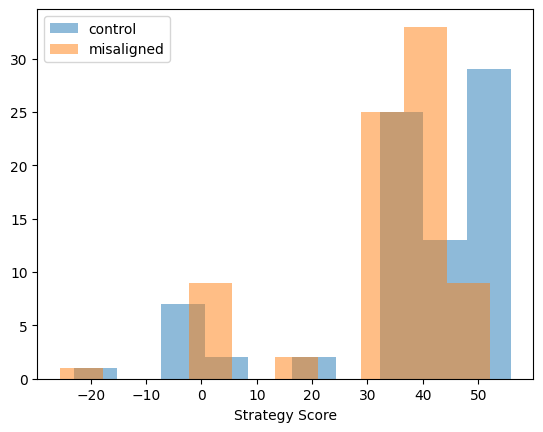

In [522]:
# Histogram of strategy scores
plt.figure()
control_counts, control_bins, _ = plt.hist(strategy_scores_control.values(), alpha=0.5, label='control')
mis_counts, mis_bins, _ = plt.hist(strategy_scores_mis.values(), alpha=0.5, label='misaligned')
plt.legend()
plt.xlabel("Strategy Score")
plt.show()

In [523]:
# Creating the strategy score dataframes

strategy_scores_mis_list = [[k,v] for k,v in strategy_scores_mis.items()]
strategy_scores_control_list = [[k,v] for k,v in strategy_scores_control.items()]

mis_cluster_df = pd.DataFrame(strategy_scores_mis_list, columns=["strategy", "score"])
control_cluster_df = pd.DataFrame(strategy_scores_control_list, columns=["strategy", "score"])

# Scale to 0-1:
mis_cluster_df['scoreScaled'] = (mis_cluster_df['score'] - mis_cluster_df['score'].min()) / (mis_cluster_df['score'].max() - mis_cluster_df['score'].min())
control_cluster_df['scoreScaled'] = (control_cluster_df['score'] - control_cluster_df['score'].min()) / (control_cluster_df['score'].max() - control_cluster_df['score'].min())


In [524]:
# Cluster the strategy scores

init_guesses = [0.6,0.5,0.4]
init_guesses = 3

mis_clusters = scipy.cluster.vq.kmeans(mis_cluster_df['scoreScaled'], k_or_guess=init_guesses)
mis_cluster_centers = sorted(mis_clusters[0], reverse=True)

control_clusters = scipy.cluster.vq.kmeans(control_cluster_df['scoreScaled'], k_or_guess=init_guesses)
control_cluster_centers = sorted(control_clusters[0], reverse=True)

In [525]:
# Compute the cluster labels: 0 - adaptive, 1 - moderately adaptive, 2 - maladaptive

mis_clusters_repeated = np.repeat(np.expand_dims(mis_cluster_centers, axis=0), len(mis_cluster_df), axis=0)
mis_cluster_distances = (mis_clusters_repeated - np.repeat(np.expand_dims(np.array(mis_cluster_df['scoreScaled']), axis=1),repeats=len(mis_cluster_centers), axis=1))**2
mis_cluster_labels = np.argmin(mis_cluster_distances, axis=1)

control_clusters_repeated = np.repeat(np.expand_dims(control_cluster_centers, axis=0), len(control_cluster_df), axis=0)
control_cluster_distances = (control_clusters_repeated - np.repeat(np.expand_dims(np.array(control_cluster_df['scoreScaled']), axis=1),repeats=len(control_cluster_centers), axis=1))**2
control_cluster_labels = np.argmin(control_cluster_distances, axis=1)

In [526]:
# Create dictionary of cluster labels:

mis_cluster_dict = { strat: cluster for (strat, cluster) in zip(mis_cluster_df.strategy, mis_cluster_labels)}

control_cluster_dict = { strat: cluster for (strat, cluster) in zip(control_cluster_df.strategy, control_cluster_labels)}


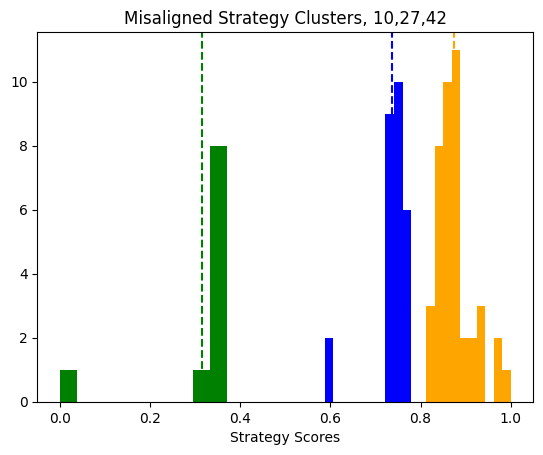

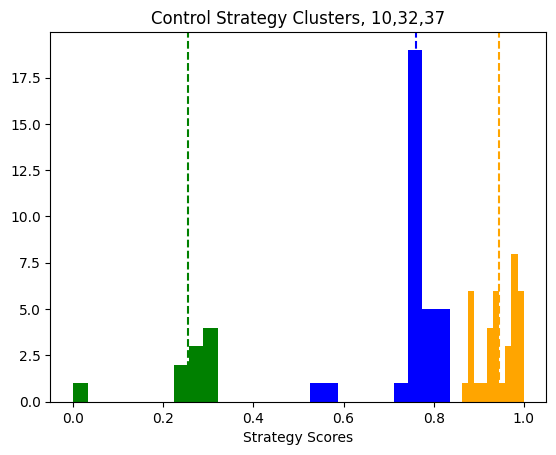

In [527]:
# Plotting the strategy clusters

plt.figure()
cluster_colors = ['orange', 'blue', 'green']
labels = ['adaptive', 'moderate', 'maladaptive']
cluster_sizes = []
for c in [0,1,2]:
    cluster_strats = [k for (k,v) in mis_cluster_dict.items() if v == c]
    cluster_scores = [list(mis_cluster_df.loc[mis_cluster_df.strategy==s]["scoreScaled"])[0] for s in cluster_strats]
    plt.hist(cluster_scores, color=cluster_colors[c], label=labels[c])
    plt.axvline(mis_cluster_centers[c], linestyle="--", color=cluster_colors[c])
    cluster_sizes.append(sum(value == c for value in mis_cluster_dict.values()))
cluster_sizes = [str(s) for s in cluster_sizes]
plt.title("Misaligned Strategy Clusters, {}".format(",".join(cluster_sizes[::-1])))
plt.xlabel("Strategy Scores")

cluster_sizes = []
plt.figure()
for c in [0,1,2]:
    cluster_strats = [k for (k,v) in control_cluster_dict.items() if v == c]
    cluster_scores = [list(control_cluster_df.loc[control_cluster_df.strategy==s]["scoreScaled"])[0] for s in cluster_strats]
    plt.hist(cluster_scores, color=cluster_colors[c], label=labels[c])
    cluster_sizes.append(sum(value == c for value in control_cluster_dict.values()))
    plt.axvline(control_cluster_centers[c], linestyle="--", color=cluster_colors[c])
cluster_sizes = [str(s) for s in cluster_sizes]
plt.title("Control Strategy Clusters, {}".format(",".join(cluster_sizes[::-1])))
plt.xlabel("Strategy Scores")
    
plt.show()

In [528]:
# Add clusters and strategy scores to strategy_df 

strategy_df['cluster'] = [None] * len(strategy_df)
strategy_df['strategyScores'] = [None] * len(strategy_df)

for idx, row in strategy_df.iterrows():
    if row['condition'] == 0:
        strategy_df.at[idx, 'cluster'] = control_cluster_dict[row['strategy']]
        strategy_df.at[idx, 'strategyScores'] = strategy_scores_control[row['strategy']]
    else:
        strategy_df.at[idx, 'cluster'] = mis_cluster_dict[row['strategy']]
        strategy_df.at[idx, 'strategyScores'] = strategy_scores_mis[row['strategy']]
    
    
strategy_df['strategyScores'] = strategy_df['strategyScores'].astype("float")

In [529]:
# Merging trial data with strategy data

strategy_cols = ["workerId", "trialNumbers", "strategy", "cluster", "strategyScores"]

all_trials_df = pd.merge(all_trials_df, strategy_df[strategy_cols], on=['workerId', "trialNumbers"])


In [530]:
# Scaling by optimal scores
optimal_env_score = {
    0: 55.89,
    1: 52.14
}

In [531]:
all_trials_df["strategyScores_scaled"] = all_trials_df["strategyScores"]
all_trials_df.loc[all_trials_df["condition"] == 0, "strategyScores_scaled"] = all_trials_df.loc[all_trials_df["condition"] == 0, "strategyScores_scaled"]/optimal_env_score[0]
all_trials_df.loc[all_trials_df["condition"] == 1, "strategyScores_scaled"] = all_trials_df.loc[all_trials_df["condition"] == 1, "strategyScores_scaled"]/optimal_env_score[1]

In [532]:
all_trials_df["expectedScores_scaled"] = all_trials_df["expectedScores"]
all_trials_df.loc[all_trials_df["condition"] == 0, "expectedScores_scaled"] = all_trials_df.loc[all_trials_df["condition"] == 0, "expectedScores_scaled"]/optimal_env_score[0]
all_trials_df.loc[all_trials_df["condition"] == 1, "expectedScores_scaled"] = all_trials_df.loc[all_trials_df["condition"] == 1, "expectedScores_scaled"]/optimal_env_score[1]

In [533]:
# Data to use for the remainder of the analysis

model_save_folder = "../results/model_sim_data/"
control_model = "2.0.3.0.0"
scarce_model = "2.0.3.0.0"
num_simulations = 1
model_file_name = f"c{control_model}_s{scarce_model}_{num_simulations}.csv"

use_model_data = False

if use_model_data:
    filtered_data = pd.read_csv(model_save_folder + model_file_name)
else:
    filtered_data = all_trials_df

In [534]:
filtered_data

trialScores  expectedScores  numClicks  avgClickLevel  trialNumbers   
0             44.0             0.0          0            0.0             1  \
1             60.0             0.0          0            0.0             2   
2             67.0             0.0          0            0.0             3   
3            -66.6            -2.6          4            2.5             4   
4             87.0             0.0          0            0.0             5   
...            ...             ...        ...            ...           ...   
20835         51.0             0.0          0            0.0            36   
20836        104.0             0.0          0            0.0            37   
20837         43.0             0.0          0            0.0            38   
20838          8.0             0.0          0            0.0            39   
20839        -15.0             0.0          0            0.0            40   

       condition                  workerId  clicksL1  clicksL2  clicksL3   
0              1  613789190e10970db0b4399f         0         0         0  \
1              1  613789190e10970db0b4399f         0         0         0   
2              1  613789190e10970db0b4399f         0         0         0   
3              1  613789190e10970db0b4399f         1         1         1   
4              1  613789190e10970db0b4399f         0         0         0   
...          ...                       ...       ...       ...       ...   
20835          1  62d140d43079cdd60f42d39e         0         0         0   
20836          1  62d140d43079cdd60f42d39e         0         0         0   
20837          1  62d140d43079cdd60f42d39e         0         0         0   
20838          1  62d140d43079cdd60f42d39e         0         0         0   
20839          1  62d140d43079cdd60f42d39e         0         0         0   

       clicksL4  clicksL5  clickStratsValid  replication strategy cluster   
0             0         0              True         True       30       2  \
1             0         0              True         True       30       2   
2             0         0              True         True       30       2   
3             1         0              True         True       61       1   
4             0         0              True         True       30       2   
...         ...       ...               ...          ...      ...     ...   
20835         0         0              True         True       30       2   
20836         0         0              True         True       30       2   
20837         0         0              True         True       30       2   
20838         0         0              True         True       30       2   
20839         0         0              True         True       30       2   

       strategyScores  strategyScores_scaled  expectedScores_scaled  
0        7.216450e-16           1.384052e-17               0.000000  
1        7.216450e-16           1.384052e-17               0.000000  
2        7.216450e-16           1.384052e-17               0.000000  
3        2.059369e+01           3.949690e-01              -0.049866  
4        7.216450e-16           1.384052e-17               0.000000  
...               ...                    ...                    ...  
20835    7.216450e-16           1.384052e-17               0.000000  
20836    7.216450e-16           1.384052e-17               0.000000  
20837    7.216450e-16           1.384052e-17               0.000000  
20838    7.216450e-16           1.384052e-17               0.000000  
20839    7.216450e-16           1.384052e-17               0.000000  

[20840 rows x 19 columns]

# Visualizing Data

## Expected Scores

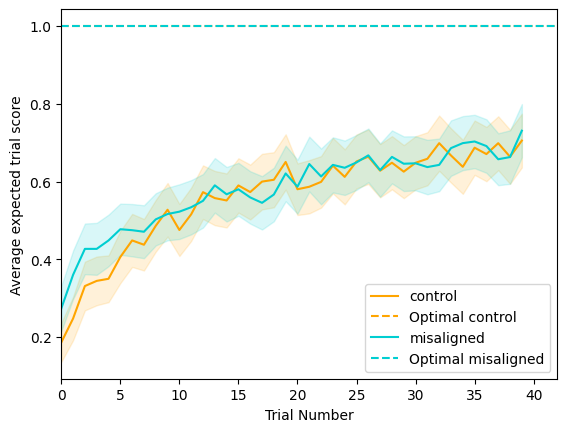

In [535]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

# If master switch is not turned on, select which data to use for this analysis
data_to_use = "all" # "1", "2", or "all"
if master_switch: data_to_use = data_to_use_master
if data_to_use == "1":
    data_to_copy = data_to_copy.loc[~data_to_copy.replication].reset_index(drop=True)
elif data_to_use == "2":
    data_to_copy = data_to_copy.loc[data_to_copy.replication].reset_index(drop=True)

conditions = {
    0: "control",
    1: "misaligned"
}

# Which metric to use for performance
performance_metric = "expectedScores"
optimal_env_score = {
    "control": 55.89,
    "misaligned": 52.14
}

scale_by_optimal = True

scaling_factor = optimal_env_score if scale_by_optimal else {k: 1 for k in optimal_env_score.keys()}

num_parts = {}
performance_data = {}

# For all conditions
# Find the number of participants, mean value of performance metric for each trial, 
#   and the standard error of the mean for each trial
for idx, cond in conditions.items():
    nump = len(data_to_copy.loc[data_to_copy.condition == idx].groupby('workerId'))
    num_parts[cond] = nump
    performance_data[cond] = {
        "mean": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').mean(numeric_only=True)[performance_metric]) / scaling_factor[cond],
        "se": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').std(numeric_only=True)[performance_metric]) / (np.sqrt(nump) * scaling_factor[cond])
    }

plot_se = True

plot_conds = ["control", "misaligned"]

color_list = ["orange", "darkturquoise", "firebrick"]

plt.figure()
#plt.title("Learning Curves over All Trials")

for idx,cond in enumerate(plot_conds):
    plt.plot(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"], label=cond, color=color_list[idx])
    if plot_se:
        plt.fill_between(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"] + 1.96*performance_data[cond]["se"], performance_data[cond]["mean"] - 1.96*performance_data[cond]["se"], alpha=0.15, color=color_list[idx])
    plt.axhline(optimal_env_score[cond]/scaling_factor[cond], color=color_list[idx], label=f"Optimal {cond}", linestyle="--")
#plt.axvline(13, linestyle='--', color='darkturquoise')
#plt.axvline(9, linestyle='--', color='firebrick')


plt.legend(loc="lower right")
#plt.ylim([10,60])
plt.xlim([0, 42])
plt.xlabel("Trial Number")
plt.ylabel("Average expected trial score")
plt.show()



## Actual Scores

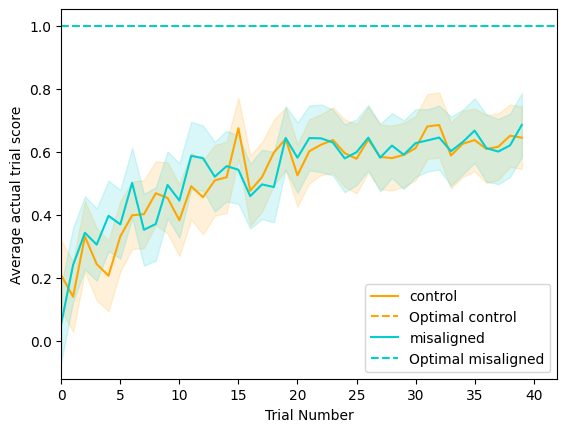

In [536]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

# If master switch is not turned on, select which data to use for this analysis
data_to_use = "all" # "1", "2", or "all"
if master_switch: data_to_use = data_to_use_master
if data_to_use == "1":
    data_to_copy = data_to_copy.loc[~data_to_copy.replication].reset_index(drop=True)
elif data_to_use == "2":
    data_to_copy = data_to_copy.loc[data_to_copy.replication].reset_index(drop=True)


conditions = {
    0: "control",
    1: "misaligned"
}

# Which metric to use for performance
performance_metric = "trialScores"

optimal_env_score = {
    "control": 55.89,
    "misaligned": 52.14
}

scale_by_optimal = True

scaling_factor = optimal_env_score if scale_by_optimal else {k: 1 for k in optimal_env_score.keys()}

num_parts = {}
performance_data = {}

# For all conditions
# Find the number of participants, mean value of performance metric for each trial, 
#   and the standard error of the mean for each trial
for idx, cond in conditions.items():
    nump = len(data_to_copy.loc[data_to_copy.condition == idx].groupby('workerId'))
    num_parts[cond] = nump
    performance_data[cond] = {
        "mean": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').mean(numeric_only=True)[performance_metric]) / scaling_factor[cond],
        "se": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').std(numeric_only=True)[performance_metric]) / (np.sqrt(nump) * scaling_factor[cond])
    }

plot_se = True

plot_conds = ["control", "misaligned"]

color_list = ["orange", "darkturquoise", "firebrick"]

plt.figure()
#plt.title("Learning Curves over All Trials")

for idx,cond in enumerate(plot_conds):
    plt.plot(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"], label=cond, color=color_list[idx])
    if plot_se:
        plt.fill_between(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"] + 1.96*performance_data[cond]["se"], performance_data[cond]["mean"] - 1.96*performance_data[cond]["se"], alpha=0.15, color=color_list[idx])
    plt.axhline(optimal_env_score[cond]/scaling_factor[cond], color=color_list[idx], label=f"Optimal {cond}", linestyle="--")

#plt.axvline(13, linestyle='--', color='darkturquoise')
#plt.axvline(9, linestyle='--', color='firebrick')
#plt.axhline(optimal_env_score, color='k', label='Optimal', linestyle="--")
plt.legend(loc="lower right")
#plt.ylim([10,60])
plt.xlim([0, 42])
plt.xlabel("Trial Number")
plt.ylabel("Average actual trial score")
plt.show()



## Clicks

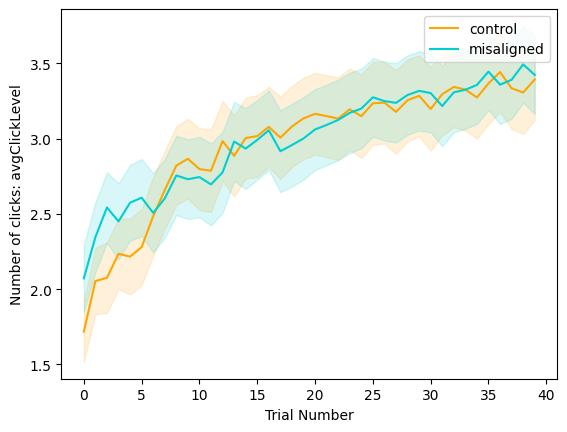

In [537]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

# If master switch is not turned on, select which data to use for this analysis
data_to_use = "all" # "1", "2", or "all"
if master_switch: data_to_use = data_to_use_master
if data_to_use == "1":
    data_to_copy = data_to_copy.loc[~data_to_copy.replication].reset_index(drop=True)
elif data_to_use == "2":
    data_to_copy = data_to_copy.loc[data_to_copy.replication].reset_index(drop=True)


# Filter out participants whose click strategies are not valid
data_to_copy = data_to_copy.loc[data_to_copy.clickStratsValid]

conditions = {
    0: "control",
    1: "misaligned"
}

# Which metric to use for performance
performance_metric = "avgClickLevel"
optimal_env_score = 5

num_parts = {}
performance_data = {}
full_data = {}

# For all conditions
# Find the number of participants, mean value of performance metric for each trial, 
#   and the standard error of the mean for each trial
for idx, cond in conditions.items():
    nump = len(data_to_copy.loc[data_to_copy.condition == idx].groupby('workerId'))
    num_parts[cond] = nump
    performance_data[cond] = {
        "mean": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').mean(numeric_only=True)[performance_metric]),
        "se": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').std(numeric_only=True)[performance_metric]) / np.sqrt(nump)
    }
    full_data[cond] = data_to_copy.loc[data_to_copy.condition == idx]

plot_se = True

plot_conds = ["control", "misaligned"]

color_list = ["orange", "darkturquoise", "firebrick"]

plt.figure()
#plt.title("Learning Curves over All Trials")

for idx,cond in enumerate(plot_conds):
    
    #plt.hist(full_data[cond][performance_metric],label=cond, color=color_list[idx], alpha=0.5)
    #plt.scatter(full_data[cond]["trialNumbers"], full_data[cond][performance_metric], label=cond, color=color_list[idx])
    plt.plot(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"], label=cond, color=color_list[idx])
    if plot_se:
        plt.fill_between(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"] + 1.96*performance_data[cond]["se"], performance_data[cond]["mean"] - 1.96*performance_data[cond]["se"], alpha=0.15, color=color_list[idx])

#plt.axvline(13, linestyle='--', color='darkturquoise')
#plt.axvline(9, linestyle='--', color='firebrick')
#plt.axhline(optimal_env_score, color='k', label='Optimal', linestyle="--")
plt.legend()
#plt.ylim([10,60])
#plt.xlim([0, 42])
plt.xlabel("Trial Number")
plt.ylabel("Number of clicks: " + performance_metric)
plt.show()



## Strategy Scores

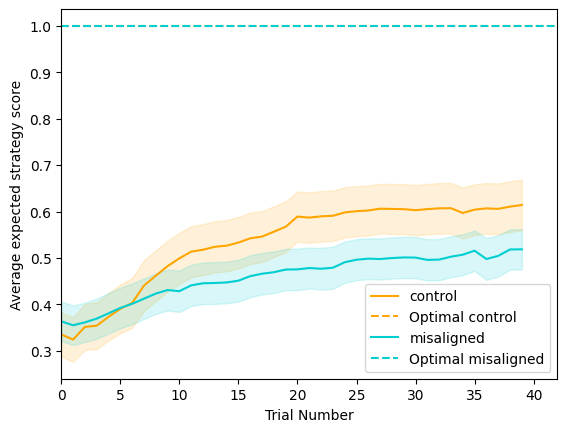

In [538]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

# If master switch is not turned on, select which data to use for this analysis
data_to_use = "all" # "1", "2", or "all"
if master_switch: data_to_use = data_to_use_master
if data_to_use == "1":
    data_to_copy = data_to_copy.loc[~data_to_copy.replication].reset_index(drop=True)
elif data_to_use == "2":
    data_to_copy = data_to_copy.loc[data_to_copy.replication].reset_index(drop=True)
    
conditions = {
    0: "control",
    1: "misaligned"
}

# Which metric to use for performance
performance_metric = "strategyScores"
optimal_env_score = {
    "control": 55.89,
    "misaligned": 52.14
}
# optimal_env_score = {
#     "control": 31.78,
#     "misaligned": 25.29
# }

scale_by_optimal = True

scaling_factor = optimal_env_score if scale_by_optimal else {k: 1 for k in optimal_env_score.keys()}

num_parts = {}
performance_data = {}

# For all conditions
# Find the number of participants, mean value of performance metric for each trial, 
#   and the standard error of the mean for each trial
for idx, cond in conditions.items():
    nump = len(data_to_copy.loc[data_to_copy.condition == idx].groupby('workerId'))
    num_parts[cond] = nump
    performance_data[cond] = {
        "mean": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').mean(numeric_only=True)[performance_metric]) / scaling_factor[cond],
        "se": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').std(numeric_only=True)[performance_metric]) / (np.sqrt(nump) * scaling_factor[cond])
    }

plot_se = True

plot_conds = ["control", "misaligned"]

color_list = ["orange", "darkturquoise", "firebrick"]

plt.figure()
#plt.title("Learning Curves over All Trials")

for idx,cond in enumerate(plot_conds):
    plt.plot(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"], label=cond, color=color_list[idx])
    if plot_se:
        plt.fill_between(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"] + 1.96*performance_data[cond]["se"], performance_data[cond]["mean"] - 1.96*performance_data[cond]["se"], alpha=0.15, color=color_list[idx])
    plt.axhline(optimal_env_score[cond]/scaling_factor[cond], color=color_list[idx], label=f"Optimal {cond}", linestyle="--")
#plt.axvline(13, linestyle='--', color='darkturquoise')
#plt.axvline(9, linestyle='--', color='firebrick')


plt.legend(loc="lower right")
#plt.ylim([10,60])
plt.xlim([0, 42])
plt.xlabel("Trial Number")
plt.ylabel("Average expected strategy score")
plt.show()



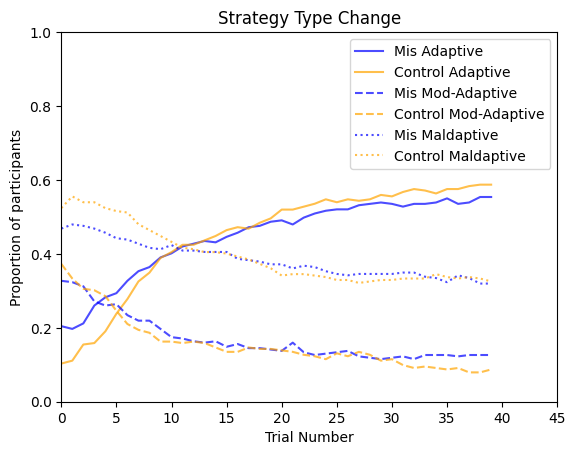

In [539]:
# Plotting Strategy cluster change

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

# If master switch is not turned on, select which data to use for this analysis
data_to_use = "all" # "1", "2", or "all"
if master_switch: data_to_use = data_to_use_master
if data_to_use == "1":
    data_to_copy = data_to_copy.loc[~data_to_copy.replication].reset_index(drop=True)
elif data_to_use == "2":
    data_to_copy = data_to_copy.loc[data_to_copy.replication].reset_index(drop=True)

scarce_trial_group = data_to_copy.loc[data_to_copy.condition == 1].groupby('trialNumbers')
control_trial_group = data_to_copy.loc[data_to_copy.condition == 0].groupby('trialNumbers')

# Taking the mean strategy score over all trials 
scarce_data_all = np.array(scarce_trial_group.mean(numeric_only=True)["strategyScores"])
scarce_data_all_sd = np.array(scarce_trial_group.std(numeric_only=True)["strategyScores"])
control_data = np.array(control_trial_group.mean(numeric_only=True)["strategyScores"])
control_data_sd = np.array(control_trial_group.std(numeric_only=True)["strategyScores"])

# Getting the proportions of clusters
scarce_data_adaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==0).sum()) / scarce_trial_group["cluster"].count())
control_data_adaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==0).sum()) / control_trial_group["cluster"].count())
scarce_data_modadaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==1).sum()) / scarce_trial_group["cluster"].count())
control_data_modadaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==1).sum()) / control_trial_group["cluster"].count())
scarce_data_maladaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==2).sum()) / scarce_trial_group["cluster"].count())
control_data_maladaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==2).sum()) / control_trial_group["cluster"].count())

plt.figure()
plt.title("Strategy Type Change")
alpha = 0.7
plt.plot(list(range(len(scarce_data_all))), scarce_data_adaptive, label="Mis Adaptive", color='b',alpha=alpha)
plt.plot(list(range(len(control_data))), control_data_adaptive, label="Control Adaptive",color='orange',alpha=alpha)
plt.plot(list(range(len(scarce_data_all))), scarce_data_modadaptive, label="Mis Mod-Adaptive", color='b',alpha=alpha, linestyle="--")
plt.plot(list(range(len(control_data))), control_data_modadaptive, label="Control Mod-Adaptive",color='orange',alpha=alpha, linestyle="--")
plt.plot(list(range(len(scarce_data_all))), scarce_data_maladaptive, label="Mis Maldaptive", color='b',alpha=alpha, linestyle=":")
plt.plot(list(range(len(control_data))), control_data_maladaptive, label="Control Maldaptive",color='orange',alpha=alpha, linestyle=":")
plt.legend()
plt.ylim([0,1])
plt.xlim([0, 45])
plt.xlabel("Trial Number")
plt.ylabel("Proportion of participants")
plt.show()


# 0.1 - Transforming Response Data

In [540]:
def scale_to_range(arr, lb, ub):
    return ((arr - arr.min()) / (arr.max() - arr.min())) * (ub - lb) + lb

In [541]:
# Selecting the response variable

response_vars = ["expectedScores", 'expectedScores_scaled', 'avgClickLevel', "clicksL1", "clicksL5", "strategyScores", 'strategyScores_scaled']

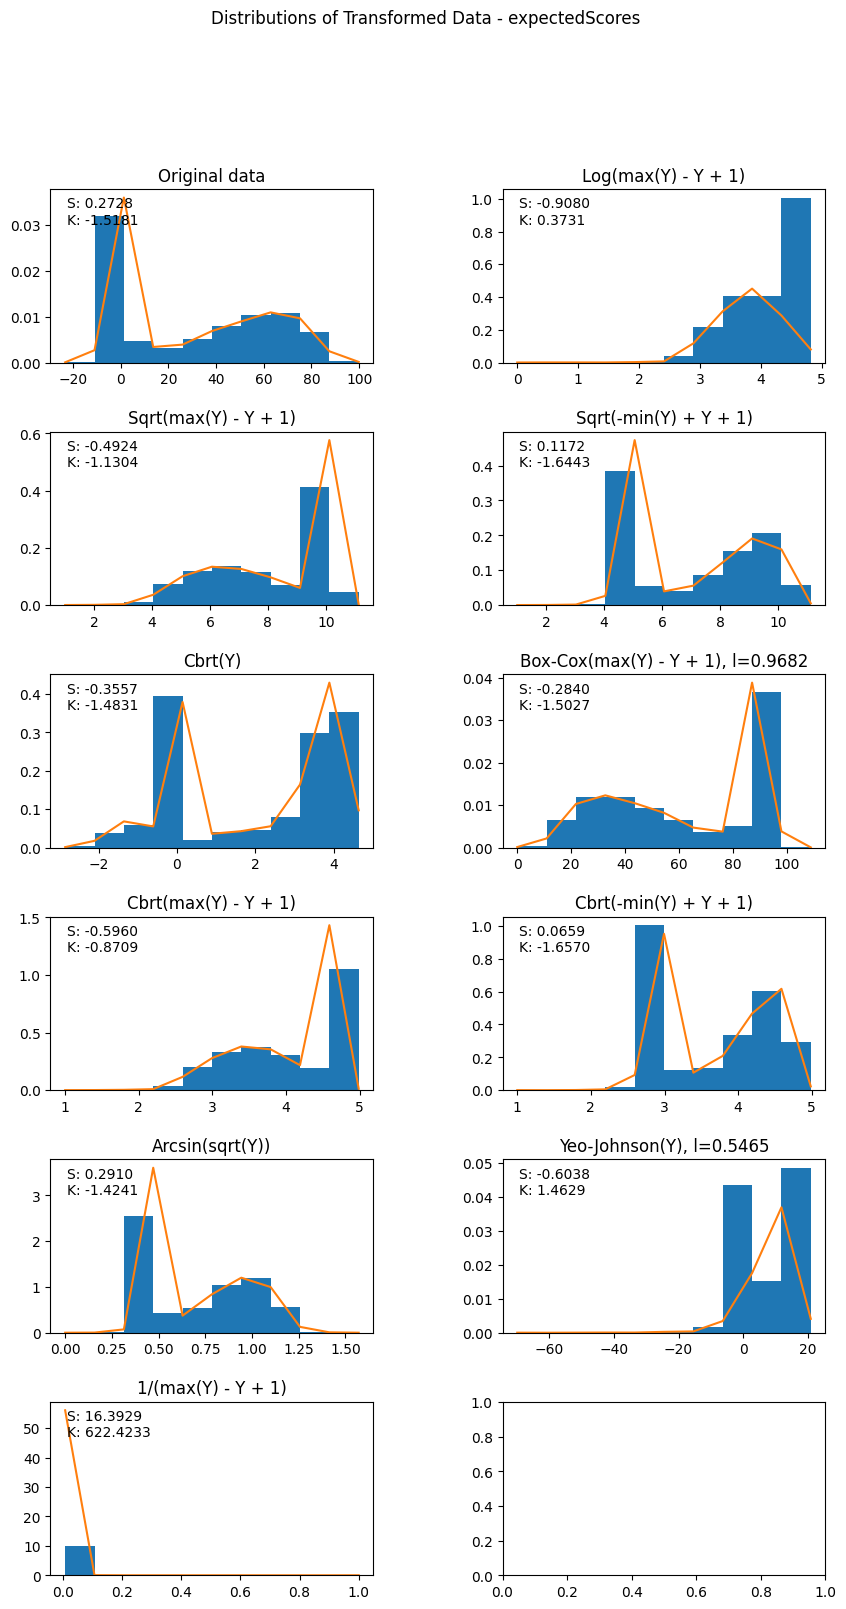

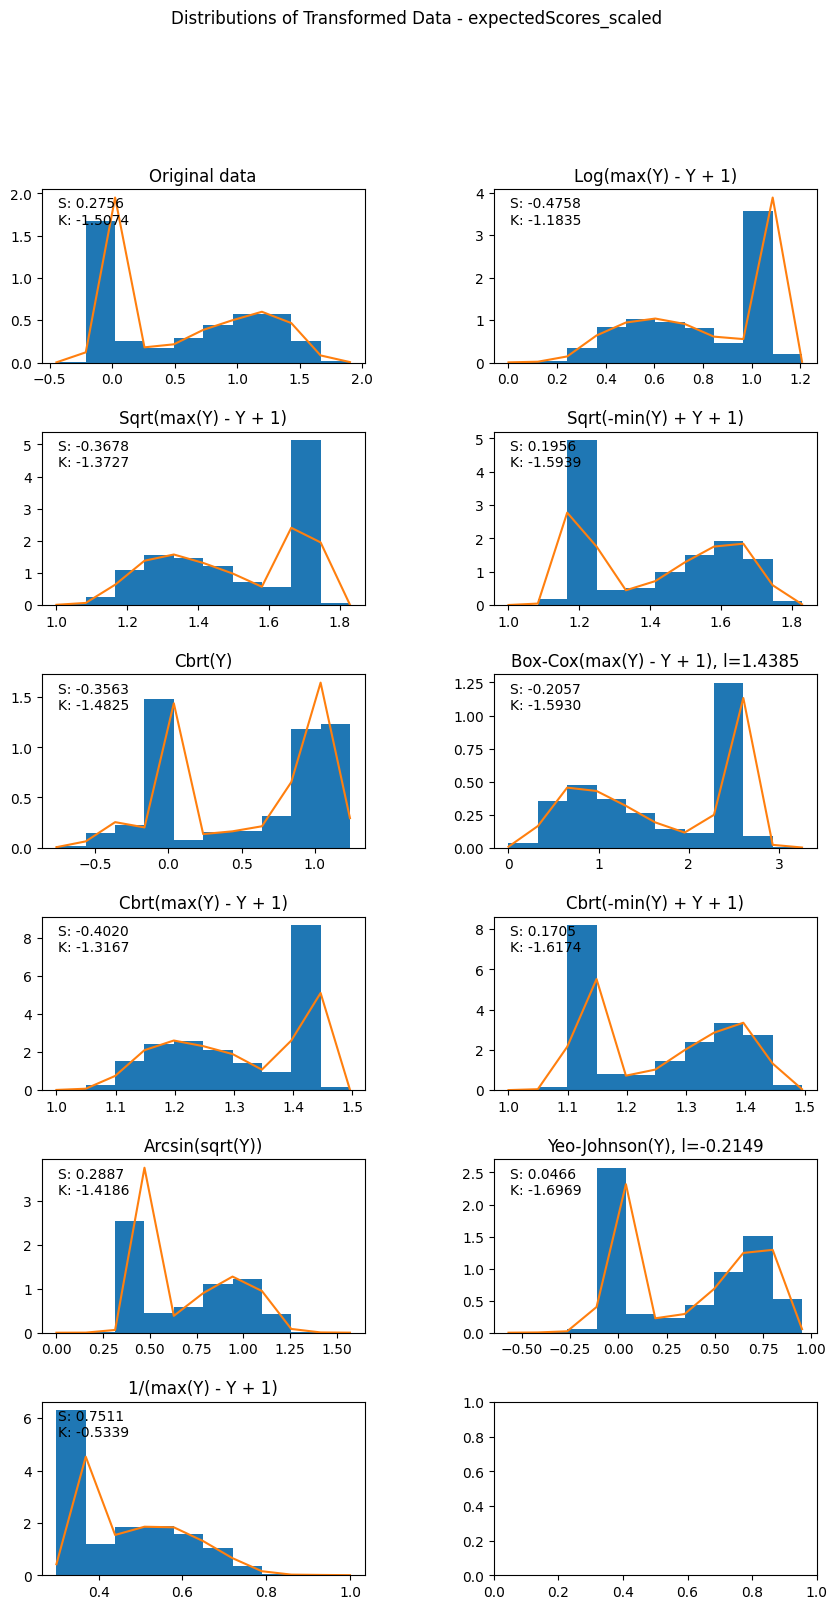

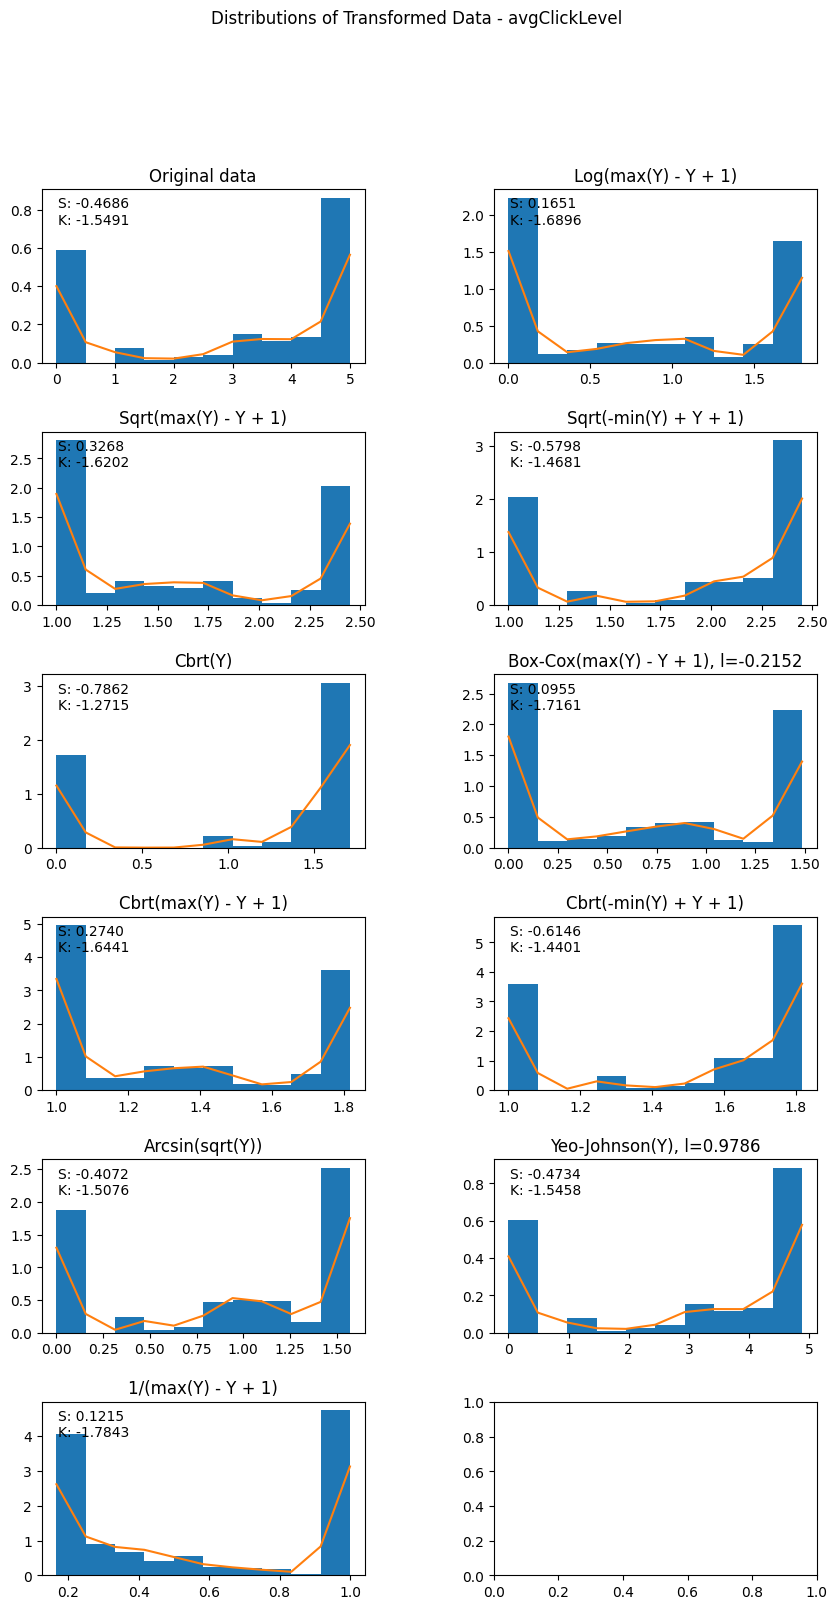

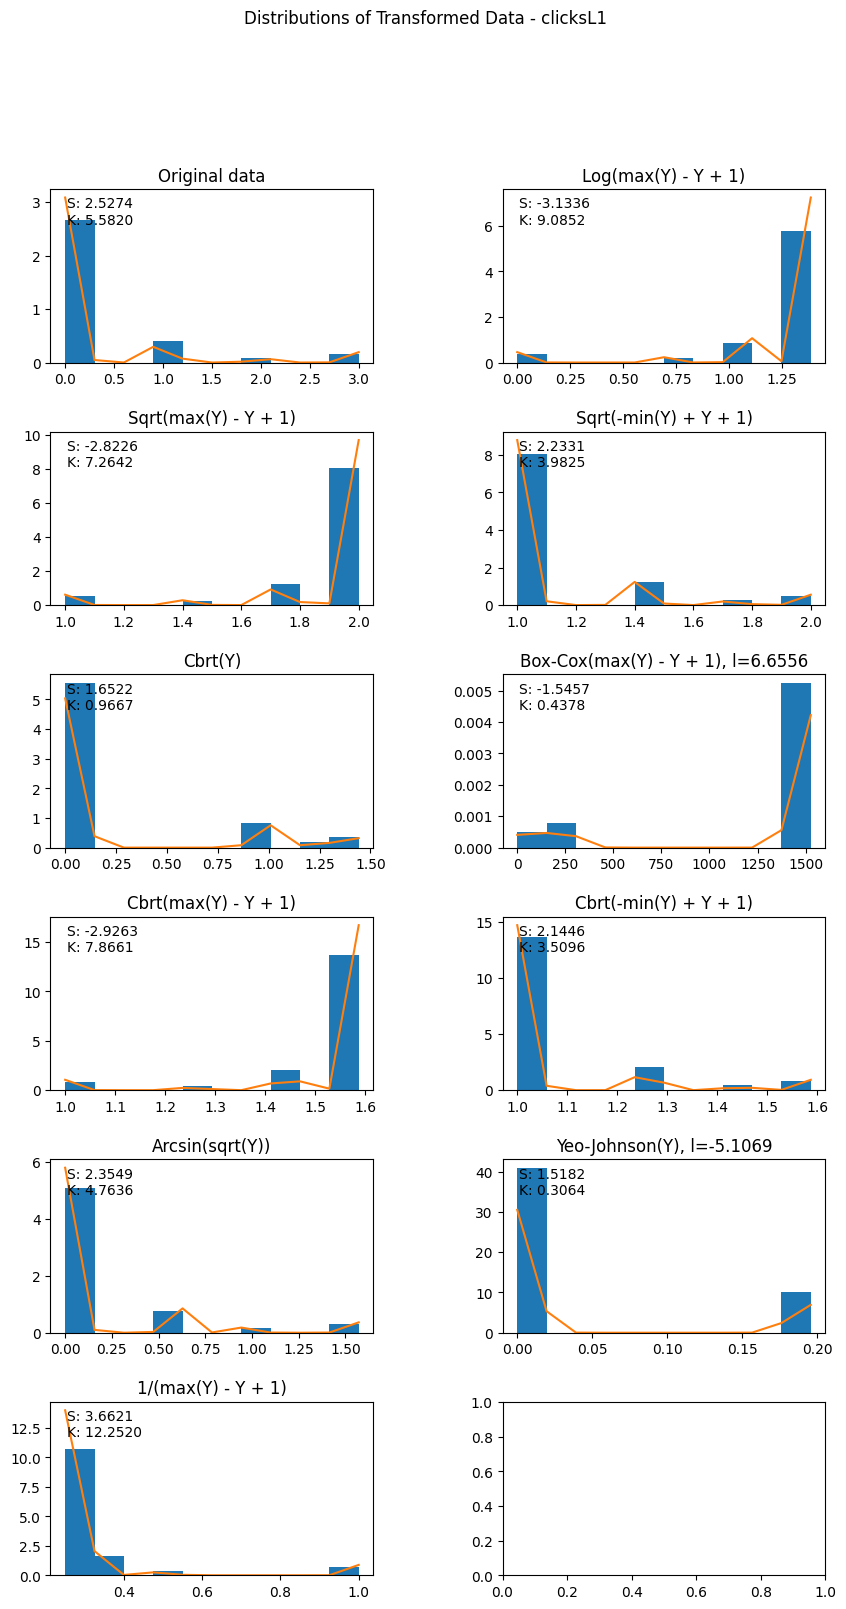

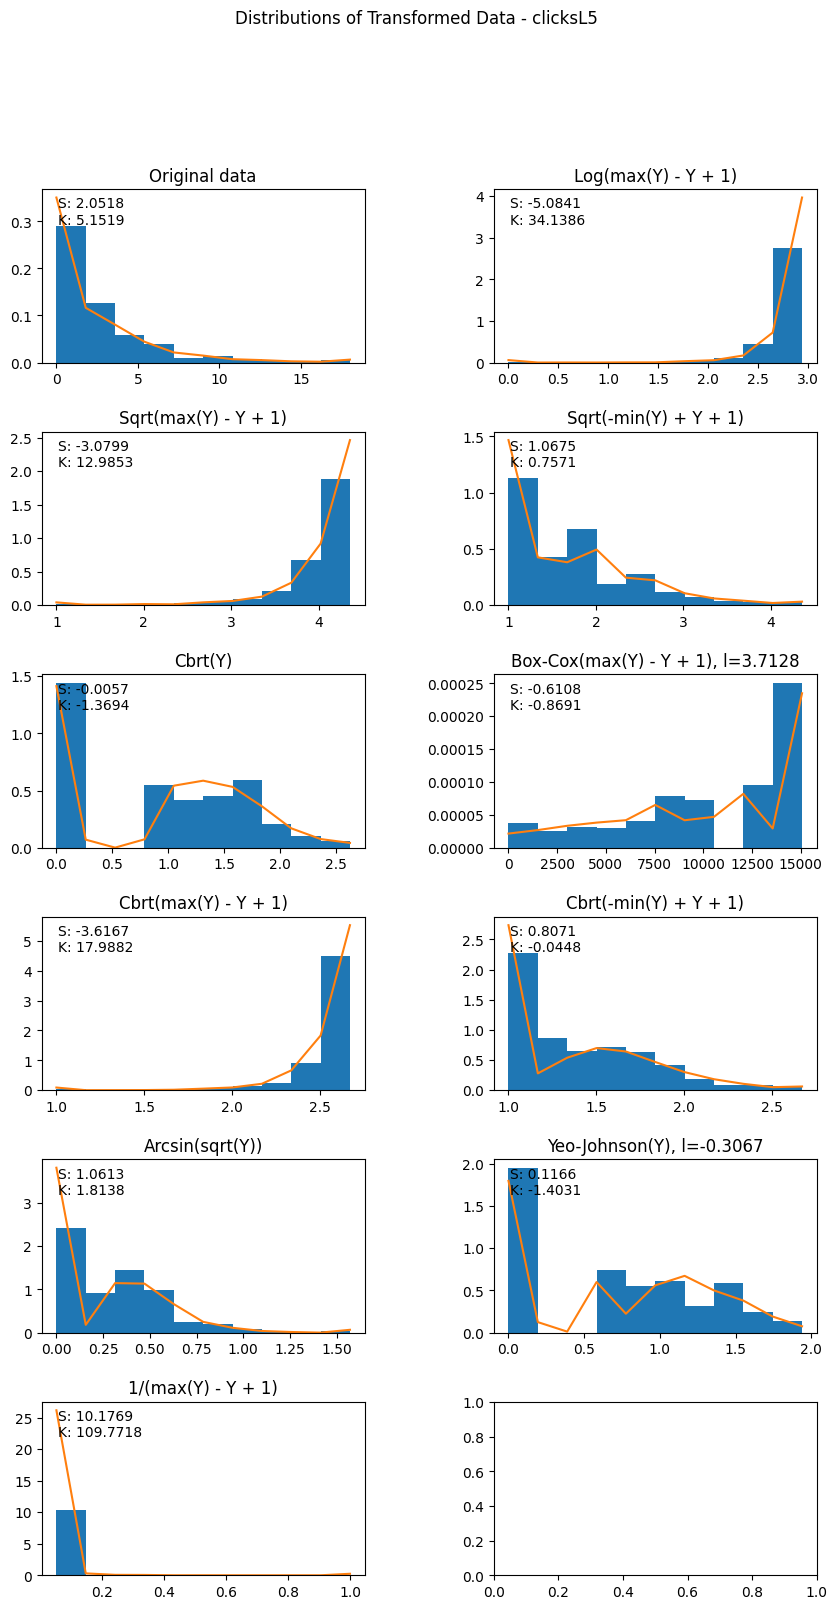

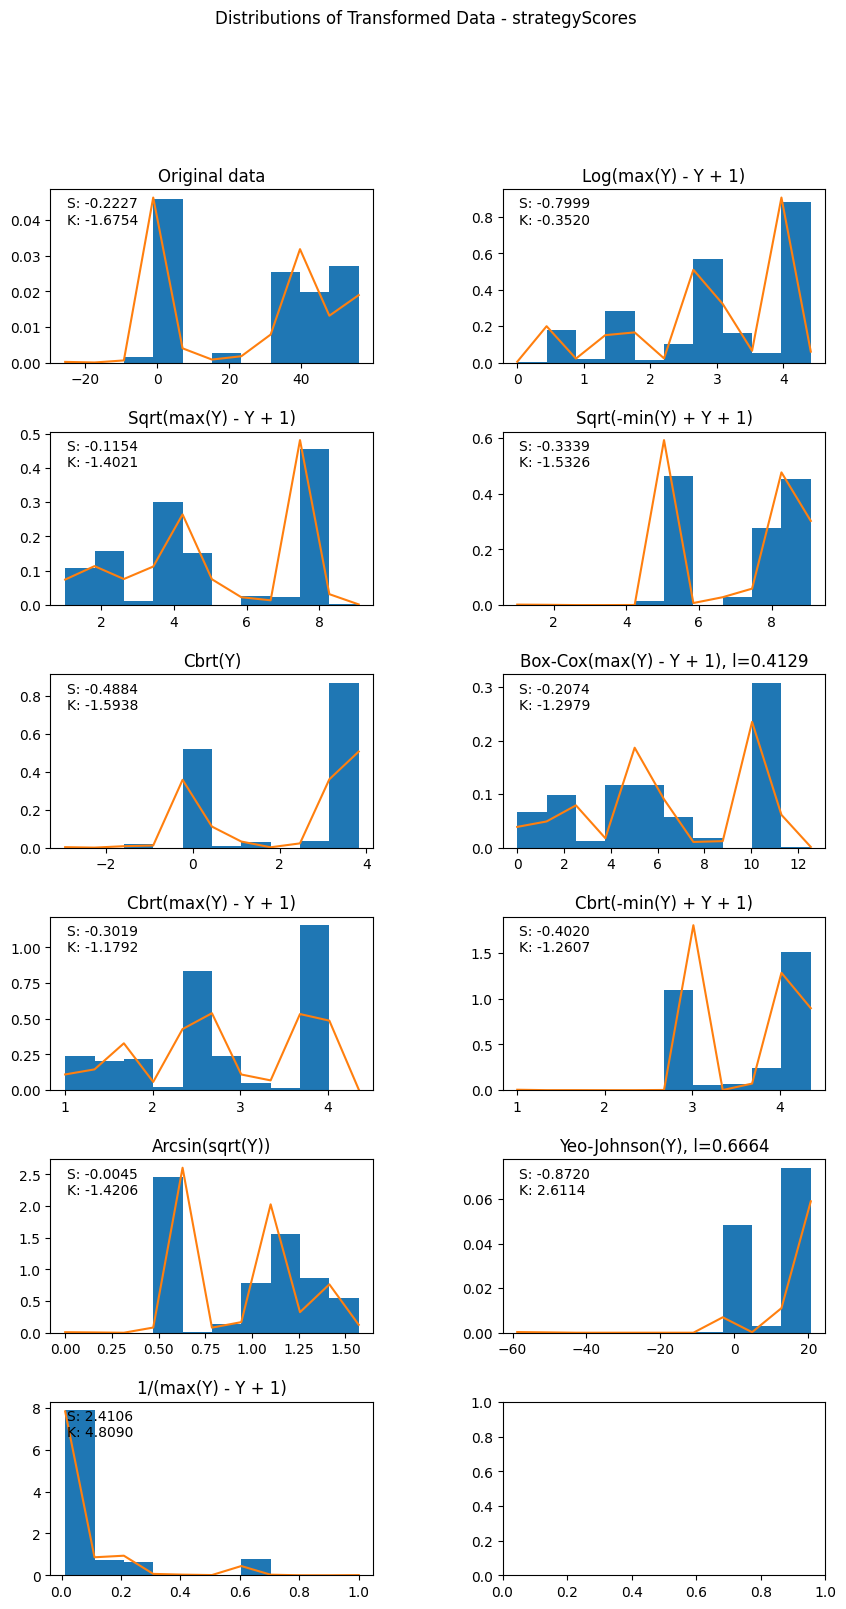

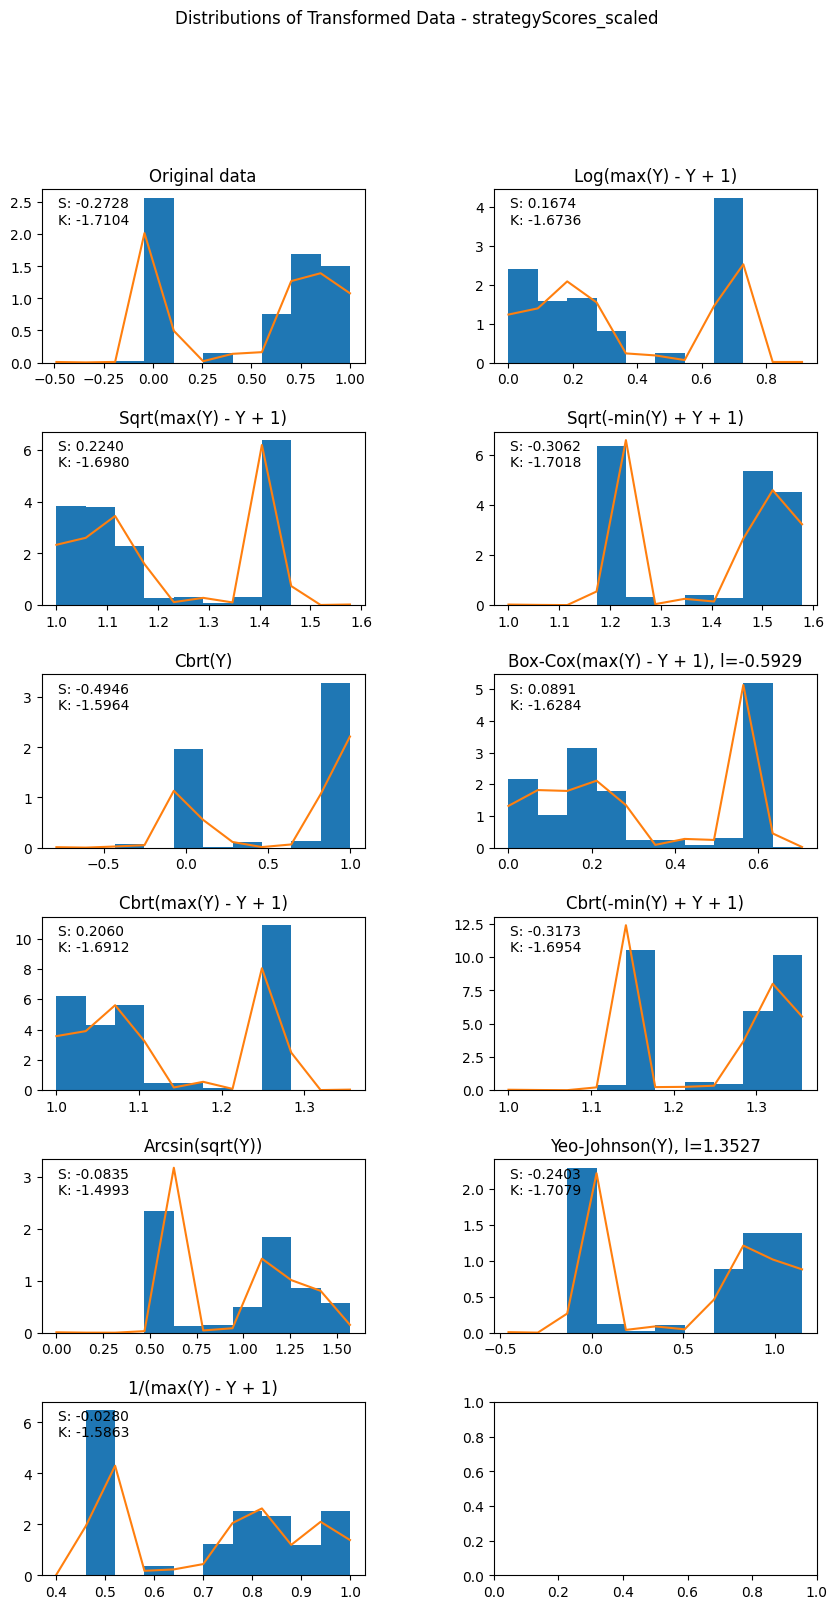

In [542]:
# Transforming the data

data_to_copy = filtered_data.copy() # or outliers_excluded

# If master switch is not turned on, select which data to use for this analysis
data_to_use = "all" # "1", "2", or "all"
if master_switch: data_to_use = data_to_use_master
if data_to_use == "1":
    data_to_copy = data_to_copy.loc[~data_to_copy.replication].reset_index(drop=True)
elif data_to_use == "2":
    data_to_copy = data_to_copy.loc[data_to_copy.replication].reset_index(drop=True)
    
transformed_trials_df = data_to_copy.copy()
trans_list = {res: [] for res in response_vars}

for response_var in response_vars:
    

    log_transformed_trials_df = data_to_copy.copy()
    sq_transformed_trials_df = data_to_copy.copy()
    sq2_transformed_trials_df = data_to_copy.copy()
    cb_transformed_trials_df = data_to_copy.copy()
    cb2_transformed_trials_df = data_to_copy.copy()
    cb3_transformed_trials_df = data_to_copy.copy()
    arcsin_transformed_trials_df = data_to_copy.copy()
    bc_transformed_trials_df = data_to_copy.copy()
    yj_transformed_trials_df = data_to_copy.copy()
    inverse_transformed_trials_df = data_to_copy.copy()

    # Compute separate dataframes for each transformation
    log_transformed_trials_df[response_var] = np.log(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    sq_transformed_trials_df[response_var] = np.sqrt(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    sq2_transformed_trials_df[response_var] = np.sqrt(-transformed_trials_df[response_var].min() + 1 + transformed_trials_df[response_var])
    cb_transformed_trials_df[response_var] = np.cbrt(transformed_trials_df[response_var])
    cb2_transformed_trials_df[response_var] = np.cbrt(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    cb3_transformed_trials_df[response_var] = np.cbrt(-transformed_trials_df[response_var].min() + 1 + transformed_trials_df[response_var])
    arcsin_transformed_trials_df[response_var] = np.arcsin(np.sqrt(scale_to_range(transformed_trials_df[response_var], 0, 1)))
    bc_transformed_trials_df[response_var],lam = scipy.stats.boxcox(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    #logit_transformed_trials_df[response_var] = scipy.special.logit(scale_to_range(transformed_trials_df[response_var], 0, 1))
    yj_transformed_trials_df[response_var],lam_y = scipy.stats.yeojohnson(transformed_trials_df[response_var])
    inverse_transformed_trials_df[response_var] = 1/(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])

    # All the transformed data and the corresponding transformation
    trans_list[response_var] = [
        (transformed_trials_df, "Original data"),
        (log_transformed_trials_df, "Log(max(Y) - Y + 1)"),
        (sq_transformed_trials_df, "Sqrt(max(Y) - Y + 1)"),
        (sq2_transformed_trials_df, "Sqrt(-min(Y) + Y + 1)"),
        (cb_transformed_trials_df, "Cbrt(Y)"),
        (bc_transformed_trials_df, "Box-Cox(max(Y) - Y + 1), l={0:0.4f}".format(lam)),
        (cb2_transformed_trials_df, "Cbrt(max(Y) - Y + 1)"),
        (cb3_transformed_trials_df, "Cbrt(-min(Y) + Y + 1)"),
        (arcsin_transformed_trials_df, "Arcsin(sqrt(Y))"),
        (yj_transformed_trials_df, "Yeo-Johnson(Y), l={0:0.4f}".format(lam_y)),
        (inverse_transformed_trials_df, "1/(max(Y) - Y + 1)")
    ]
    
    # Plot all the transformed data
    fig, ax = plt.subplots(nrows=math.ceil(len(trans_list[response_var])/2),ncols=2,figsize=(10, 3 * math.ceil(len(trans_list[response_var])/2)),squeeze=False)
    plt.suptitle("Distributions of Transformed Data - {}".format(response_var))
    ax = ax.flatten()

    for idx, trans in enumerate(trans_list[response_var]):
        data = trans[0][response_var]
        label = trans[1]
        skew = scipy.stats.skew(data)
        density = scipy.stats.gaussian_kde(data)
        kurtosis = scipy.stats.kurtosis(data)
        n, x, _ = ax[idx].hist(data, density=True)
        ax[idx].set_title(label)
        ax[idx].plot(x, density(x))
        ax[idx].text(0.05,0.8, "S: {0:0.4f}\nK: {1:0.4f}".format(skew, kurtosis), transform=ax[idx].transAxes)

    plt.subplots_adjust(
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

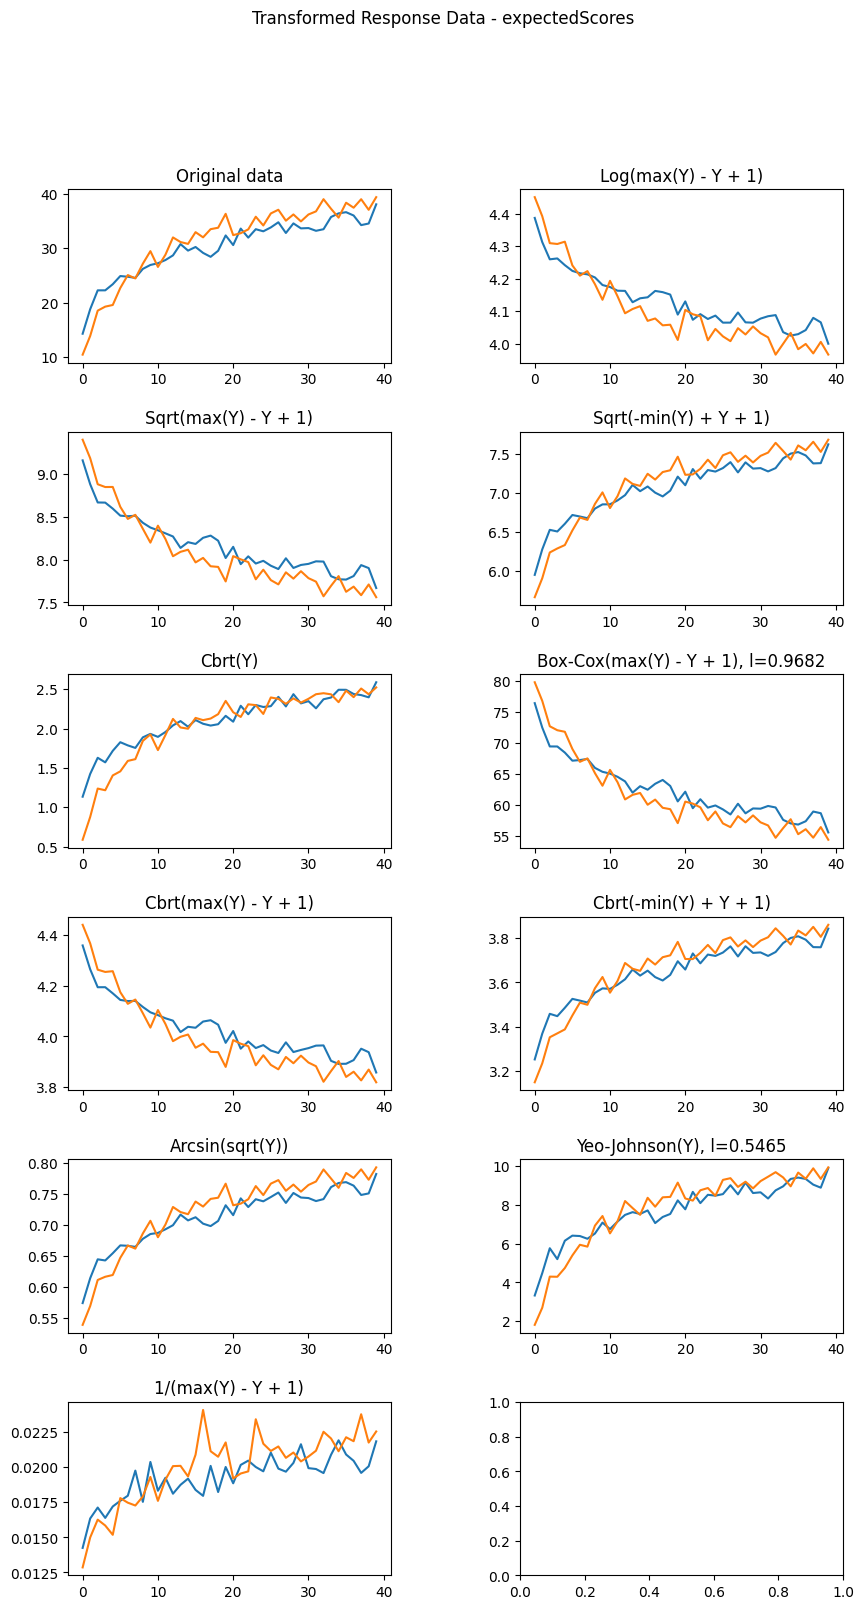

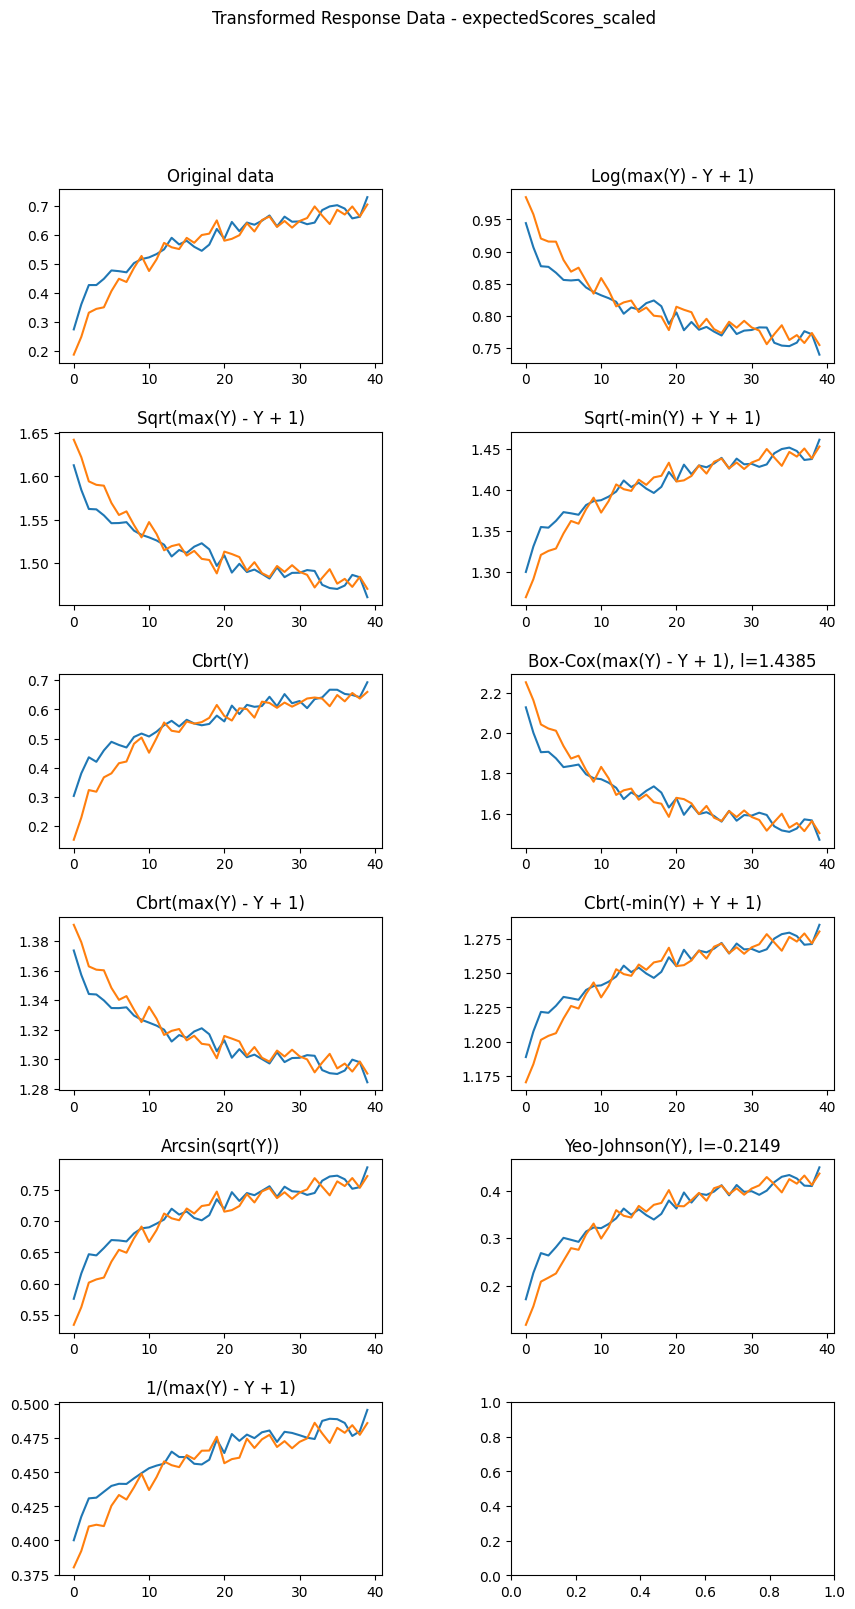

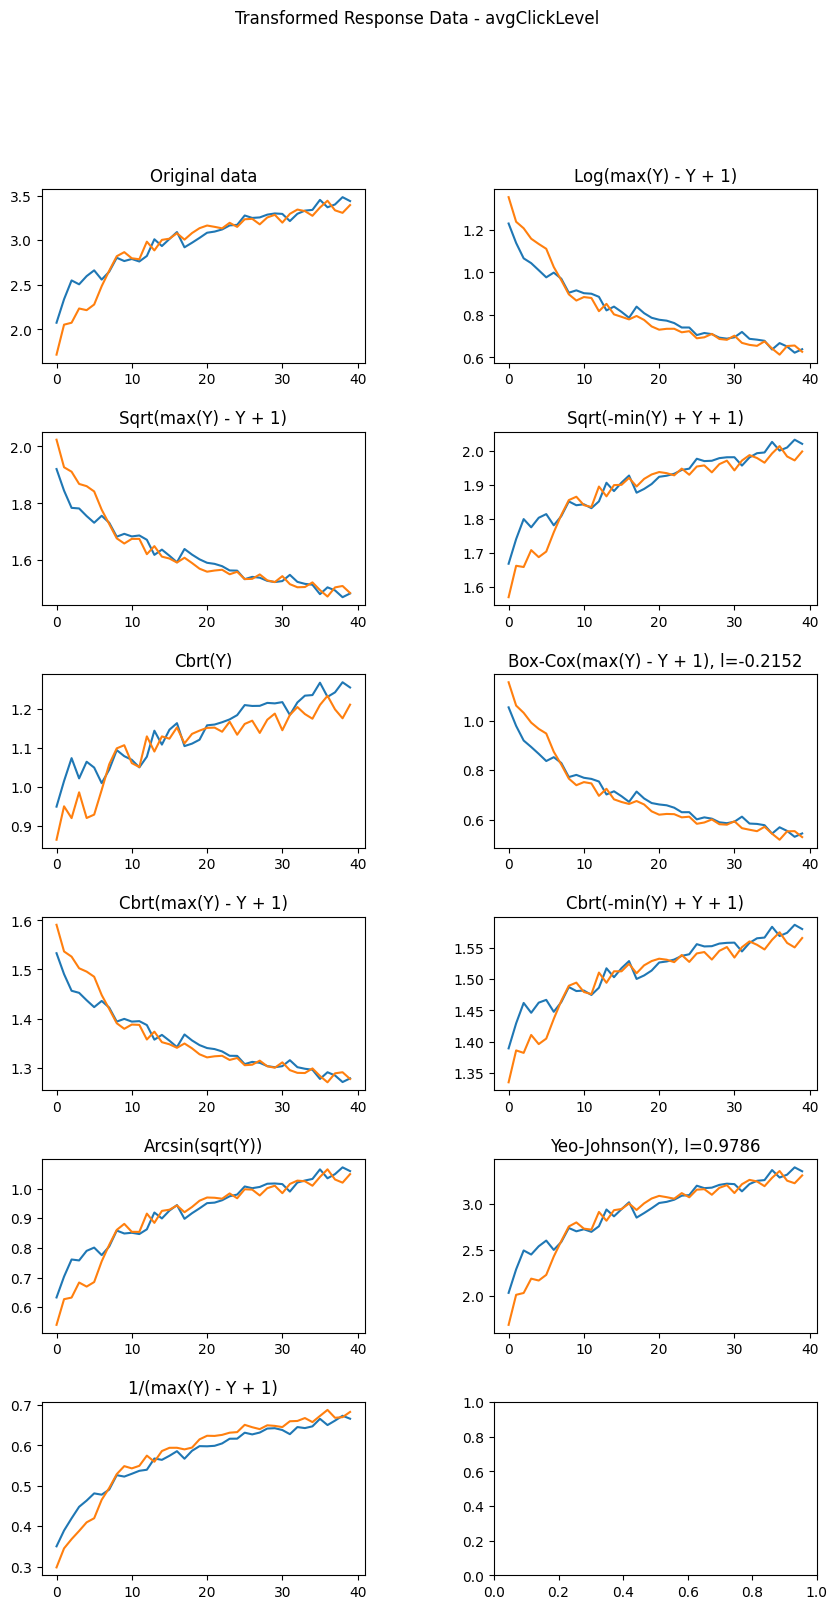

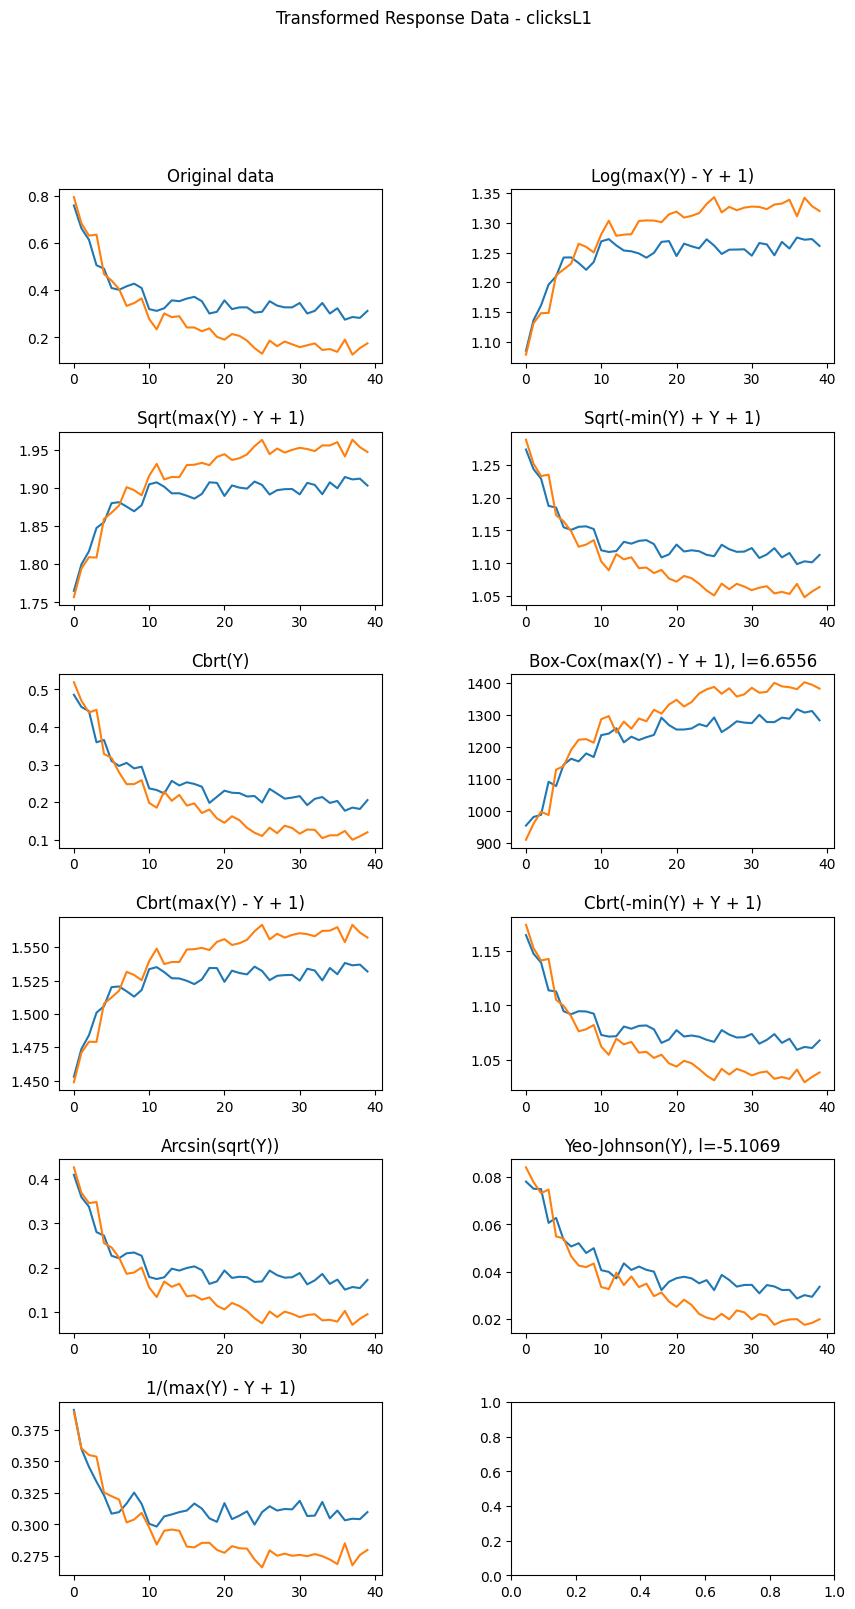

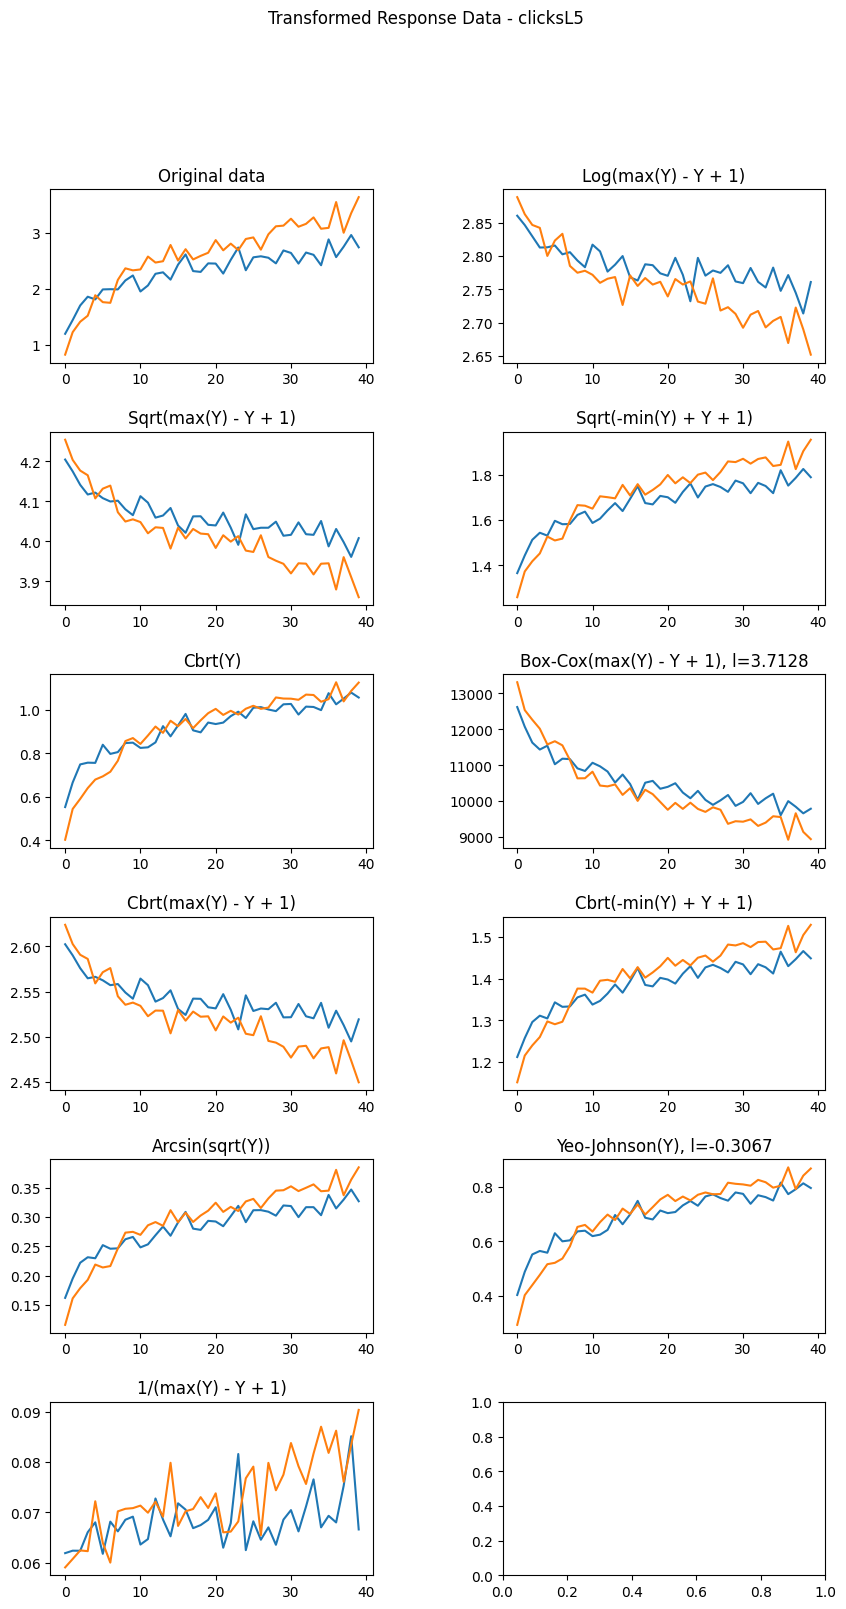

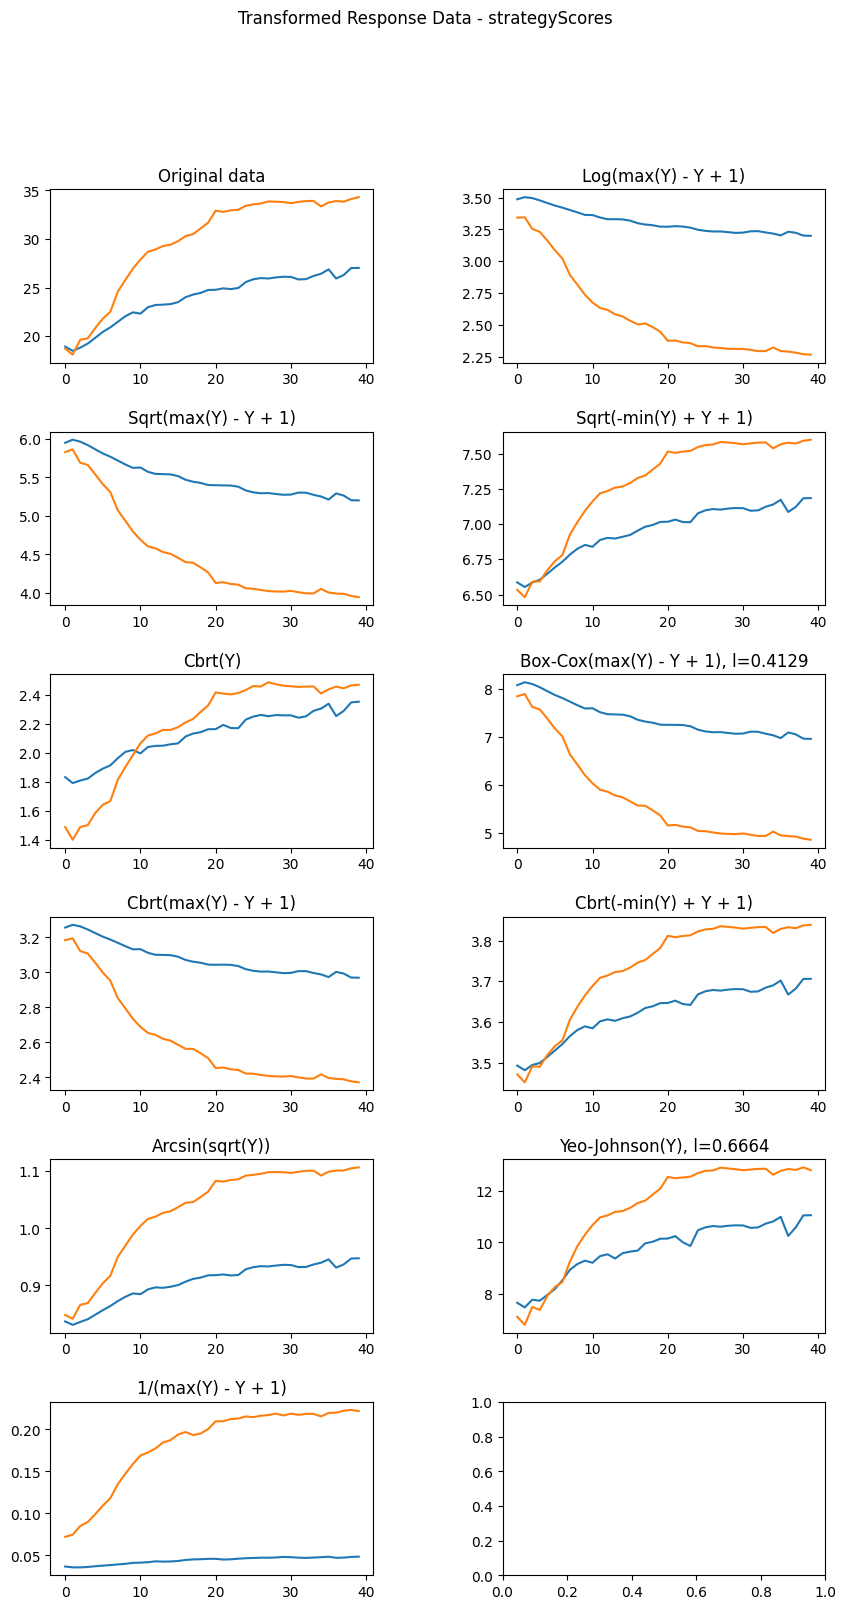

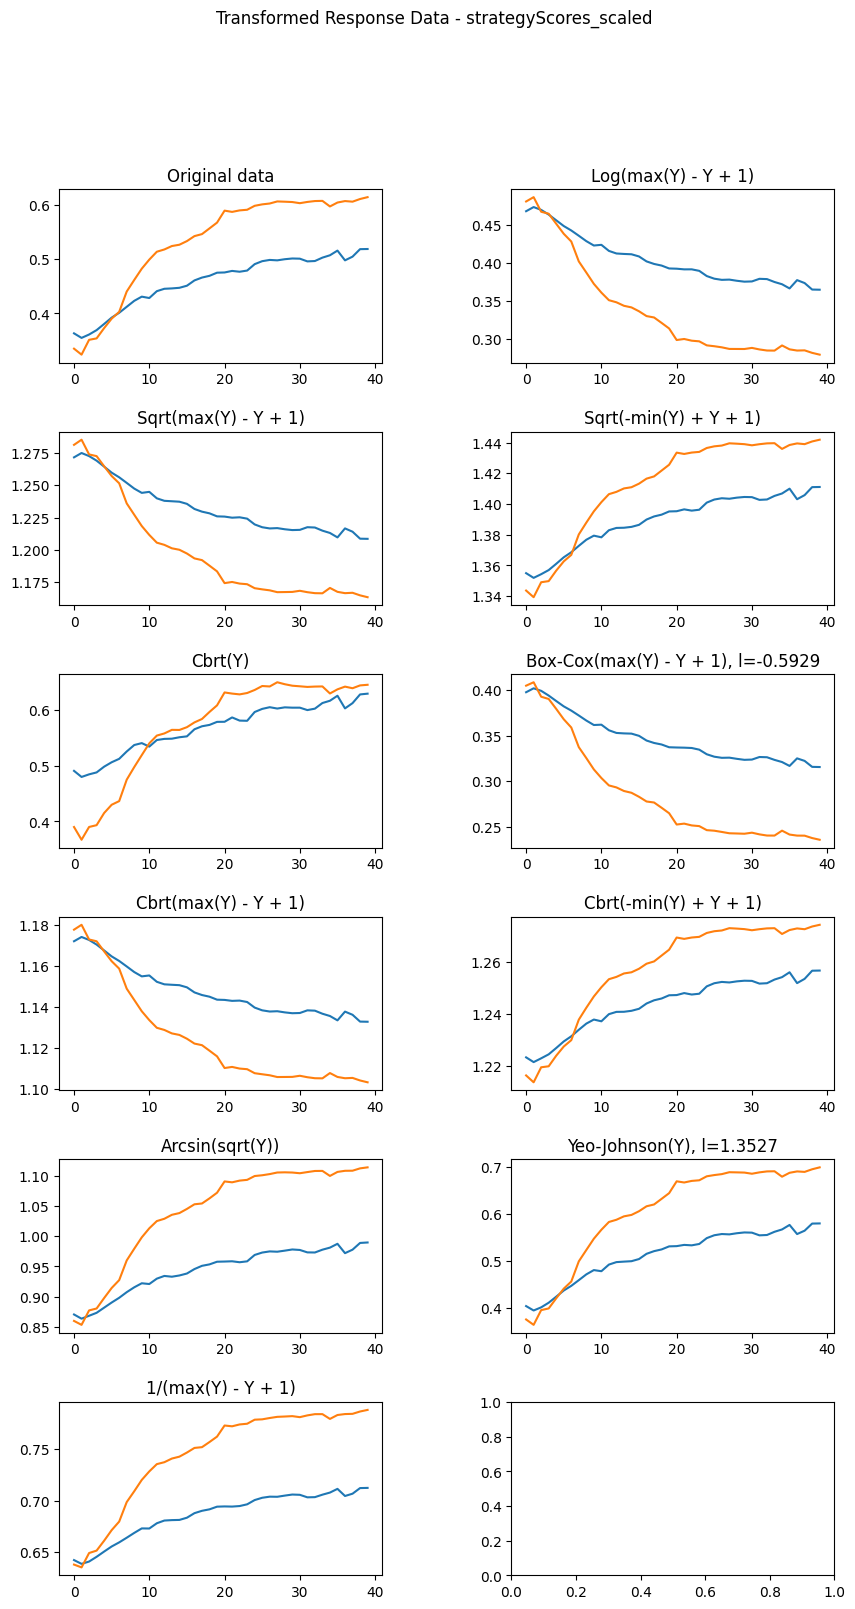

In [543]:
# Plotting the response data

for response_var in response_vars:
    fig, ax = plt.subplots(nrows=math.ceil(len(trans_list[response_var])/2),ncols=2,figsize=(10, 3 * math.ceil(len(trans_list[response_var])/2)),squeeze=False)
    plt.suptitle("Transformed Response Data - {}".format(response_var))
    ax = ax.flatten()

    for idx, trans in enumerate(trans_list[response_var]):
        data = trans[0]
        scarce = data.loc[data.condition == 1]
        control = data.loc[data.condition == 0]
        label = trans[1]

        scarce_mean = np.array(scarce.groupby('trialNumbers').mean(numeric_only=True)[response_var])
        control_mean = np.array(control.groupby('trialNumbers').mean(numeric_only=True)[response_var])
        ax[idx].plot(list(range(len(scarce_mean))), scarce_mean, label="Exp")
        ax[idx].plot(list(range(len(control_mean))), control_mean, label="Control")
        ax[idx].set_title(label)

    plt.subplots_adjust(
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

## Linear Regression: Expected Score vs. Trial Number x Condition

In [544]:
# formula = "expectedScores ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"

In [545]:
# GLM Model 1 - Expected score vs. Trial number & Condition - all possible transformations

# Creating the list of data to subplot all residuals

all_residuals = {res: [] for res in response_vars}
mixed = True

for response_var in response_vars:
    formula = '{} ~ C(trialNumbers) + C(condition)'.format(response_var);

    # Perform regression on each transformed dataset
    for idx, trans in enumerate(trans_list[response_var]):
        if mixed:
            glm = smf.mixedlm(formula=formula, data=trans[0], groups=trans[0]['workerId'])
        else:
            glm = smf.glm(formula=formula, data=trans[0])

        results = glm.fit()

        print("\n{} - {}:".format(response_var, trans[1]))
        print(results.summary())

        resids = results.resid_response if not mixed else results.resid
        normaltest = scipy.stats.normaltest(resids)
        
        # Save the results of the regression for plotting
        all_residuals[response_var].append((
            resids,
            trans[0][response_var],
            trans[1],
            normaltest
        ))



expectedScores - Original data:
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  expectedScores
No. Observations:    20840    Method:              REML          
No. Groups:          521      Scale:               448.4815      
Min. group size:     40       Log-Likelihood:      -94114.5986   
Max. group size:     40       Converged:           Yes           
Mean group size:     40.0                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              12.996    1.656  7.847 0.000  9.750 16.242
C(trialNumbers)[T.2]    3.994    1.312  3.044 0.002  1.422  6.565
C(trialNumbers)[T.3]    8.046    1.312  6.132 0.000  5.474 10.617
C(trialNumbers)[T.4]    8.404    1.312  6.405 0.000  5.832 10.976
C(trialNumbers)[T.5]    9.132    1.312  6.960 0.000  6.56


expectedScores - Sqrt(-min(Y) + Y + 1):
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  expectedScores
No. Observations:   20840    Method:              REML          
No. Groups:         521      Scale:               2.0214        
Min. group size:    40       Log-Likelihood:      -37960.9435   
Max. group size:    40       Converged:           Yes           
Mean group size:    40.0                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              5.835    0.115 50.692 0.000  5.609  6.060
C(trialNumbers)[T.2]   0.288    0.088  3.274 0.001  0.116  0.461
C(trialNumbers)[T.3]   0.579    0.088  6.574 0.000  0.406  0.752
C(trialNumbers)[T.4]   0.593    0.088  6.731 0.000  0.420  0.766
C(trialNumbers)[T.5]   0.665    0.088  7.555 0.000  0.493  0.83


expectedScores - Cbrt(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  expectedScores
No. Observations:    20840    Method:              REML          
No. Groups:          521      Scale:               0.2503        
Min. group size:     40       Log-Likelihood:      -16152.8538   
Max. group size:     40       Converged:           Yes           
Mean group size:     40.0                                        
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              4.382    0.036 120.720 0.000  4.311  4.453
C(trialNumbers)[T.2]  -0.084    0.031  -2.711 0.007 -0.145 -0.023
C(trialNumbers)[T.3]  -0.171    0.031  -5.515 0.000 -0.232 -0.110
C(trialNumbers)[T.4]  -0.175    0.031  -5.652 0.000 -0.236 -0.114
C(trialNumbers)[T.5]  -0.186    0.031  -6.009 0.00


expectedScores - Yeo-Johnson(Y), l=0.5465:
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  expectedScores
No. Observations:   20840    Method:              REML          
No. Groups:         521      Scale:               35.1229       
Min. group size:    40       Log-Likelihood:      -67586.7035   
Max. group size:    40       Converged:           Yes           
Mean group size:    40.0                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              2.641    0.440  6.005 0.000  1.779  3.503
C(trialNumbers)[T.2]   1.026    0.367  2.794 0.005  0.306  1.746
C(trialNumbers)[T.3]   2.466    0.367  6.716 0.000  1.746  3.186
C(trialNumbers)[T.4]   2.172    0.367  5.915 0.000  1.452  2.892
C(trialNumbers)[T.5]   2.882    0.367  7.848 0.000  2.162  3

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



expectedScores - 1/(max(Y) - Y + 1):
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  expectedScores
No. Observations:   20840    Method:              REML          
No. Groups:         521      Scale:               0.0003        
Min. group size:    40       Log-Likelihood:      55009.3513    
Max. group size:    40       Converged:           Yes           
Mean group size:    40.0                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.014    0.001 16.212 0.000  0.012  0.016
C(trialNumbers)[T.2]   0.002    0.001  2.047 0.041  0.000  0.004
C(trialNumbers)[T.3]   0.003    0.001  3.035 0.002  0.001  0.005
C(trialNumbers)[T.4]   0.003    0.001  2.469 0.014  0.001  0.005
C(trialNumbers)[T.5]   0.003    0.001  2.565 0.010  0.001  0.005
C


expectedScores_scaled - Sqrt(max(Y) - Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: expectedScores_scaled
No. Observations: 20840   Method:             REML                 
No. Groups:       521     Scale:              0.0183               
Min. group size:  40      Log-Likelihood:     10998.0050           
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                1.631    0.010 158.211 0.000  1.611  1.651
C(trialNumbers)[T.2]    -0.024    0.008  -2.918 0.004 -0.041 -0.008
C(trialNumbers)[T.3]    -0.049    0.008  -5.891 0.000 -0.066 -0.033
C(trialNumbers)[T.4]    -0.052    0.008  -6.148 0.000 -0.068 -0.035
C(trialNumbers)[


expectedScores_scaled - Box-Cox(max(Y) - Y + 1), l=1.4385:
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: expectedScores_scaled
No. Observations: 20840   Method:             REML                 
No. Groups:       521     Scale:              0.3053               
Min. group size:  40      Log-Likelihood:     -18287.7872          
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                2.199    0.044  50.141 0.000  2.113  2.285
C(trialNumbers)[T.2]    -0.108    0.034  -3.164 0.002 -0.175 -0.041
C(trialNumbers)[T.3]    -0.216    0.034  -6.305 0.000 -0.283 -0.149
C(trialNumbers)[T.4]    -0.225    0.034  -6.562 0.000 -0.292 -0.158
C(t

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



expectedScores_scaled - Cbrt(max(Y) - Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: expectedScores_scaled
No. Observations: 20840   Method:             REML                 
No. Groups:       521     Scale:              0.0064               
Min. group size:  40      Log-Likelihood:     21972.5929           
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                1.384    0.006 229.475 0.000  1.372  1.396
C(trialNumbers)[T.2]    -0.014    0.005  -2.871 0.004 -0.024 -0.005
C(trialNumbers)[T.3]    -0.029    0.005  -5.812 0.000 -0.038 -0.019
C(trialNumbers)[T.4]    -0.030    0.005  -6.063 0.000 -0.040 -0.020
C(trialNumbers)[

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



expectedScores_scaled - Cbrt(-min(Y) + Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: expectedScores_scaled
No. Observations: 20840   Method:             REML                 
No. Groups:       521     Scale:              0.0064               
Min. group size:  40      Log-Likelihood:     21822.3881           
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                         Coef. Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                1.178    0.006 183.309 0.000  1.166  1.191
C(trialNumbers)[T.2]     0.016    0.005   3.225 0.001  0.006  0.026
C(trialNumbers)[T.3]     0.032    0.005   6.419 0.000  0.022  0.042
C(trialNumbers)[T.4]     0.033    0.005   6.635 0.000  0.023  0.043
C(trialNumbers)

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



expectedScores_scaled - 1/(max(Y) - Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: expectedScores_scaled
No. Observations: 20840   Method:             REML                 
No. Groups:       521     Scale:              0.0091               
Min. group size:  40      Log-Likelihood:     18299.6080           
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                          Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.387    0.007 58.006 0.000  0.374  0.400
C(trialNumbers)[T.2]      0.015    0.006  2.495 0.013  0.003  0.026
C(trialNumbers)[T.3]      0.030    0.006  5.133 0.000  0.019  0.042
C(trialNumbers)[T.4]      0.031    0.006  5.279 0.000  0.020  0.043
C(trialNumbers)[T.


avgClickLevel - Sqrt(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   avgClickLevel
No. Observations:   20840     Method:               REML         
No. Groups:         521       Scale:                0.1179       
Min. group size:    40        Log-Likelihood:       -8568.0001   
Max. group size:    40        Converged:            Yes          
Mean group size:    40.0                                         
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              1.975    0.035  55.997 0.000  1.906  2.044
C(trialNumbers)[T.2]  -0.086    0.021  -4.047 0.000 -0.128 -0.044
C(trialNumbers)[T.3]  -0.125    0.021  -5.872 0.000 -0.167 -0.083
C(trialNumbers)[T.4]  -0.147    0.021  -6.900 0.000 -0.188 -0.105
C(trialNumbers)[T.5]  -0.164    0.021  -7.727 0.000


avgClickLevel - Box-Cox(max(Y) - Y + 1), l=-0.2152:
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   avgClickLevel
No. Observations:   20840     Method:               REML         
No. Groups:         521       Scale:                0.1290       
Min. group size:    40        Log-Likelihood:       -9487.6905   
Max. group size:    40        Converged:            Yes          
Mean group size:    40.0                                         
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              1.103    0.036  30.555 0.000  1.032  1.174
C(trialNumbers)[T.2]  -0.084    0.022  -3.792 0.000 -0.128 -0.041
C(trialNumbers)[T.3]  -0.129    0.022  -5.798 0.000 -0.173 -0.085
C(trialNumbers)[T.4]  -0.162    0.022  -7.265 0.000 -0.205 -0.118
C(trialNumbers)[T.5]  -0.188    0.022


avgClickLevel - Arcsin(sqrt(Y)):
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  avgClickLevel
No. Observations:   20840    Method:              REML         
No. Groups:         521      Scale:               0.1339       
Min. group size:    40       Log-Likelihood:      -9888.3402   
Max. group size:    40       Converged:           Yes          
Mean group size:    40.0                                       
---------------------------------------------------------------
                      Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.581    0.038 15.461 0.000  0.507  0.654
C(trialNumbers)[T.2]  0.078    0.023  3.450 0.001  0.034  0.123
C(trialNumbers)[T.3]  0.111    0.023  4.878 0.000  0.066  0.155
C(trialNumbers)[T.4]  0.133    0.023  5.887 0.000  0.089  0.178
C(trialNumbers)[T.5]  0.144    0.023  6.332 0.000  0.099  0.188
C(trialNumbers)[T.6


clicksL1 - Original data:
              Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   clicksL1   
No. Observations:     20840     Method:               REML       
No. Groups:           521       Scale:                0.2862     
Min. group size:      40        Log-Likelihood:       -17580.1015
Max. group size:      40        Converged:            Yes        
Mean group size:      40.0                                       
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              0.726    0.040  17.952 0.000  0.647  0.805
C(trialNumbers)[T.2]  -0.104    0.033  -3.127 0.002 -0.169 -0.039
C(trialNumbers)[T.3]  -0.154    0.033  -4.633 0.000 -0.219 -0.089
C(trialNumbers)[T.4]  -0.207    0.033  -6.254 0.000 -0.272 -0.142
C(trialNumbers)[T.5]  -0.296    0.033  -8.918 0.000 -0.361 -0.2


clicksL1 - Sqrt(-min(Y) + Y + 1):
              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    clicksL1 
No. Observations:     20840      Method:                REML     
No. Groups:           521        Scale:                 0.0349   
Min. group size:      40         Log-Likelihood:        4306.6203
Max. group size:      40         Converged:             Yes      
Mean group size:      40.0                                       
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              1.263    0.014  88.843 0.000  1.235  1.291
C(trialNumbers)[T.2]  -0.033    0.012  -2.849 0.004 -0.056 -0.010
C(trialNumbers)[T.3]  -0.050    0.012  -4.283 0.000 -0.072 -0.027
C(trialNumbers)[T.4]  -0.070    0.012  -6.039 0.000 -0.093 -0.047
C(trialNumbers)[T.5]  -0.101    0.012  -8.725 0.000 -0.

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



clicksL1 - Cbrt(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    clicksL1  
No. Observations:    20840      Method:                REML      
No. Groups:          521        Scale:                 0.0100    
Min. group size:     40         Log-Likelihood:        17303.3823
Max. group size:     40         Converged:             Yes       
Mean group size:     40.0                                        
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              1.460    0.007 195.303 0.000  1.446  1.475
C(trialNumbers)[T.2]   0.021    0.006   3.464 0.001  0.009  0.034
C(trialNumbers)[T.3]   0.031    0.006   4.959 0.000  0.019  0.043
C(trialNumbers)[T.4]   0.039    0.006   6.357 0.000  0.027  0.052
C(trialNumbers)[T.5]   0.056    0.006   9.002 0.000  0.0

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



clicksL1 - Yeo-Johnson(Y), l=-5.1069:
              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    clicksL1  
No. Observations:    20840      Method:                REML      
No. Groups:          521        Scale:                 0.0029    
Min. group size:     40         Log-Likelihood:        30033.7873
Max. group size:     40         Converged:             Yes       
Mean group size:     40.0                                        
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              0.077    0.004  18.923 0.000  0.069  0.085
C(trialNumbers)[T.2]  -0.005    0.003  -1.364 0.172 -0.011  0.002
C(trialNumbers)[T.3]  -0.007    0.003  -2.063 0.039 -0.014 -0.000
C(trialNumbers)[T.4]  -0.014    0.003  -4.043 0.000 -0.020 -0.007
C(trialNumbers)[T.5]  -0.022    0.003  -6.574 0.000


clicksL5 - Log(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    clicksL5  
No. Observations:    20840      Method:                REML      
No. Groups:          521        Scale:                 0.0752    
Min. group size:     40         Log-Likelihood:        -3515.3521
Max. group size:     40         Converged:             Yes       
Mean group size:     40.0                                        
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              2.859    0.017 167.616 0.000  2.826  2.892
C(trialNumbers)[T.2]  -0.020    0.017  -1.151 0.250 -0.053  0.014
C(trialNumbers)[T.3]  -0.036    0.017  -2.122 0.034 -0.069 -0.003
C(trialNumbers)[T.4]  -0.047    0.017  -2.760 0.006 -0.080 -0.014
C(trialNumbers)[T.5]  -0.067    0.017  -3.949 0.000 -0.10


clicksL5 - Cbrt(Y):
             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   clicksL5   
No. Observations:    20840     Method:               REML       
No. Groups:          521       Scale:                0.2107     
Min. group size:     40        Log-Likelihood:       -14562.2307
Max. group size:     40        Converged:            Yes        
Mean group size:     40.0                                       
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.481    0.044 10.952 0.000  0.395  0.567
C(trialNumbers)[T.2]   0.127    0.028  4.461 0.000  0.071  0.183
C(trialNumbers)[T.3]   0.192    0.028  6.762 0.000  0.137  0.248
C(trialNumbers)[T.4]   0.220    0.028  7.752 0.000  0.165  0.276
C(trialNumbers)[T.5]   0.239    0.028  8.402 0.000  0.183  0.295
C(trialNumbers)[T.


clicksL5 - Cbrt(-min(Y) + Y + 1):
             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   clicksL5  
No. Observations:     20840     Method:               REML      
No. Groups:           521       Scale:                0.0706    
Min. group size:      40        Log-Likelihood:       -3100.3678
Max. group size:      40        Converged:            Yes       
Mean group size:      40.0                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              1.194    0.022 54.179 0.000  1.151  1.237
C(trialNumbers)[T.2]   0.054    0.016  3.296 0.001  0.022  0.087
C(trialNumbers)[T.3]   0.086    0.016  5.214 0.000  0.054  0.118
C(trialNumbers)[T.4]   0.103    0.016  6.282 0.000  0.071  0.136
C(trialNumbers)[T.5]   0.118    0.016  7.173 0.000  0.086  0.150
C(tr

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



clicksL5 - 1/(max(Y) - Y + 1):
             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   clicksL5  
No. Observations:     20840     Method:               REML      
No. Groups:           521       Scale:                0.0054    
Min. group size:      40        Log-Likelihood:       23980.1790
Max. group size:      40        Converged:            Yes       
Mean group size:      40.0                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.063    0.004 15.883 0.000  0.055  0.071
C(trialNumbers)[T.2]   0.001    0.005  0.232 0.817 -0.008  0.010
C(trialNumbers)[T.3]   0.002    0.005  0.410 0.682 -0.007  0.011
C(trialNumbers)[T.4]   0.004    0.005  0.810 0.418 -0.005  0.013
C(trialNumbers)[T.5]   0.009    0.005  2.078 0.038  0.001  0.018
C(trial


strategyScores - Sqrt(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  strategyScores
No. Observations:    20840    Method:              REML          
No. Groups:          521      Scale:               0.9424        
Min. group size:     40       Log-Likelihood:      -30344.7563   
Max. group size:     40       Converged:           Yes           
Mean group size:     40.0                                        
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              5.378    0.130  41.365 0.000  5.123  5.632
C(trialNumbers)[T.2]   0.039    0.060   0.640 0.522 -0.079  0.156
C(trialNumbers)[T.3]  -0.058    0.060  -0.965 0.334 -0.176  0.060
C(trialNumbers)[T.4]  -0.096    0.060  -1.591 0.112 -0.214  0.022
C(trialNumbers)[T.5]  -0.183    0.060  -3.041 0.00


strategyScores - Box-Cox(max(Y) - Y + 1), l=0.4129:
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  strategyScores
No. Observations:    20840    Method:              REML          
No. Groups:          521      Scale:               2.2355        
Min. group size:     40       Log-Likelihood:      -39325.4822   
Max. group size:     40       Converged:           Yes           
Mean group size:     40.0                                        
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              7.112    0.199  35.677 0.000  6.722  7.503
C(trialNumbers)[T.2]   0.055    0.093   0.591 0.555 -0.127  0.236
C(trialNumbers)[T.3]  -0.095    0.093  -1.025 0.305 -0.277  0.087
C(trialNumbers)[T.4]  -0.155    0.093  -1.671 0.095 -0.336  0.027
C(trialNumbers)[T.5]  -0.290    0.093


strategyScores - Arcsin(sqrt(Y)):
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  strategyScores
No. Observations:   20840    Method:              REML          
No. Groups:         521      Scale:               0.0199        
Min. group size:    40       Log-Likelihood:      9790.7238     
Max. group size:    40       Converged:           Yes           
Mean group size:    40.0                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.908    0.019 48.170 0.000  0.871  0.945
C(trialNumbers)[T.2]  -0.006    0.009 -0.725 0.468 -0.023  0.011
C(trialNumbers)[T.3]   0.008    0.009  0.924 0.356 -0.009  0.025
C(trialNumbers)[T.4]   0.012    0.009  1.379 0.168 -0.005  0.029
C(trialNumbers)[T.5]   0.025    0.009  2.825 0.005  0.008  0.042
C(tr


strategyScores_scaled - Original data:
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: strategyScores_scaled
No. Observations: 20840   Method:             REML                 
No. Groups:       521     Scale:              0.0317               
Min. group size:  40      Log-Likelihood:     4921.1268            
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.387    0.024 16.004 0.000  0.340  0.434
C(trialNumbers)[T.2]     -0.010    0.011 -0.875 0.382 -0.031  0.012
C(trialNumbers)[T.3]      0.007    0.011  0.613 0.540 -0.015  0.028
C(trialNumbers)[T.4]      0.012    0.011  1.109 0.268 -0.009  0.034
C(trialNumbers)[T.5]   


strategyScores_scaled - Sqrt(-min(Y) + Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: strategyScores_scaled
No. Observations: 20840   Method:             REML                 
No. Groups:       521     Scale:              0.0042               
Min. group size:  40      Log-Likelihood:     25948.5435           
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                1.362    0.009 155.034 0.000  1.344  1.379
C(trialNumbers)[T.2]    -0.004    0.004  -0.914 0.361 -0.012  0.004
C(trialNumbers)[T.3]     0.002    0.004   0.566 0.571 -0.006  0.010
C(trialNumbers)[T.4]     0.004    0.004   0.999 0.318 -0.004  0.012
C(trialNumbers)

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



strategyScores_scaled - Cbrt(max(Y) - Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: strategyScores_scaled
No. Observations: 20840   Method:             REML                 
No. Groups:       521     Scale:              0.0020               
Min. group size:  40      Log-Likelihood:     33625.5664           
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                1.163    0.006 191.445 0.000  1.151  1.175
C(trialNumbers)[T.2]     0.002    0.003   0.802 0.423 -0.003  0.008
C(trialNumbers)[T.3]    -0.002    0.003  -0.718 0.473 -0.007  0.003
C(trialNumbers)[T.4]    -0.004    0.003  -1.292 0.196 -0.009  0.002
C(trialNumbers)[

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



strategyScores_scaled - Cbrt(-min(Y) + Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: strategyScores_scaled
No. Observations: 20840   Method:             REML                 
No. Groups:       521     Scale:              0.0015               
Min. group size:  40      Log-Likelihood:     36553.9563           
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                1.227    0.005 232.830 0.000  1.216  1.237
C(trialNumbers)[T.2]    -0.002    0.002  -0.927 0.354 -0.007  0.002
C(trialNumbers)[T.3]     0.001    0.002   0.552 0.581 -0.003  0.006
C(trialNumbers)[T.4]     0.002    0.002   0.963 0.336 -0.002  0.007
C(trialNumbers)


strategyScores_scaled - 1/(max(Y) - Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: strategyScores_scaled
No. Observations: 20840   Method:             REML                 
No. Groups:       521     Scale:              0.0066               
Min. group size:  40      Log-Likelihood:     21326.9500           
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.670    0.011 61.795 0.000  0.649  0.691
C(trialNumbers)[T.2]     -0.003    0.005 -0.645 0.519 -0.013  0.007
C(trialNumbers)[T.3]      0.005    0.005  0.936 0.349 -0.005  0.015
C(trialNumbers)[T.4]      0.008    0.005  1.640 0.101 -0.002  0.018
C(trialNumbers)[T.

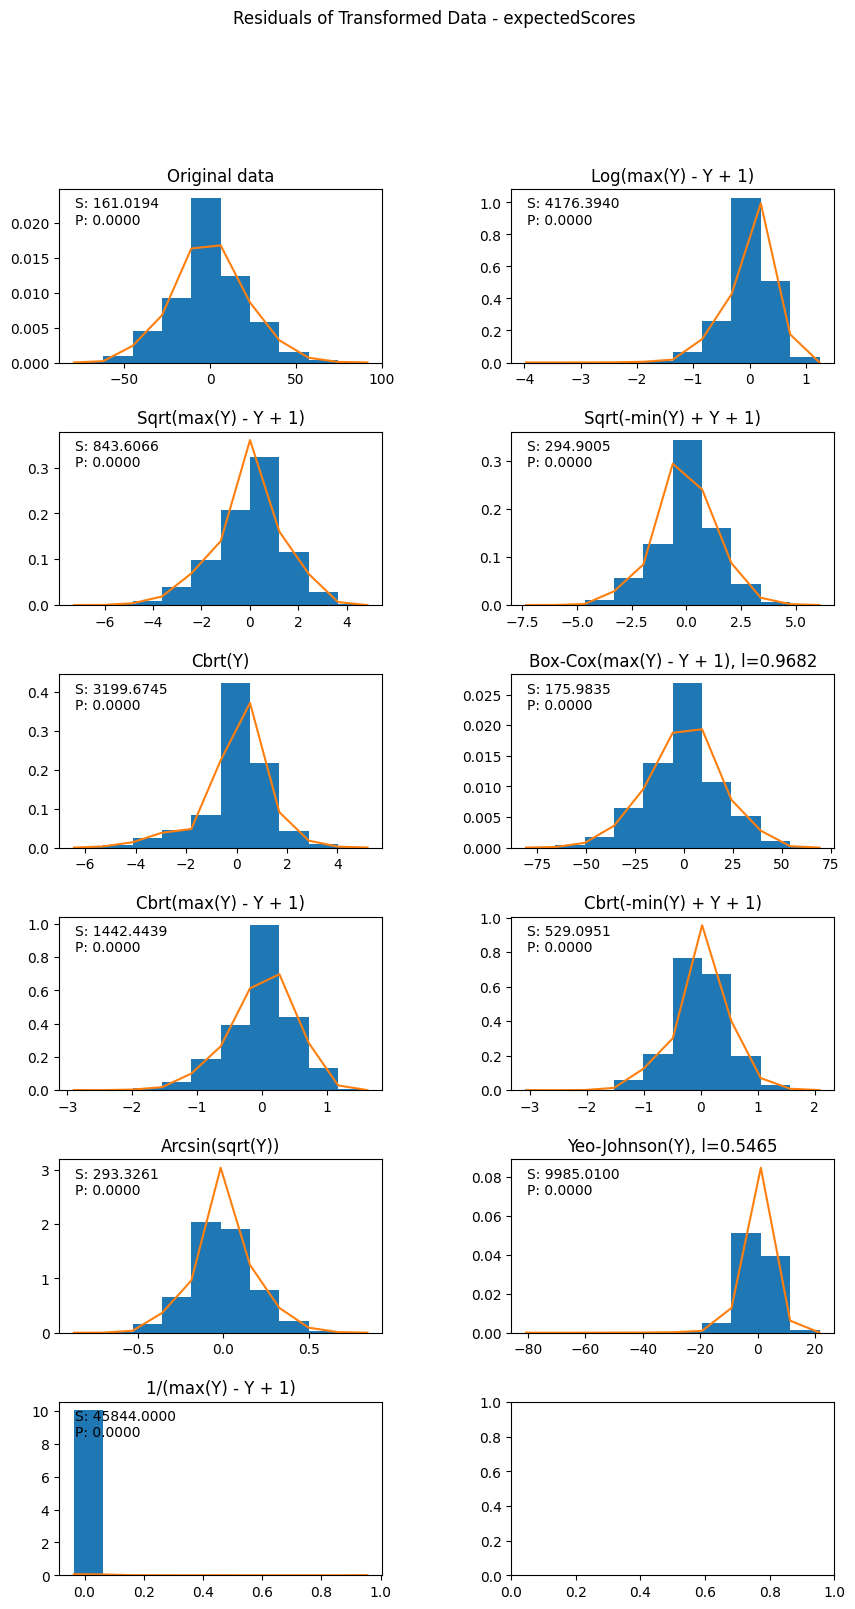

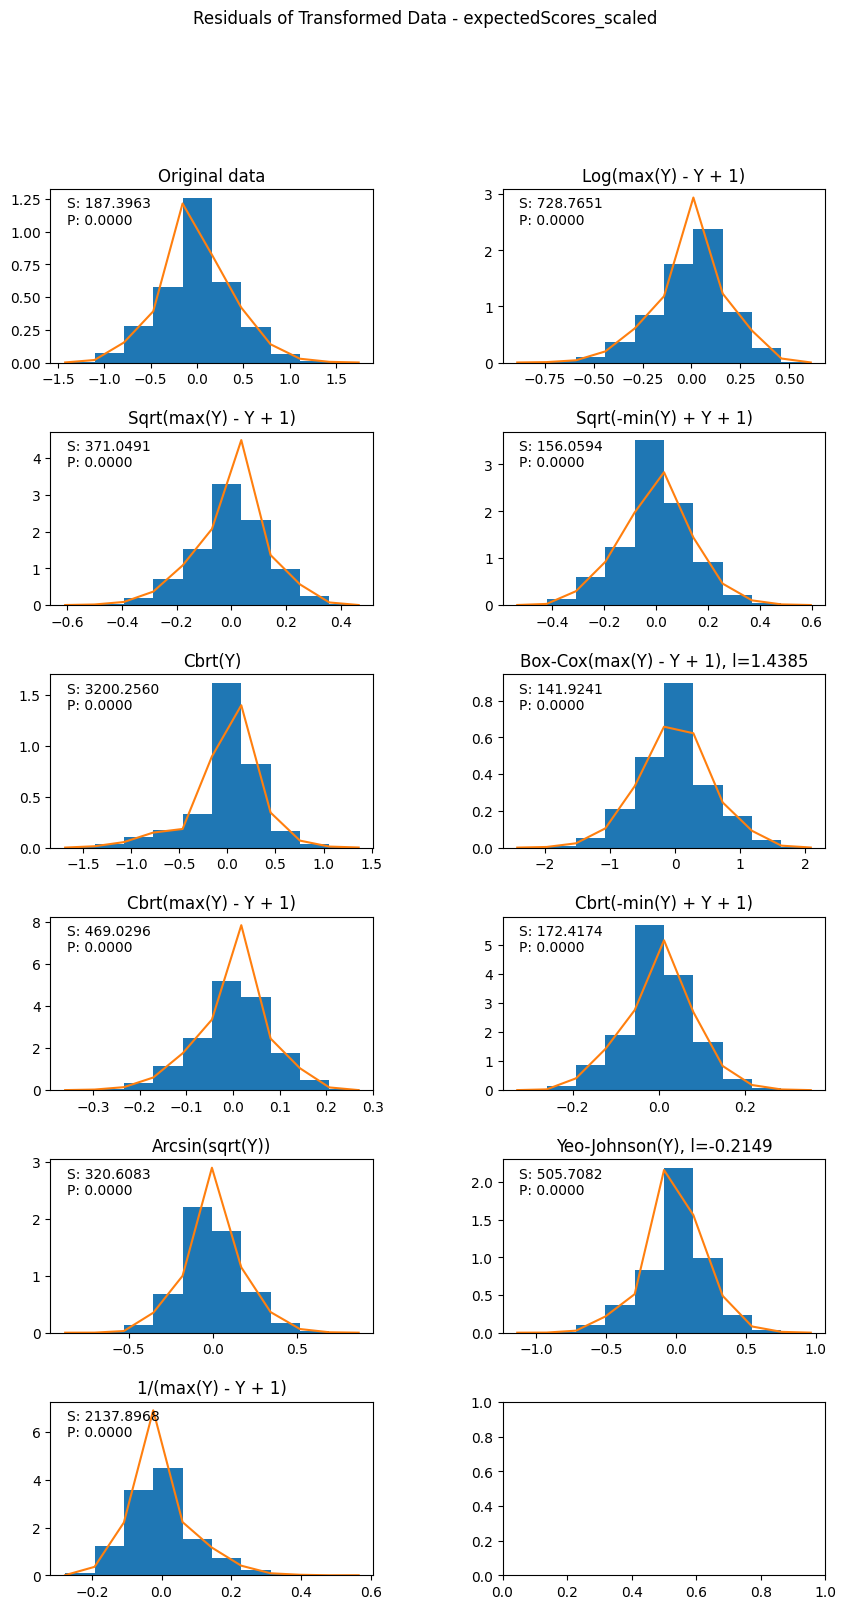

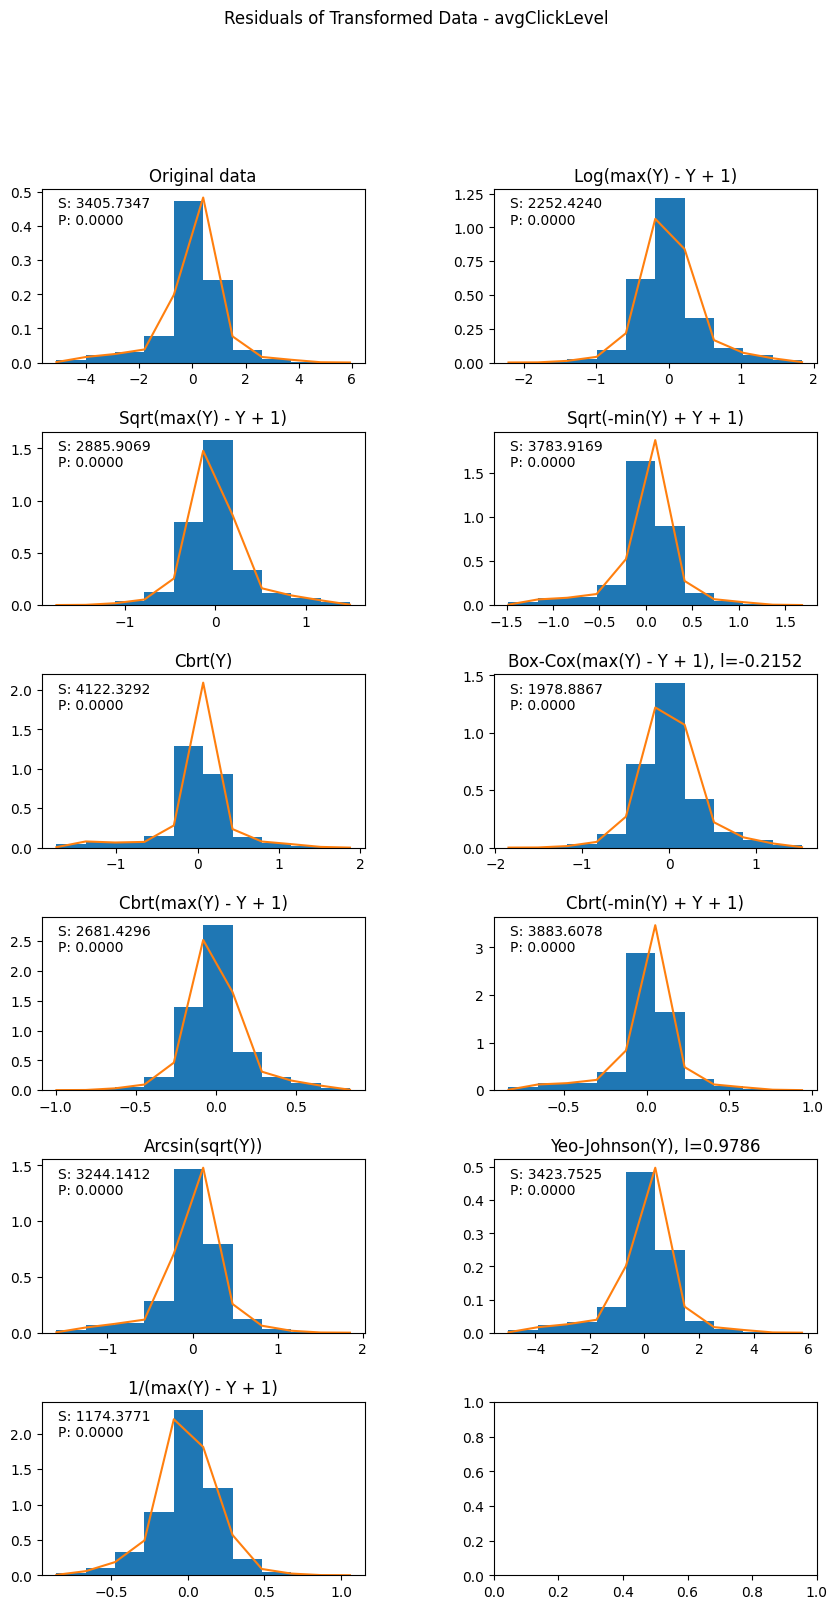

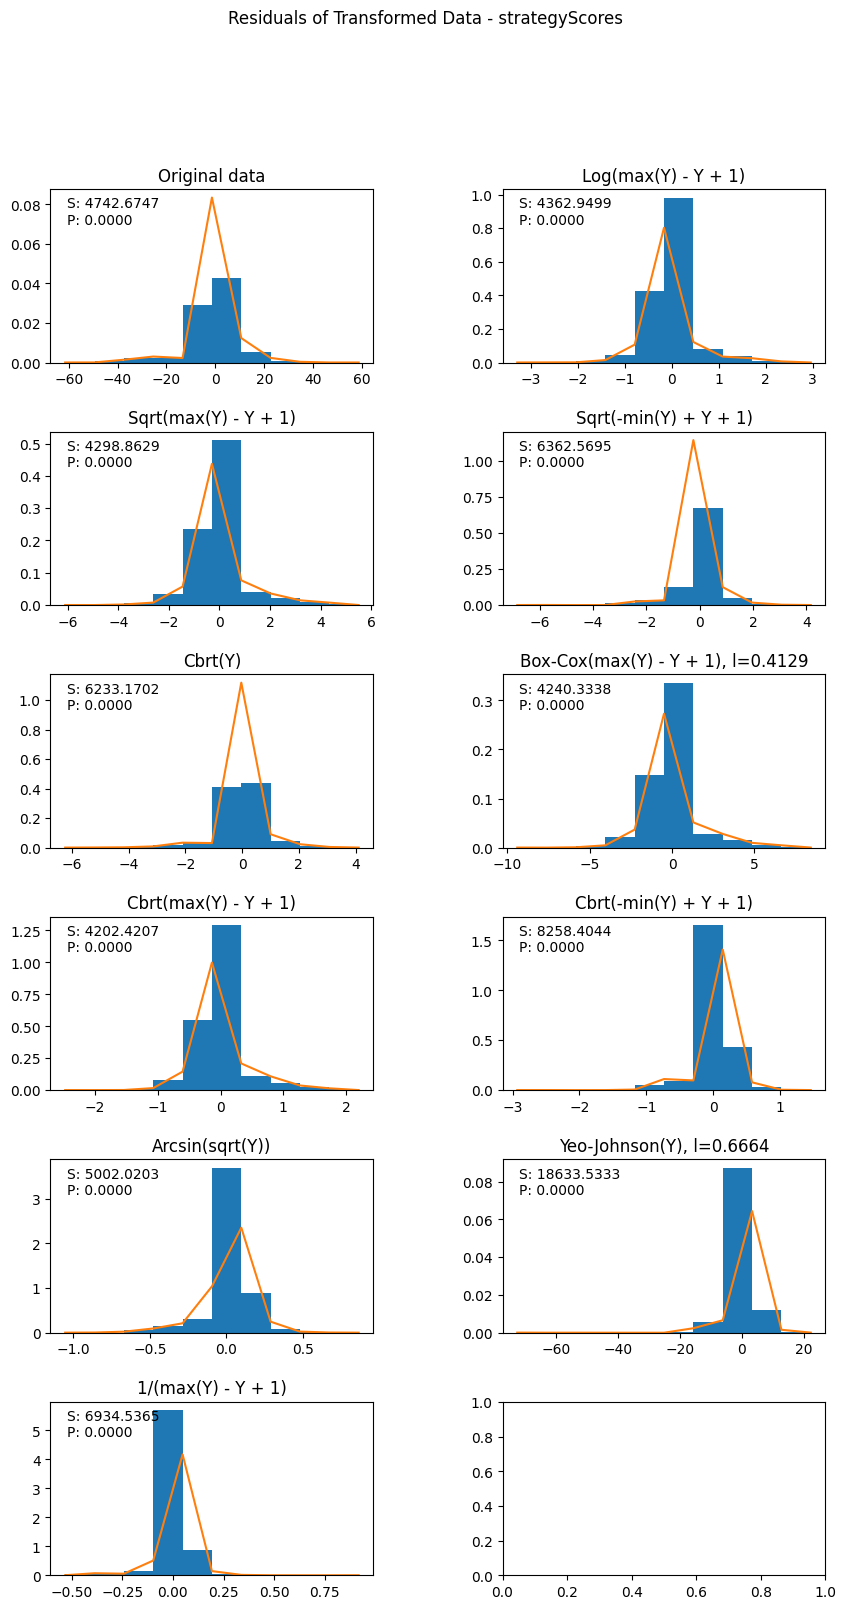

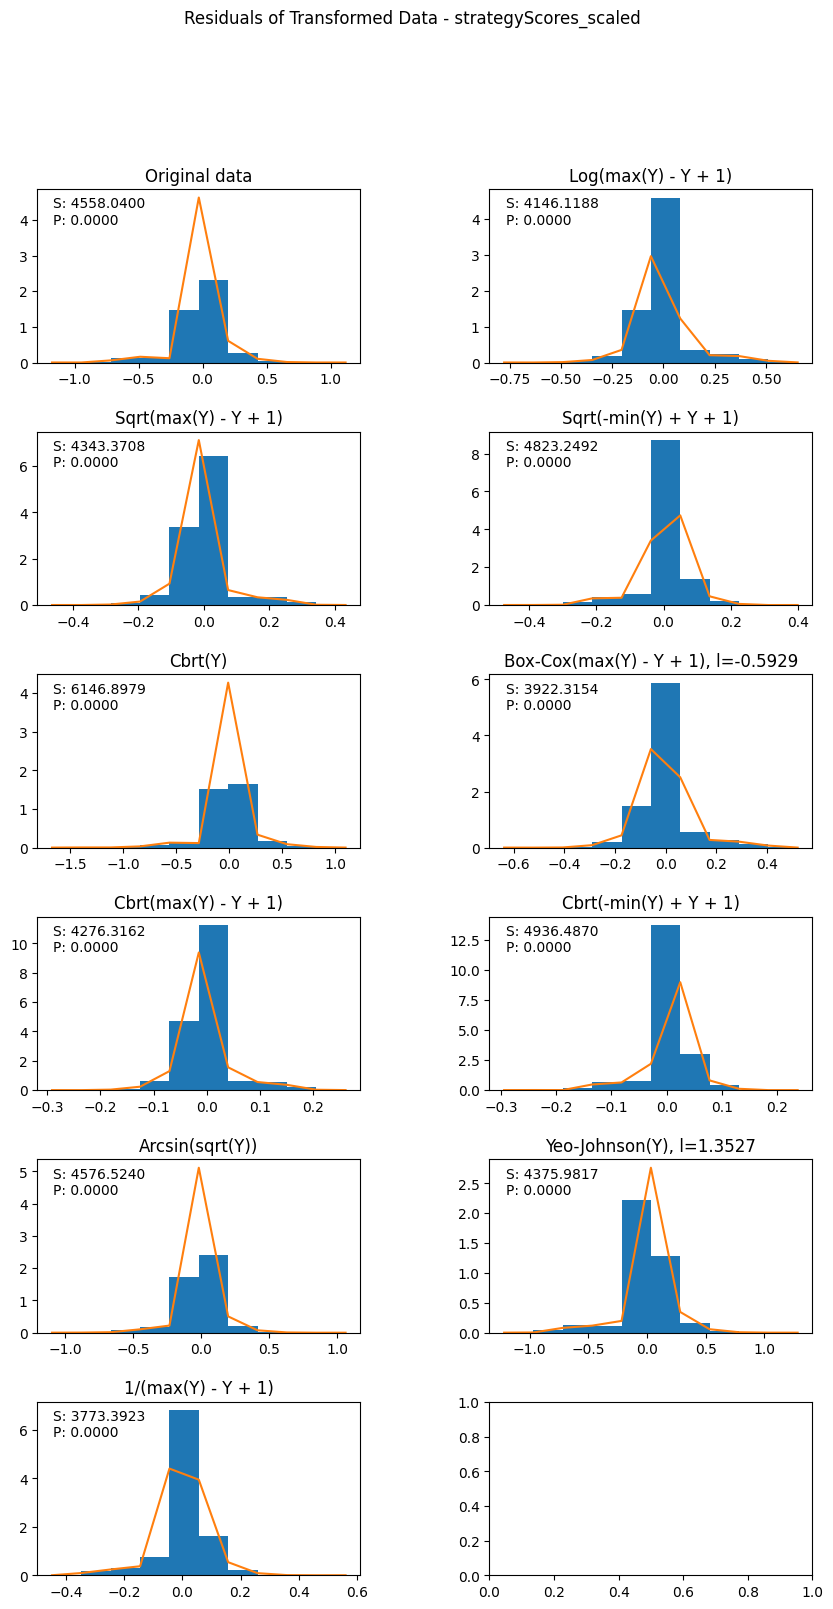

In [546]:
# Plotting residuals for all GLM Models

analysis_cols = {res: [] for res in response_vars}
highest_normality_trans = {res: "" for res in response_vars}

for response_var in response_vars:
    fig, ax = plt.subplots(nrows=math.ceil(len(all_residuals[response_var])/2),ncols=2,figsize=(10, 3 * math.ceil(len(all_residuals[response_var])/2)),squeeze=False)
    plt.suptitle("Residuals of Transformed Data - {}".format(response_var))
    ax = ax.flatten()

    lowest_normality_stat = float("inf")
    for idx, trans in enumerate(all_residuals[response_var]):
        resids = trans[0]
        response_data = trans[1]
        label = trans[2]
        normaltest = trans[3]
        if normaltest.statistic < lowest_normality_stat:
            analysis_cols[response_var] = response_data
            highest_normality_trans[response_var] = label
            lowest_normality_stat = normaltest.statistic
        density = scipy.stats.gaussian_kde(resids)
        n, x, _ = ax[idx].hist(resids, density=True)
        ax[idx].set_title(label)
        ax[idx].plot(x, density(x))
        ax[idx].text(0.05,0.8, "S: {0:0.4f}\nP: {1:0.4f}".format(normaltest.statistic, normaltest.pvalue), transform=ax[idx].transAxes)

    plt.subplots_adjust(
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

In [547]:
# data which is to be used for the remainder of the analysis

# Displaying which of the data has the most normal residuals 
analysis_data = transformed_trials_df.copy()
for response_var in response_vars:
    print("{} - {}".format(response_var, highest_normality_trans[response_var]))
    analysis_data[response_var] = analysis_cols[response_var]
    

expectedScores - Original data
expectedScores_scaled - Box-Cox(max(Y) - Y + 1), l=1.4385
avgClickLevel - 1/(max(Y) - Y + 1)
clicksL1 - Yeo-Johnson(Y), l=-5.1069
clicksL5 - Box-Cox(max(Y) - Y + 1), l=3.7128
strategyScores - Cbrt(max(Y) - Y + 1)
strategyScores_scaled - 1/(max(Y) - Y + 1)


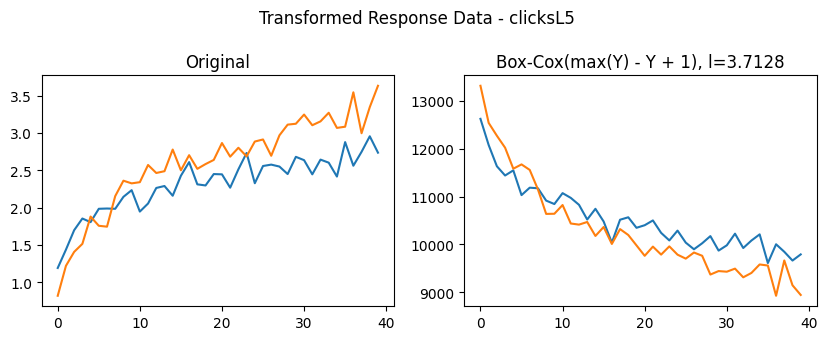

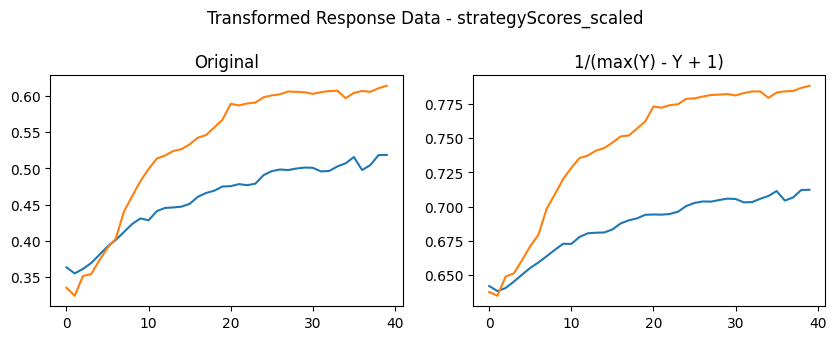

In [548]:
# Visualize transformed data for each response variable

for response_var in response_vars:
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10, 3),squeeze=True)
    plt.suptitle("Transformed Response Data - {}".format(response_var),y=1.1)
    ax = ax.flatten()

    for idx, trans in enumerate([transformed_trials_df, analysis_data]):
        data = trans
        scarce = data.loc[data.condition == 1]
        control = data.loc[data.condition == 0]
        label = "Original" if idx == 0 else highest_normality_trans[response_var]

        scarce_mean = np.array(scarce.groupby('trialNumbers').mean(numeric_only=True)[response_var])
        control_mean = np.array(control.groupby('trialNumbers').mean(numeric_only=True)[response_var])
        ax[idx].plot(list(range(len(scarce_mean))), scarce_mean, label="Scarce")
        ax[idx].plot(list(range(len(control_mean))), control_mean, label="Control")
        ax[idx].set_title(label)

plt.show()

# 1.1.1 - Linear Regression: Finding Best Model of Learning vs. Performance

In [549]:
# If master switch is not turned on, select which data to use for this analysis
data_to_use = "all" # "1", "2", or "all"
if master_switch: data_to_use = data_to_use_master
if data_to_use == "1":
    analysis_data = analysis_data.loc[~analysis_data.replication].reset_index(drop=True)
elif data_to_use == "2":
    analysis_data = analysis_data.loc[analysis_data.replication].reset_index(drop=True)

In [550]:
# Manually set the partition
manually_set_partition = True
manual_partition = 9

### Finding Best Model for Scarce Condition

In [551]:


test_df = analysis_data

mixed = False
    
# For scarce trials
relevant_trials = test_df.loc[test_df.condition == 1].copy()

all_trials_mean_scarce = relevant_trials.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
all_trial_nos_scarce = list(range(1,len(all_trials_mean_scarce)+1))

sig_bic_scores_scarce = []
scarce_plot_data = []
scarce_glm_results = []

# Check all possible data splits for both conditions
for trialNum in range(2,40,1):
    isPerformanceTrial = [int(trial > trialNum) for trial in relevant_trials.trialNumbers]
    relevant_trials['isPerformanceTrial'] = isPerformanceTrial
    
    partition_1_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 0]
    partition_2_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 1]
    partition_1_mean_scores = partition_1_df.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
    partition_2_mean_scores = partition_2_df.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
    
    two_slope_formula = "expectedScores_scaled ~ trialNumbers + trialNumbers:C(isPerformanceTrial) + C(isPerformanceTrial)"
    one_slope_formula = "expectedScores_scaled ~ trialNumbers"
    
    # Fitting a single-slope model and a two-slope model to see which is better
    if mixed:
        glm_1 = smf.mixedlm(formula=two_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
        glm_2 = smf.mixedlm(formula=one_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
    else:
        glm_1 = smf.glm(formula=two_slope_formula, data=relevant_trials)
        glm_2 = smf.glm(formula=one_slope_formula, data=relevant_trials)

    try:
        results_1 = glm_1.fit()
        results_2 = glm_2.fit()
    except:
        continue
        
    bic1 = results_1.bic_llf
    bic2 = results_2.bic_llf
        
    # Saving the slopes and the single intercept of both phases from the two-slope model
    b1 = results_1.params['trialNumbers']
    b2 = results_1.params['trialNumbers'] + results_1.params['trialNumbers:C(isPerformanceTrial)[T.1]']
    i1 = results_1.params['Intercept']
    i2 = results_1.params['Intercept'] + results_1.params['C(isPerformanceTrial)[T.1]']
    
    b3 = results_2.params['trialNumbers']
    i3 = results_2.params['Intercept']
    
    if(bic1 < bic2):
        # Save data about significant partitions, where the bic of the two-slope model is higher than one-slope
        sig_bic_scores_scarce.append((trialNum, bic1))
        
    x1 = all_trial_nos_scarce[0:len(partition_1_mean_scores)]
    x2 = all_trial_nos_scarce[len(partition_1_mean_scores):len(partition_1_mean_scores)+len(partition_2_mean_scores)]
    scarce_plot_data.append((
        trialNum,
        x1,
        x2,
        partition_1_mean_scores,
        partition_2_mean_scores,
        b1,
        b2,
        i1,
        i2,
        b3,
        i3,
        partition_1_df,
        partition_2_df
    ))
    scarce_glm_results.append((trialNum, results_1, results_2))

Partition candidates: 
[9]


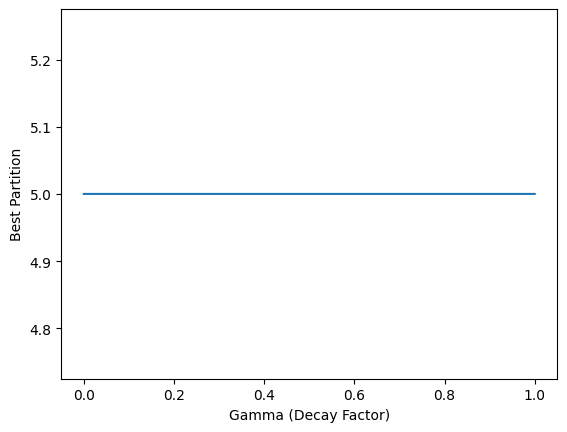

In [552]:
# Finding the best partition of all significant ones 

mis_partition_exists = len(sig_bic_scores_scarce) > 0

if manually_set_partition: mis_partition_exists = True
if use_model_data:
    partition_candidates = [13] # Use partition from human dataset
elif mis_partition_exists:
    sig_bic_scores_scarce = np.array(sig_bic_scores_scarce)

    g_range = np.arange(0, 1, 0.0001)
    best_partitions = []

    for gamma in g_range:
        # Minimum bic
        partition_scores = sig_bic_scores_scarce[:,1]
        best_partition = sig_bic_scores_scarce[np.argmin(partition_scores),0]
        best_partitions.append(best_partition)

    partition_candidates = np.unique(best_partitions)
    if manually_set_partition:
        partition_candidates = [manual_partition]


    print("Partition candidates: ")
    print(partition_candidates)
    plt.plot(g_range, best_partitions)
    plt.xlabel("Gamma (Decay Factor)")
    plt.ylabel("Best Partition")
    plt.show()


In [553]:
# Showing GLM results - scarce

if mis_partition_exists:
    candidate_glm_results_scarce = [data for data in scarce_glm_results if float(data[0]) in partition_candidates]

    for trialNum, results_1, results_2 in candidate_glm_results_scarce:
        print("Trial Num: {}".format(trialNum))
        print("\nTwo-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
              .format(results_1.bic_llf,results_1.bic_deviance, results_1.aic))
        print(results_1.summary())

        print("\nOne-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
              .format(results_2.bic_llf,results_2.bic_deviance, results_2.aic))
        print(results_2.summary())


Trial Num: 9

Two-Slope Model:
BIC LLF: 26071.8099

BIC Deviance: -92772.4330

AIC: 26042.6755

                   Generalized Linear Model Regression Results                   
Dep. Variable:     expectedScores_scaled   No. Observations:                10760
Model:                               GLM   Df Residuals:                    10756
Model Family:                   Gaussian   Df Model:                            3
Link Function:                  identity   Scale:                         0.65841
Method:                             IRLS   Log-Likelihood:                -13017.
Date:                   Thu, 07 Sep 2023   Deviance:                       7081.9
Time:                           16:53:15   Pearson chi2:                 7.08e+03
No. Iterations:                        3   Pseudo R-squ. (CS):            0.02877
Covariance Type:               nonrobust                                         
                                              coef    std err          z      P>|z| 

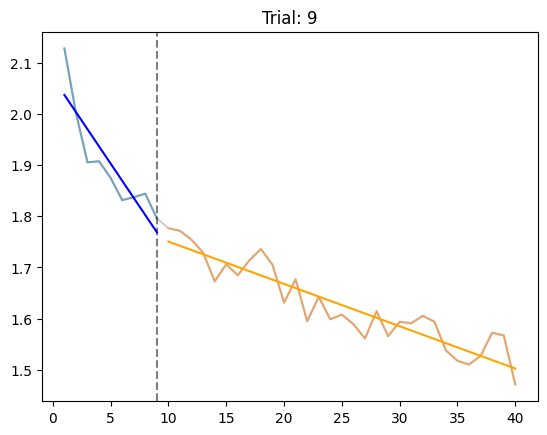

In [554]:
# Plotting candidate partitions - scarce
if mis_partition_exists:
    candidate_plot_data_scarce = [data for data in scarce_plot_data if float(data[0]) in partition_candidates]
    #significant_plot_data_scarce = [data for data in scarce_plot_data if float(data[0]) in sig_bic_scores_scarce[:,0]]

    which_plot = "candidates" #all, significant, candidates

    if which_plot == "candidates":
        plot_data = candidate_plot_data_scarce
    elif which_plot == "significant":
        plot_data = significant_plot_data_scarce
    else:
        plot_data = scarce_plot_data

    plot_single_slope = False
    plot_two_slope = True
    scatter = False
    error = False

    for trialNum, x1, x2, y1, y2, b1, b2, i1, i2,b3, i3, df_1, df_2 in plot_data:
        plt.figure()
        # Expected Score curves
        plt.plot(all_trial_nos_scarce, all_trials_mean_scarce, alpha=0.2, color='k')
        plt.plot(x1, y1, alpha=0.5)
        plt.plot(x2, y2, alpha=0.5)

        # Scatter points
        if scatter:
            plt.scatter(df_1['trialNumbers'], df_1['expectedScores'], color='b', marker='o', alpha=0.1,s=0.8)
            plt.scatter(df_2['trialNumbers'], df_2['expectedScores'], color='orange', marker='o', alpha=0.1,s=0.8)

        # Partition line
        plt.axvline(trialNum, linestyle="--", color='k',alpha=0.5)

        # Slope lines of one-slope model
        if plot_single_slope:
            x3 = np.concatenate([x1,x2],axis=0)
            plt.plot(x3, np.array(x3) * b3 + i3, color='g', alpha=0.5)

        if plot_two_slope:
            # Slope lines of two-slope model
            plt.plot(x1, np.array(x1) * b1 + i1, color='b')
            plt.plot(x2, np.array(x2) * b2 + i2, color='orange')

        if error:
            plt.fill_between(x1, scarce_data_all + scarce_data_all_sd, scarce_data_all - scarce_data_all_sd, alpha=0.1)

        plt.title("Trial: {}".format(trialNum))

    plt.show()

In [555]:
if mis_partition_exists:
    scarce_partition = partition_candidates[0] # Somehow choose based on possible candidates

    # Separating into learning and performance phase
    scarce_learning_data = analysis_data.loc[(analysis_data.condition == 1) & (analysis_data.trialNumbers <= scarce_partition)]
    scarce_performance_data = analysis_data.loc[(analysis_data.condition ==1) & (analysis_data.trialNumbers > scarce_partition)]

    # Without transformation
    scarce_learning_data_orig = filtered_data.loc[(filtered_data.condition == 1) & (filtered_data.trialNumbers <= scarce_partition)]
    scarce_performance_data_orig = filtered_data.loc[(filtered_data.condition ==1) & (filtered_data.trialNumbers > scarce_partition)]

    # Store the slope, intercept, etc. of the best partition
    scarce_partition_plot_data = [data for data in candidate_plot_data_scarce if data[0] == scarce_partition][0]

### Finding Best Model for Control Condition

In [556]:
# GLM 3 - finding cut off point of learning phase

test_df = analysis_data

mixed = False
    
# For control trials
relevant_trials = test_df.loc[test_df.condition == 0].copy()

all_trials_mean_control = relevant_trials.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
all_trial_nos_control = list(range(1,len(all_trials_mean_control)+1))

sig_bic_scores_control = []
control_plot_data = []
control_glm_results = []
for trialNum in range(2,40,1):
    isPerformanceTrial = [int(trial > trialNum) for trial in relevant_trials.trialNumbers]
    relevant_trials['isPerformanceTrial'] = isPerformanceTrial
    
    partition_1_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 0]
    partition_2_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 1]
    partition_1_mean_scores = partition_1_df.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
    partition_2_mean_scores = partition_2_df.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
    
#     two_slope_formula = "expectedScores ~ trialNumbers + C(condition) + C(isPerformanceTrial) + trialNumbers:C(isPerformanceTrial)"
#     one_slope_formula = "expectedScores ~ trialNumbers + C(condition)"
    two_slope_formula = "expectedScores_scaled ~ trialNumbers + trialNumbers:C(isPerformanceTrial) + C(isPerformanceTrial)"
    one_slope_formula = "expectedScores_scaled ~ trialNumbers"
    
    # Fitting a single-slope model and a two-slope model to see which is better
    if mixed:
        glm_1 = smf.mixedlm(formula=two_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
        glm_2 = smf.mixedlm(formula=one_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
    else:
        glm_1 = smf.glm(formula=two_slope_formula, data=relevant_trials)
        glm_2 = smf.glm(formula=one_slope_formula, data=relevant_trials)

    try:
        results_1 = glm_1.fit()
        results_2 = glm_2.fit()
    except:
        continue
        
    bic1 = results_1.bic_llf
    bic2 = results_2.bic_llf
    
    # print(results_1.summary())
    
    # Saving the slopes and the single intercept of both phases from the two-slope model
    b1 = results_1.params['trialNumbers']
    b2 = results_1.params['trialNumbers'] + results_1.params['trialNumbers:C(isPerformanceTrial)[T.1]']
    i1 = results_1.params['Intercept']
    i2 = results_1.params['Intercept'] + results_1.params['C(isPerformanceTrial)[T.1]']
    
    b3 = results_2.params['trialNumbers']
    i3 = results_2.params['Intercept']
    if(bic1 < bic2):
        # Save data about significant partitions, where the bic of the two-slope model is higher than one-slope
        sig_bic_scores_control.append((trialNum, bic1))
        
    x1 = all_trial_nos_control[0:len(partition_1_mean_scores)]
    x2 = all_trial_nos_control[len(partition_1_mean_scores):len(partition_1_mean_scores)+len(partition_2_mean_scores)]
    control_plot_data.append((
        trialNum,
        x1,
        x2,
        partition_1_mean_scores,
        partition_2_mean_scores,
        b1,
        b2,
        i1,
        i2,
        b3, 
        i3,
        partition_1_df,
        partition_2_df
    ))
    control_glm_results.append((trialNum, results_1, results_2))

In [557]:
sig_bic_scores_control

[(2, 23771.973314223542),
 (3, 23763.850176273292),
 (4, 23755.613294701056),
 (5, 23745.800867806465),
 (6, 23740.382386937465),
 (7, 23738.10561885603),
 (8, 23734.621143524804),
 (9, 23733.476459337584),
 (10, 23733.439715827502),
 (11, 23733.902129680937),
 (12, 23733.917217720482),
 (13, 23733.911867630697),
 (14, 23735.274280307294),
 (15, 23737.68303330022),
 (16, 23738.67486573787),
 (17, 23741.781879583014),
 (18, 23743.676970527235),
 (19, 23746.015121815726),
 (20, 23744.50133309201),
 (21, 23751.76025157445),
 (22, 23758.31506054313),
 (23, 23763.3210685261),
 (24, 23765.205520823496),
 (25, 23770.509154446758),
 (26, 23772.184592359365),
 (27, 23773.146330447944),
 (28, 23778.957983042877),
 (29, 23782.629560679932),
 (30, 23789.313294430864),
 (31, 23793.526090335767),
 (32, 23797.05564646026),
 (33, 23796.96186714467),
 (34, 23800.88595754797)]

Partition candidates: 
[9]


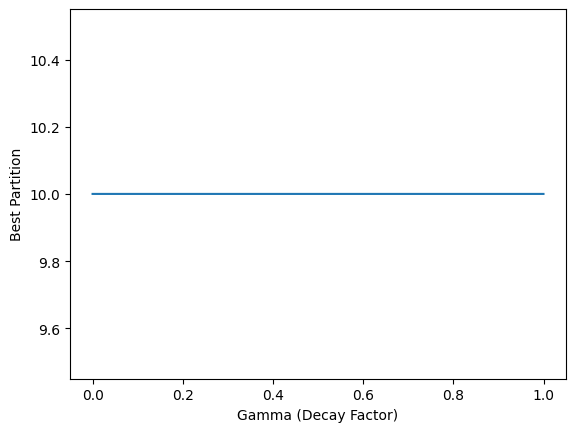

In [558]:
# Finding the best partition of all significant ones 

if use_model_data:
    partition_candidates = [9] # Use partition from human data
else:
    sig_bic_scores_control = np.array(sig_bic_scores_control)

    g_range = np.arange(0, 1, 0.0001)
    best_partitions = []

    for gamma in g_range:
        # Minimum bic
        partition_scores = sig_bic_scores_control[:,1]
        best_partition = sig_bic_scores_control[np.argmin(partition_scores),0]
        best_partitions.append(best_partition)

    partition_candidates = np.unique(best_partitions)
    if manually_set_partition:
        partition_candidates = [manual_partition]
    print("Partition candidates: ")
    print(partition_candidates)
    plt.plot(g_range, best_partitions)
    plt.xlabel("Gamma (Decay Factor)")
    plt.ylabel("Best Partition")
    plt.show()


In [559]:
# Showing GLM results - control
candidate_glm_results_control = [data for data in control_glm_results if float(data[0]) in partition_candidates]

for trialNum, results_1, results_2 in candidate_glm_results_control:
    print("Trial Num: {}".format(trialNum))
    print("\nTwo-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_1.bic_llf,results_1.bic_deviance, results_1.aic))
    print(results_1.summary())
    
    print("\nOne-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_2.bic_llf,results_2.bic_deviance, results_2.aic))
    print(results_2.summary())


Trial Num: 9

Two-Slope Model:
BIC LLF: 23733.4765

BIC Deviance: -86689.9952

AIC: 23704.6032

                   Generalized Linear Model Regression Results                   
Dep. Variable:     expectedScores_scaled   No. Observations:                10080
Model:                               GLM   Df Residuals:                    10076
Model Family:                   Gaussian   Df Model:                            3
Link Function:                  identity   Scale:                         0.61470
Method:                             IRLS   Log-Likelihood:                -11848.
Date:                   Thu, 07 Sep 2023   Deviance:                       6193.7
Time:                           16:53:23   Pearson chi2:                 6.19e+03
No. Iterations:                        3   Pseudo R-squ. (CS):            0.05067
Covariance Type:               nonrobust                                         
                                              coef    std err          z      P>|z| 

In [560]:
# Plotting candidate partitions - control
candidate_plot_data_control = [data for data in control_plot_data if float(data[0]) in partition_candidates]
#significant_plot_data_control = [data for data in control_plot_data if float(data[0]) in sig_bic_scores_control[:,0]]

which_plot = "candidates" #all, significant, candidates

if which_plot == "candidates":
    plot_data = candidate_plot_data_control
elif which_plot == "significant":
    plot_data = significant_plot_data_control
else:
    plot_data = control_plot_data
    
plot_single_slope = False
plot_two_slope = True
scatter = False

for trialNum, x1, x2, y1, y2, b1, b2, i1, i2,b3, i3, df_1, df_2 in plot_data:
    plt.figure()
    # Expected Score curves
    plt.plot(all_trial_nos_control, all_trials_mean_control, alpha=0.2, color='k')
    plt.plot(x1, y1, alpha=0.5)
    plt.plot(x2, y2, alpha=0.5)

    # Partition line
    plt.axvline(trialNum, linestyle="--", color='k',alpha=0.5)
    
    # Scatter points
    if scatter:
        plt.scatter(df_1['trialNumbers'], df_1['expectedScores'], color='b', marker='o', alpha=0.1,s=0.8)
        plt.scatter(df_2['trialNumbers'], df_2['expectedScores'], color='orange', marker='o', alpha=0.1,s=0.8)

    # Slope lines of one-slope model
    if plot_single_slope:
        x3 = np.concatenate([x1,x2],axis=0)
        plt.plot(x3, np.array(x3) * b3 + i3, color='g', alpha=0.5)
    
    if plot_two_slope:
        # Slope lines of two-slope model
        plt.plot(x1, np.array(x1) * b1 + i1, color='b')
        plt.plot(x2, np.array(x2) * b2 + i2, color='orange')
    
    plt.title("Trial: {}".format(trialNum))
    
plt.show()

In [561]:
control_partition = partition_candidates[0] # Somehow choose based on possible candidates

# Separating into learning and performance phase
control_learning_data = analysis_data.loc[(analysis_data.condition == 0) & (analysis_data.trialNumbers <= control_partition)]
control_performance_data = analysis_data.loc[(analysis_data.condition == 0) & (analysis_data.trialNumbers > control_partition)]

# Without transformation
control_learning_data_orig = filtered_data.loc[(filtered_data.condition == 0) & (filtered_data.trialNumbers <= control_partition)]
control_performance_data_orig = filtered_data.loc[(filtered_data.condition == 0) & (filtered_data.trialNumbers > control_partition)]

# Store the slope, intercept, etc. of the best partition
control_partition_plot_data = [data for data in candidate_plot_data_control if data[0] == control_partition][0]

if not mis_partition_exists:
    scarce_partition = control_partition # Somehow choose based on possible candidates

    # Separating into learning and performance phase
    scarce_learning_data = analysis_data.loc[(analysis_data.condition == 1) & (analysis_data.trialNumbers <= scarce_partition)]
    scarce_performance_data = analysis_data.loc[(analysis_data.condition ==1) & (analysis_data.trialNumbers > scarce_partition)]

    # Without transformation
    scarce_learning_data_orig = filtered_data.loc[(filtered_data.condition == 1) & (filtered_data.trialNumbers <= scarce_partition)]
    scarce_performance_data_orig = filtered_data.loc[(filtered_data.condition ==1) & (filtered_data.trialNumbers > scarce_partition)]

    # Store the slope, intercept, etc. of the best partition
    scarce_partition_plot_data = [data for data in scarce_plot_data if data[0] == scarce_partition][0]

# 1.1 - Linear Regression: Expected Score vs. Trial Number x Condition

In [562]:
# Select the response variable for this analysis

response_var = "expectedScores_scaled"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                  Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   expectedScores_scaled
No. Observations:   4689      Method:               REML                 
No. Groups:         521       Scale:                0.2854               
Min. group size:    9         Log-Likelihood:       -4422.9477           
Max. group size:    9         Converged:            Yes                  
Mean group size:    9.0                                                  
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       2.001    0.034 58.982 0.000  1.934  2.067
C(condition)[T.1]              -0.098    0.047 -2.071 0.038 -0.190 -0.005
trialNumbers                   -0.050    0.006 -8.658 0.000 -0.061 -0.039
trialNumbers:C(condition)[T.1]  0.016    0.008  2.035 0.

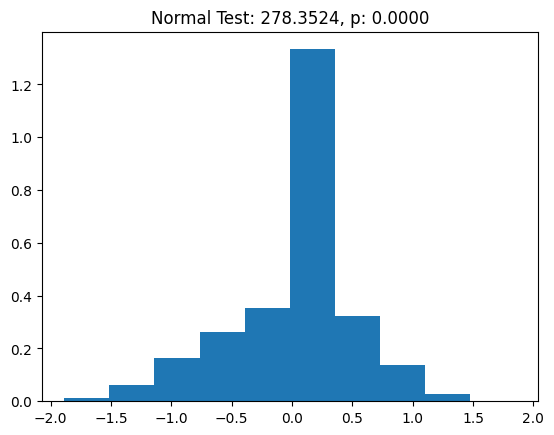

In [563]:
# Learning Phase

use_orig = False

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)

formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)
re_formula = "trialNumbers"

standardize_cols = ["trialNumbers"]
for col in standardize_cols:
    learning_df[col] = (learning_df[col] - learning_df[col].mean())#}/learning_df[col].std()
    
    
mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, re_formula=re_formula, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

In [564]:
# Plotting the data of both learning phases

x1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Learning Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()


plt.show()



                 Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  expectedScores_scaled
No. Observations:    16151    Method:              REML                 
No. Groups:          521      Scale:               0.1406               
Min. group size:     31       Log-Likelihood:      -8062.5525           
Max. group size:     31       Converged:           Yes                  
Mean group size:     31.0                                               
------------------------------------------------------------------------
                               Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.619    0.027 22.519 0.000  0.565  0.673
C(condition)[T.1]              0.003    0.038  0.083 0.934 -0.072  0.078
trialNumbers                   0.006    0.000 11.842 0.000  0.005  0.007
trialNumbers:C(condition)[T.1] 0.000    0.001  0.212 0.832 -0.001  0.

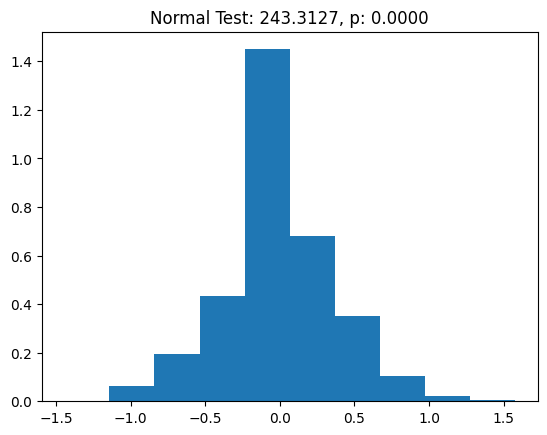

In [565]:
# Performance Phase

use_orig = True

if use_orig:
    performance_df = pd.concat([scarce_performance_data_orig, control_performance_data_orig]).reset_index(drop=True)
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)
    
formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)

use_random_slope = False
re_formula = "trialNumbers" if use_random_slope else ""

standardize_cols = ["trialNumbers"]
for col in standardize_cols:
    performance_df[col] = (performance_df[col] - performance_df[col].mean())#}/learning_df[col].std()

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=performance_df, re_formula=re_formula, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

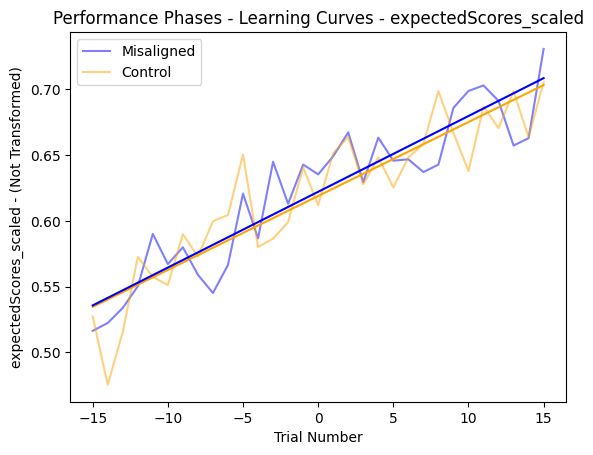

In [566]:
# Plotting the data of both performance phases together

x1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']
        

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Performance Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()

plt.show()

# 1.2 - Independent Samples T-test

In [567]:
# Select the response variable for this analysis

response_var = "expectedScores_scaled"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

In [568]:
use_transformed = True

if use_transformed:
    # Using the transformed data divided into phases
    control_averages = control_performance_data.groupby('workerId').mean(numeric_only=True)
    scarce_averages = scarce_performance_data.groupby('workerId').mean(numeric_only=True)
else:
    # Using the original data divided into phases
    control_averages = control_performance_data_orig.groupby('workerId').mean(numeric_only=True)
    scarce_averages = scarce_performance_data_orig.groupby('workerId').mean(numeric_only=True)
    

In [569]:
plt.figure()
plt.plot(np.sort(np.unique(control_performance_data.trialNumbers)), control_performance_data.groupby('trialNumbers').mean(numeric_only=True)[response_var], color='orange')
plt.plot(np.sort(np.unique(scarce_performance_data.trialNumbers)), scarce_performance_data.groupby('trialNumbers').mean(numeric_only=True)[response_var], color='b')
plt.show()

1.6278108089693974 0.040552670301726865
1.626634997028902 0.03736978301255163


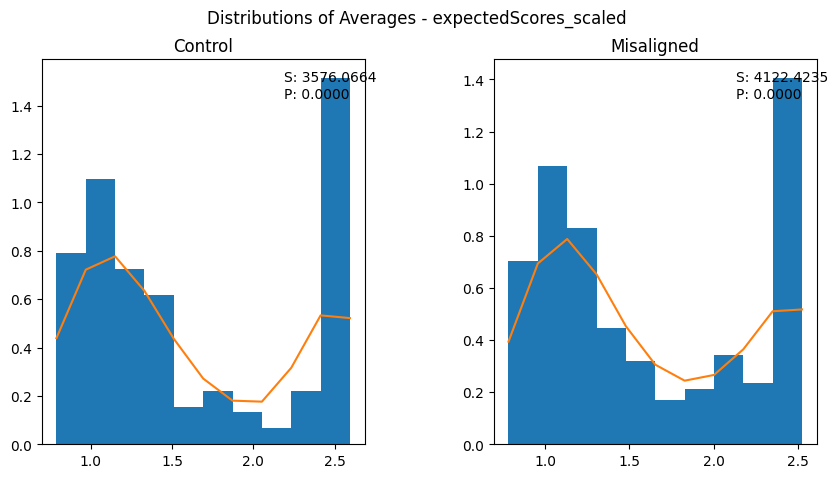

In [570]:

# Plotting normality for both groups

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10, 5),squeeze=False)
plt.suptitle("Distributions of Averages - {}".format(response_var))
ax = ax.flatten()

for idx, group in enumerate([(control_averages, "Control"), (scarce_averages, "Misaligned")]):
    data = group[0][response_var]
    label = group[1]
    print(data.mean(), data.std()/np.sqrt(len(data)))
    normaltest = scipy.stats.normaltest(data)
    density = scipy.stats.gaussian_kde(data)
    n, x, _ = ax[idx].hist(data, density=True)
    ax[idx].set_title(label)
    ax[idx].plot(x, density(x))
    ax[idx].text(0.75,0.9, "S: {0:0.4f}\nP: {1:0.4f}".format(normaltest.statistic, normaltest.pvalue), transform=ax[idx].transAxes)

plt.subplots_adjust(
                wspace=0.4, 
                hspace=0.4)
plt.show()

In [571]:
# Perform independent T-test if data is normal


two = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='two-sided')
less = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='less')
greater = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='greater')

print("Response Variable: {}".format(response_var))
print("Two-Sided:")
print("\tStatistic:| {0:0.3f}\n\tP-value: {1}".format(two.statistic, two.pvalue))
print("Scarce < Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(less.statistic, less.pvalue))
print("Scarce > Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(greater.statistic, greater.pvalue))

Response Variable: expectedScores_scaled
Two-Sided:
	Statistic:| -0.021
	P-value: 0.9829696890210718
Scarce < Control:
	Statistic: -0.021
	P-value: 0.4914848445105359
Scarce > Control:
	Statistic: -0.021
	P-value: 0.5085151554894641


In [572]:
# Perform Mann-Whitney U test if data is not normal

two = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='two-sided')
less = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='less')
greater = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='greater')

print("Two-Sided:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(two.statistic, two.pvalue))
print("Misaligned < Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(less.statistic, less.pvalue))
print("Misaligned > Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(greater.statistic, greater.pvalue))

Two-Sided:
	Statistic: 32980.000
	P-value: 0.5944786828964559
Misaligned < Control:
	Statistic: 32980.000
	P-value: 0.29723934144822795
Misaligned > Control:
	Statistic: 32980.000
	P-value: 0.7029624007585713


# 1.3 - Independent Samples T-test of First Trial Scores

In [573]:
# Select the response variable for this analysis

response_var = "expectedScores_scaled"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

In [574]:
use_transformed = True

if use_transformed:
    # Using the transformed data divided into phases
    control_averages = control_learning_data.loc[control_learning_data.trialNumbers == 1]
    scarce_averages = scarce_learning_data.loc[scarce_learning_data.trialNumbers == 1]
else:
    # Using the original data divided into phases
    control_averages = control_learning_data_orig.loc[control_learning_data_orig.trialNumbers == 1]
    scarce_averages = scarce_learning_data_orig.loc[scarce_learning_data_orig.trialNumbers == 1]
    

2.251768501224837 0.03704272582099018
2.1275586828595707 0.04218166474654065


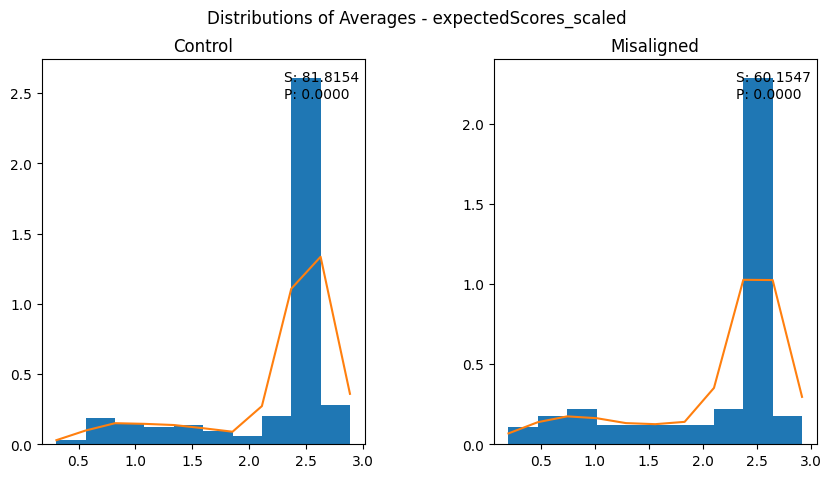

In [575]:

# Plotting normality for both groups

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10, 5),squeeze=False)
plt.suptitle("Distributions of Averages - {}".format(response_var))
ax = ax.flatten()

for idx, group in enumerate([(control_averages, "Control"), (scarce_averages, "Misaligned")]):
    data = group[0][response_var]
    label = group[1]
    print(data.mean(), data.std()/np.sqrt(len(data)))
    normaltest = scipy.stats.normaltest(data)
    density = scipy.stats.gaussian_kde(data)
    n, x, _ = ax[idx].hist(data, density=True)
    ax[idx].set_title(label)
    ax[idx].plot(x, density(x))
    ax[idx].text(0.75,0.9, "S: {0:0.4f}\nP: {1:0.4f}".format(normaltest.statistic, normaltest.pvalue), transform=ax[idx].transAxes)

plt.subplots_adjust(
                wspace=0.4, 
                hspace=0.4)
plt.show()

In [576]:
# Perform independent T-test if data is normal


two = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='two-sided')
less = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='less')
greater = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='greater')

print("Response Variable: {}".format(response_var))
print("Two-Sided:")
print("\tStatistic:| {0:0.3f}\n\tP-value: {1}".format(two.statistic, two.pvalue))
print("Scarce < Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(less.statistic, less.pvalue))
print("Scarce > Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(greater.statistic, greater.pvalue))

Response Variable: expectedScores_scaled
Two-Sided:
	Statistic:| -2.201
	P-value: 0.02817832862287079
Scarce < Control:
	Statistic: -2.201
	P-value: 0.014089164311435394
Scarce > Control:
	Statistic: -2.201
	P-value: 0.9859108356885646


In [577]:
# Perform Mann-Whitney U test if data is not normal

two = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='two-sided')
less = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='less')
greater = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='greater')

print("Two-Sided:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(two.statistic, two.pvalue))
print("Misaligned < Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(less.statistic, less.pvalue))
print("Misaligned > Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(greater.statistic, greater.pvalue))

Two-Sided:
	Statistic: 26920.000
	P-value: 3.2941818826205206e-05
Misaligned < Control:
	Statistic: 26920.000
	P-value: 1.6470909413102603e-05
Misaligned > Control:
	Statistic: 26920.000
	P-value: 0.9999835719022862


# 2.1 - Linear Regression: AvgClickDepth vs. Trial Number x Condition

In [578]:
# Select the response variable for this analysis

response_var = "avgClickLevel"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

                  Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     avgClickLevel
No. Observations:       4527        Method:                 REML         
No. Groups:             503         Scale:                  1.2918       
Min. group size:        9           Log-Likelihood:         -7901.6671   
Max. group size:        9           Converged:              Yes          
Mean group size:        9.0                                              
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       2.282    0.103 22.231 0.000  2.081  2.484
C(condition)[T.1]               0.213    0.145  1.466 0.143 -0.072  0.498
trialNumbers                    0.118    0.013  8.801 0.000  0.092  0.145
trialNumbers:C(condition)[T.1] -0.058    0.019 -3.068 0.

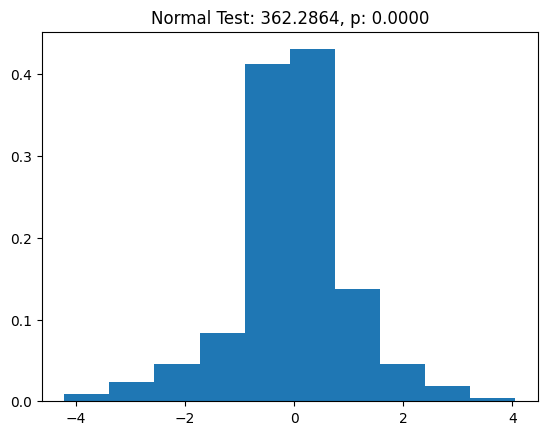

In [579]:
# Learning Phase

use_orig = True

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)

# Filter out participants whose click strategies are not valid
learning_df = learning_df.loc[learning_df.clickStratsValid]

standardize_cols = ["trialNumbers"]
for col in standardize_cols:
    learning_df[col] = (learning_df[col] - learning_df[col].mean()) #/ learning_df[col].std()

formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)
re_formula = "trialNumbers"

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, re_formula=re_formula, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

In [580]:
# Plotting the data of both learning phases

x1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Learning Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()


plt.show()



/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                  Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     avgClickLevel
No. Observations:       15593       Method:                 REML         
No. Groups:             503         Scale:                  0.0288       
Min. group size:        31          Log-Likelihood:         3806.1343    
Max. group size:        31          Converged:              Yes          
Mean group size:        31.0                                             
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.626    0.020 30.712 0.000  0.586  0.666
C(condition)[T.1]              -0.013    0.029 -0.435 0.664 -0.069  0.044
trialNumbers                    0.004    0.001  7.264 0.000  0.003  0.006
trialNumbers:C(condition)[T.1]  0.000    0.001  0.466 0.

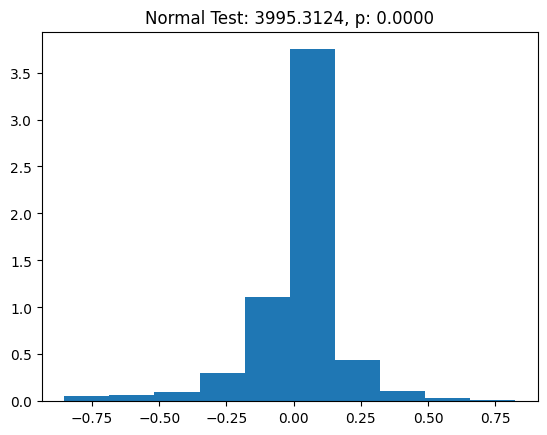

In [581]:
# Performance Phase

use_orig = False

if use_orig:
    performance_df = pd.concat([scarce_performance_data_orig, control_performance_data_orig]).reset_index(drop=True)
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)

standardize_cols = ["trialNumbers"]
for col in standardize_cols:
    performance_df[col] = (performance_df[col] - performance_df[col].mean())#}/learning_df[col].std()

# Filter out participants whose click strategies are not valid
performance_df = performance_df.loc[performance_df.clickStratsValid]

formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)
re_formula = "trialNumbers"

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=performance_df, re_formula=re_formula, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

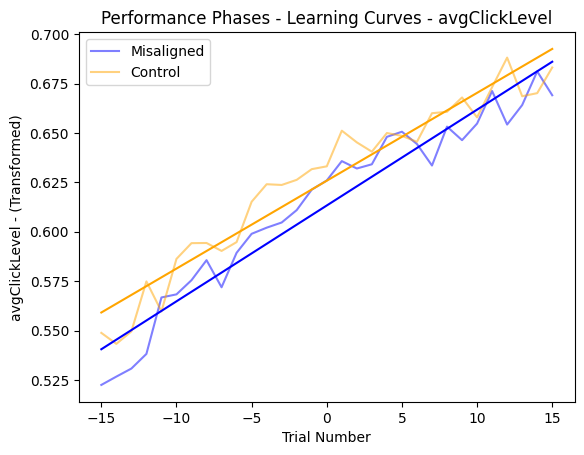

In [582]:
# Plotting the data of both performance phases together

x1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']
        

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Performance Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()

plt.show()

# 2.2 - Linear Regression: ClicksL5 vs. Trial Number x Condition

In [583]:
# Select the response variable for this analysis

response_var = "clicksL5"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

                        Mixed Linear Model Regression Results
Model:                     MixedLM          Dependent Variable:          clicksL5    
No. Observations:          4527             Method:                      REML        
No. Groups:                503              Scale:                       6701123.5332
Min. group size:           9                Log-Likelihood:              -42822.4185 
Max. group size:           9                Converged:                   Yes         
Mean group size:           9.0                                                       
-------------------------------------------------------------------------------------
                                  Coef.     Std.Err.   z    P>|z|   [0.025    0.975] 
-------------------------------------------------------------------------------------
Intercept                         11859.434  209.607 56.579 0.000 11448.612 12270.256
C(condition)[T.1]                  -278.278  296.724 -0.938 0.348  -859.846   

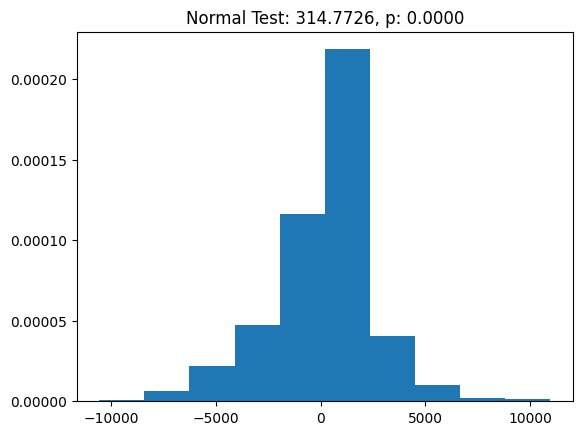

In [584]:
# Learning Phase

use_orig = False

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)

formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)
re_formula = "trialNumbers"

# Filter out participants whose click strategies are not valid
learning_df = learning_df.loc[learning_df.clickStratsValid]

standardize_cols = ["trialNumbers"]
for col in standardize_cols:
    learning_df[col] = (learning_df[col] - learning_df[col].mean())# / learning_df[col].std()

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, re_formula=re_formula,groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

In [585]:
# Plotting the data of both learning phases

x1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Learning Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()


plt.show()



In [586]:
# Performance Phase

use_orig = False

if use_orig:
    performance_df = pd.concat([scarce_performance_data_orig, control_performance_data_orig]).reset_index(drop=True)
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)
    
formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)
re_formula = "trialNumbers"

standardize_cols = ["trialNumbers"]
for col in standardize_cols:
    performance_df[col] = (performance_df[col] - performance_df[col].mean())#}/learning_df[col].std()


# Filter out participants whose click strategies are not valid
performance_df = performance_df.loc[performance_df.clickStratsValid]

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=performance_df, re_formula=re_formula, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                       Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         clicksL5    
No. Observations:           15593           Method:                     REML        
No. Groups:                 503             Scale:                      7997059.1577
Min. group size:            31              Log-Likelihood:             -147341.1739
Max. group size:            31              Converged:                  Yes         
Mean group size:            31.0                                                    
------------------------------------------------------------------------------------
                                  Coef.     Std.Err.   z    P>|z|  [0.025    0.975] 
------------------------------------------------------------------------------------
Intercept                          9828.129  236.692 41.523 0.000 9364.222 10292.036
C(condition)[T.1]                   498.561  335.066  1.488 0.137 -158.155  1155.278
tria

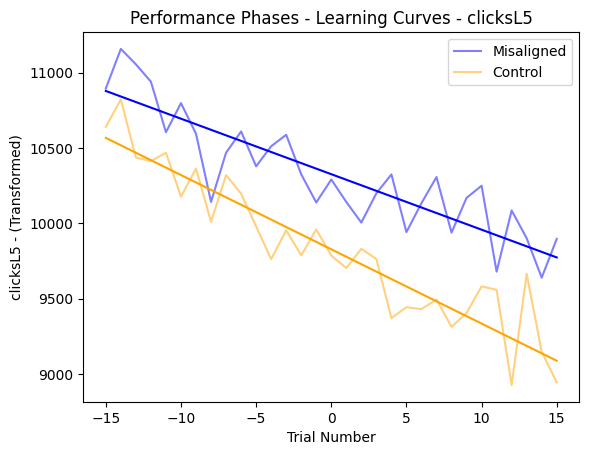

In [587]:
# Plotting the data of both performance phases together

x1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']
        

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Performance Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()

plt.show()

# 2.3 - Linear Regression: ClicksL1 vs. Trial Number x Condition

In [588]:
# Select the response variable for this analysis

response_var = "clicksL1"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

In [589]:
# Learning Phase

use_orig = False

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)

formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)
re_formula = "trialNumbers"

# Filter out participants whose click strategies are not valid
learning_df = learning_df.loc[learning_df.clickStratsValid]

standardize_cols = ["trialNumbers"]
for col in standardize_cols:
    learning_df[col] = (learning_df[col] - learning_df[col].mean())# / learning_df[col].std()

# learning_df["clicksL1"] = learning_df["clicksL1"] * 100

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, re_formula=re_formula, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                  Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       clicksL1 
No. Observations:       4527          Method:                   REML     
No. Groups:             503           Scale:                    0.0035   
Min. group size:        9             Log-Likelihood:           5556.9631
Max. group size:        9             Converged:                Yes      
Mean group size:        9.0                                              
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.061    0.004 14.943 0.000  0.053  0.069
C(condition)[T.1]              -0.002    0.006 -0.389 0.697 -0.014  0.009
trialNumbers                   -0.006    0.001 -8.197 0.000 -0.007 -0.004
trialNumbers:C(condition)[T.1]  0.002    0.001  2.103 0.

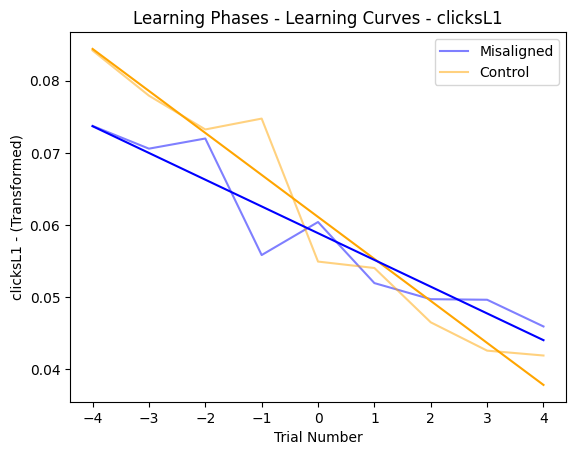

In [590]:
# Plotting the data of both learning phases

x1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Learning Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()


plt.show()



                  Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      clicksL1   
No. Observations:       15593        Method:                  REML       
No. Groups:             503          Scale:                   15.3975    
Min. group size:        31           Log-Likelihood:          -44985.0030
Max. group size:        31           Converged:               Yes        
Mean group size:        31.0                                             
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       2.590    0.344  7.536 0.000  1.916  3.264
C(condition)[T.1]               0.773    0.487  1.589 0.112 -0.180  1.727
trialNumbers                   -0.072    0.014 -5.253 0.000 -0.099 -0.045
trialNumbers:C(condition)[T.1]  0.023    0.019  1.187 0.

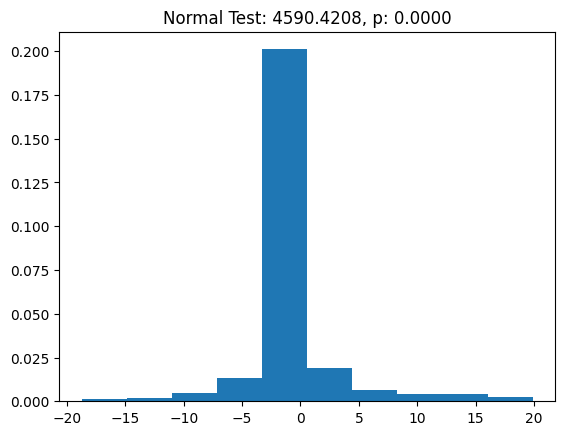

In [591]:
# Performance Phase

use_orig = False

if use_orig:
    performance_df = pd.concat([scarce_performance_data_orig, control_performance_data_orig]).reset_index(drop=True)
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)
    
standardize_cols = ["trialNumbers"]
for col in standardize_cols:
    performance_df[col] = (performance_df[col] - performance_df[col].mean())#}/learning_df[col].std()

    
# Filter out participants whose click strategies are not valid
performance_df = performance_df.loc[performance_df.clickStratsValid]

performance_df["clicksL1"] = performance_df["clicksL1"] * 100

formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)
re_formula = "trialNumbers"

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=performance_df, re_formula=re_formula, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

In [592]:
# Plotting the data of both performance phases together

x1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']
        

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Performance Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()

plt.show()

# 2.4 - Linear Regression: Strategy Score vs. Trial Number x Condition

In [483]:
# Select the response variable for this analysis

response_var = "strategyScores_scaled"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

In [484]:
# Learning Phase

use_orig = True

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)

formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)
re_formula = "trialNumbers"

# Filter out participants whose click strategies are not valid
learning_df = learning_df.loc[learning_df.clickStratsValid]

standardize_cols = ["trialNumbers"]
for col in standardize_cols:
    learning_df[col] = (learning_df[col] - learning_df[col].mean())# / learning_df[col].std()

    
mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, re_formula=re_formula, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                  Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   strategyScores_scaled
No. Observations:   3000      Method:               REML                 
No. Groups:         300       Scale:                0.0134               
Min. group size:    10        Log-Likelihood:       1212.0202            
Max. group size:    10        Converged:            Yes                  
Mean group size:    10.0                                                 
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.386    0.030 12.919 0.000  0.327  0.444
C(condition)[T.1]               0.012    0.043  0.283 0.777 -0.071  0.095
trialNumbers                    0.019    0.003  6.783 0.000  0.014  0.025
trialNumbers:C(condition)[T.1] -0.008    0.004 -2.084 0.

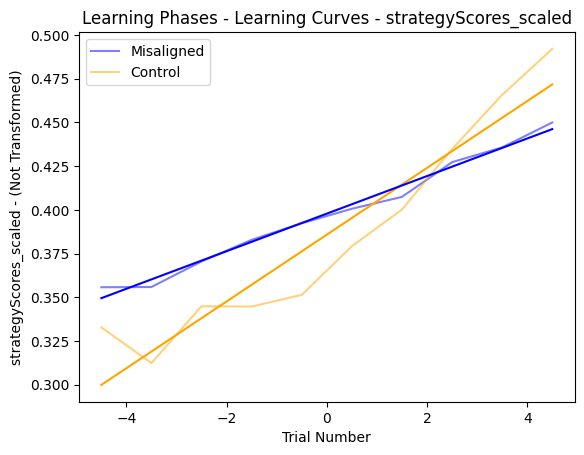

In [485]:
# Plotting the data of both learning phases

x1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Learning Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()


plt.show()



In [486]:
# Performance Phase

use_orig = False

if use_orig:
    performance_df = pd.concat([scarce_performance_data_orig, control_performance_data_orig]).reset_index(drop=True)
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)

standardize_cols = ["trialNumbers"]
for col in standardize_cols:
    performance_df[col] = (performance_df[col] - performance_df[col].mean())#}/learning_df[col].std()
    
# Filter out participants whose click strategies are not valid
performance_df = performance_df.loc[performance_df.clickStratsValid]

performance_df[response_var] = performance_df[response_var] * 100



formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=performance_df, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

                   Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   strategyScores_scaled
No. Observations:     9000      Method:               REML                 
No. Groups:           300       Scale:                34.8378              
Min. group size:      30        Log-Likelihood:       -29592.1412          
Max. group size:      30        Converged:            Yes                  
Mean group size:      30.0                                                 
---------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------------
Intercept                       76.741    1.441 53.252 0.000  73.917 79.566
C(condition)[T.1]               -6.013    2.052 -2.931 0.003 -10.034 -1.992
trialNumbers                     0.184    0.010 18.252 0.000   0.165  0.204
trialNumbers:C(condition)[T.1] 

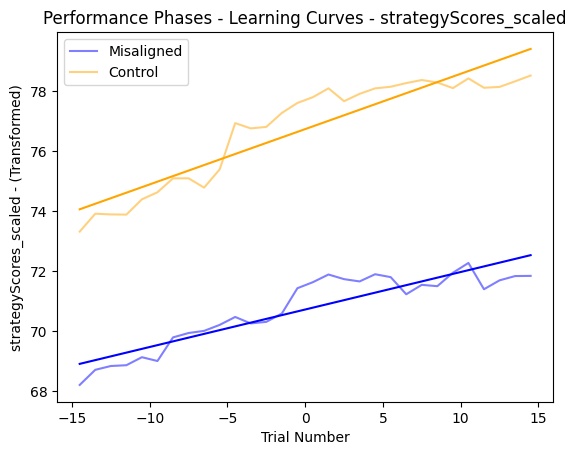

In [487]:
# Plotting the data of both performance phases together

x1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']
        

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Performance Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()

plt.show()

# Appendix

# 1.5 - GLM Strategy Proportions

Observing how the strategies of the participants (as inferred by the Computational Microscope) change over time in each condition

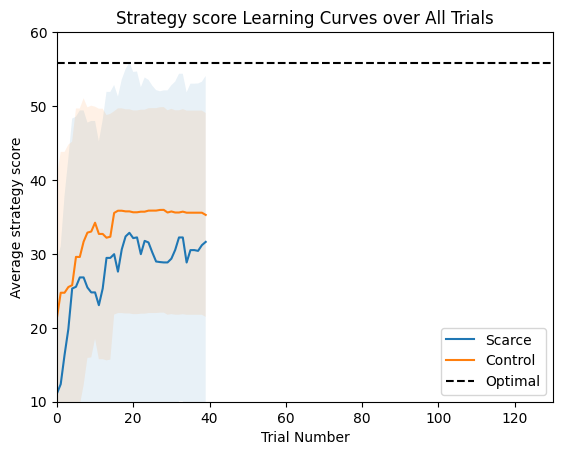

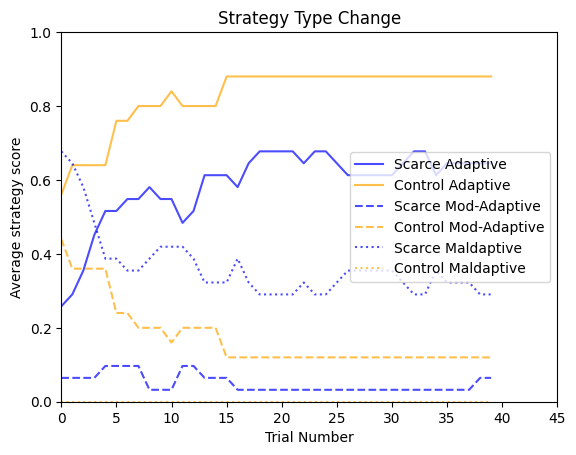

In [151]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

scarce_trial_group = data_to_copy.loc[data_to_copy.condition == 1].groupby('trialNumbers')
control_trial_group = data_to_copy.loc[data_to_copy.condition == 0].groupby('trialNumbers')

# Taking the mean expected score over all trials 
scarce_data_all = np.array(scarce_trial_group.mean(numeric_only=True)["strategyScores"])
scarce_data_all_sd = np.array(scarce_trial_group.std(numeric_only=True)["strategyScores"])
control_data = np.array(control_trial_group.mean(numeric_only=True)["strategyScores"])
control_data_sd = np.array(control_trial_group.std(numeric_only=True)["strategyScores"])

# Getting the proportions of clusters
scarce_data_adaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==0).sum()) / scarce_trial_group["cluster"].count())
control_data_adaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==0).sum()) / control_trial_group["cluster"].count())
scarce_data_modadaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==1).sum()) / scarce_trial_group["cluster"].count())
control_data_modadaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==1).sum()) / control_trial_group["cluster"].count())
scarce_data_maladaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==2).sum()) / scarce_trial_group["cluster"].count())
control_data_maladaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==2).sum()) / control_trial_group["cluster"].count())


plt.figure()
plt.title("Strategy score Learning Curves over All Trials")
plt.plot(list(range(len(scarce_data_all))), scarce_data_all, label="Scarce")
plt.fill_between(list(range(len(scarce_data_all))), scarce_data_all + scarce_data_all_sd, scarce_data_all - scarce_data_all_sd, alpha=0.1)
plt.plot(list(range(len(control_data))), control_data, label="Control")
plt.fill_between(list(range(len(control_data))), control_data + control_data_sd, control_data - control_data_sd, alpha=0.1)
plt.axhline(np.max(np.array(strategy_scores_control_list)[:,1], axis=0), color='k', label='Optimal', linestyle="--")
plt.legend()
plt.ylim([10,60])
plt.xlim([0, 130])
plt.xlabel("Trial Number")
plt.ylabel("Average strategy score")
plt.show()

plt.figure()
plt.title("Strategy Type Change")
alpha = 0.7
plt.plot(list(range(len(scarce_data_all))), scarce_data_adaptive, label="Scarce Adaptive", color='b',alpha=alpha)
plt.plot(list(range(len(control_data))), control_data_adaptive, label="Control Adaptive",color='orange',alpha=alpha)
plt.plot(list(range(len(scarce_data_all))), scarce_data_modadaptive, label="Scarce Mod-Adaptive", color='b',alpha=alpha, linestyle="--")
plt.plot(list(range(len(control_data))), control_data_modadaptive, label="Control Mod-Adaptive",color='orange',alpha=alpha, linestyle="--")
plt.plot(list(range(len(scarce_data_all))), scarce_data_maladaptive, label="Scarce Maldaptive", color='b',alpha=alpha, linestyle=":")
plt.plot(list(range(len(control_data))), control_data_maladaptive, label="Control Maldaptive",color='orange',alpha=alpha, linestyle=":")
plt.legend()
plt.ylim([0,1])
plt.xlim([0, 45])
plt.xlabel("Trial Number")
plt.ylabel("Average strategy score")
plt.show()


In [294]:
# Setting up logistic regression

data_to_copy = analysis_data.copy()
data_to_copy["cluster"] = data_to_copy["cluster"].astype("int64")

formula = "cluster ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"

model_1 = statsmodels.discrete.discrete_model.MNLogit.from_formula(formula, data_to_copy)
model_1_fit = model.fit()

endog = analysis_data["cluster"].astype("int64").map(lambda c: ["cat","dog","bear"][c])
exog = analysis_data[["trialNumbers", "scarce"]]
exog["trialNumbers:scarce"] = exog["trialNumbers"] * exog["scarce"]
exog["const"] = [1] * len(exog)

model_2 = statsmodels.discrete.discrete_model.MNLogit(endog, exog)
model_2_fit = model.fit()

print(model_1_fit.summary())
print(model_2_fit.summary())

Optimization terminated successfully.
         Current function value: 0.608218
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.608218
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                cluster   No. Observations:                15210
Model:                        MNLogit   Df Residuals:                    15202
Method:                           MLE   Df Model:                            6
Date:                Tue, 25 Oct 2022   Pseudo R-squ.:                 0.04896
Time:                        11:32:54   Log-Likelihood:                -9251.0
converged:                       True   LL-Null:                       -9727.3
Covariance Type:            nonrobust   LLR p-value:                1.652e-202
                  cluster=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_51899/3125500743.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog["trialNumbers:scarce"] = exog["trialNumbers"] * exog["scarce"]
/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_51899/3125500743.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog["const"] = [1] * len(exog)


                          MNLogit Regression Results                          
Dep. Variable:                cluster   No. Observations:                15210
Model:                        MNLogit   Df Residuals:                    15202
Method:                           MLE   Df Model:                            6
Date:                Tue, 25 Oct 2022   Pseudo R-squ.:                 0.04896
Time:                        11:32:54   Log-Likelihood:                -9251.0
converged:                       True   LL-Null:                       -9727.3
Covariance Type:            nonrobust   LLR p-value:                1.652e-202
                  cluster=1       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -1.8616      0.145    -12.815      0.000      -2.146      -1.577
C(scarce)[T.1]                 -0.4777      0.167     -2.858      0.004      -0.

In [295]:
sum(model_2.endog == model_1.endog) / len(model_2.endog)

0.0